In [1]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print(f'GPU is available: {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

fastai version : 1.0.59
transformers version : 2.3.0
GPU is available: True


In [4]:
import argparse
import glob
import json
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    XLMConfig,
    XLMForSequenceClassification,
    XLMRobertaConfig,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors

In [5]:
seed = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

## Prepare the full IMDB dataset and inspect the files under that path

In [6]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [7]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/data_bunch_classification'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/fine_tuning_LM'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [8]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

In [9]:
(path/'test').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/test/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/neg')]

In [10]:
import glob

def text_label_pairs_from_folder(path, folders):
    text_label_pairs = [['sentence', 'label']]
    
    for idx, label in enumerate(folders):
        for fname in glob.glob(os.path.join(path, label, '*.*')):
            text_label_pairs.append(list([open(fname,'r').read(), str(idx)]))
    return text_label_pairs

In [11]:
trainpath = Path(path/'train')
testpath  = Path(path/'test')
train_IMDb = text_label_pairs_from_folder(trainpath, ['pos','neg'])
test_IMDb  = text_label_pairs_from_folder(testpath, ['pos','neg'])

In [12]:
len(train_IMDb), len(test_IMDb)

(25001, 25001)

In [13]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [14]:
def _create_examples(lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [15]:
example_IMDb_train = _create_examples(train_IMDb, 'train')
example_IMDb_test  = _create_examples(test_IMDb, 'test')

In [16]:
AlbertForSequenceClassification.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

In [17]:
pretrained_model_name = 'albert-xlarge-v2'
tokenizer = AlbertTokenizer.from_pretrained(pretrained_model_name)

In [18]:
features_IMDb_train = convert_examples_to_features(
                        example_IMDb_train,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 256,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [19]:
features_IMDb_test = convert_examples_to_features(
                        example_IMDb_test,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 256,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [20]:
# Convert to Tensors and build dataset

# for train
features = features_IMDb_train

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_train = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [21]:
# Convert to Tensors and build dataset

# for test
features = features_IMDb_test

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_test = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [22]:
len(dataset_IMDb_train), len(dataset_IMDb_test)

(25000, 25000)

### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [23]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig)
}

In [24]:
model_class, tokenizer_class, config_class = MODEL_CLASSES['albert']

In [25]:
pretrained_model_name

'albert-xlarge-v2'

In [26]:
# Create pretrained model 
config = config_class.from_pretrained(pretrained_model_name, num_labels = 2)

model = model_class.from_pretrained(pretrained_model_name, config = config)

In [27]:
model.to(device);

## Train loop

In [28]:
class args_for_training():
    def __init__(self):
        
        # general parameters
        self.train_batch_size   = 4
        self.eval_batch_size    = 4
        self.max_steps          = -1  # set to -1 if we define the training duration by num_epochs
        self.gradient_accumulation_steps = 1  # update for each batch we take in
        self.num_train_epochs   = 2
        self.device = device
        self.model_type         = 'albert'
        self.logging_steps      = 4000
        self.save_steps         = 4000
        self.local_rank         = -1
        self.output_dir = os.path.join(os.getcwd(),'ALBERT')
        self.evaluate_during_training = True
        self.task_name          = "sst-2"  # this is used to determine evaluation metric (we use simple accuracy)
        self.output_mode        = "classification"
        
        
        # optimizer parameters
        self.weight_decay  = 0.0
        self.learning_rate = 2e-5
        self.adam_epsilon  = 1e-8
        self.warmup_steps  = 4000
        self.model_name_or_path = pretrained_model_name
        self.max_grad_norm = 1.0
        
args = args_for_training()

In [29]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()
   
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=int(t_total*0.3), num_training_steps=t_total
    )
#     scheduler =  get get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
#     )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))


    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(args.model_name_or_path):
        # set global_step to gobal_step of last saved checkpoint from model path
        global_step = int(args.model_name_or_path.split("-")[-1].split("/")[0])
        epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
        steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)


    tr_loss, logging_loss = 0.0, 0.0
    accuracies = list()
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=False,
    )

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            if args.model_type != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            
            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step() 
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logs = {}
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results, accuracy = evaluate(args,train_dataset, model, tokenizer)
                        accuracies.append(accuracy)
                        for key, value in results.items():
                            eval_key = "eval_{}".format(key)
                            logs[eval_key] = value

                    loss_scalar = (tr_loss - logging_loss) / args.logging_steps
                    learning_rate_scalar = scheduler.get_lr()[0]
                    logs["learning_rate"] = learning_rate_scalar
                    logs["loss"] = loss_scalar
                    logging_loss = tr_loss

                    for key, value in logs.items():
                        tb_writer.add_scalar(key, value, global_step)
                    print(json.dumps({**logs, **{"step": global_step}}))

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step, accuracies

In [30]:
def simple_accuracy(preds, labels):
    
    return {"acc": (preds == labels).mean()}

In [31]:
def evaluate(args,dataset, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = "sst-2"
    eval_outputs_dirs = (args.output_dir, args.output_dir + "-MM") if args.task_name == "mnli" else (args.output_dir,)

    results = {}
    accuracies = []
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = dataset_IMDb_test

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=args.train_batch_size)

        
        # Eval!
        
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
                if args.model_type != "distilbert":
                    inputs["token_type_ids"] = (
                        batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                    )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        if args.output_mode == "classification":
            preds = np.argmax(preds, axis=1)
        elif args.output_mode == "regression":
            preds = np.squeeze(preds)
        result = simple_accuracy(preds, out_label_ids)
        results.update(result)
        accuracies.append(result['acc'])

        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

    return results, accuracies

In [32]:
logger = logging.getLogger(__name__)

In [33]:
global_step, tr_loss, accuracies = train(args, dataset_IMDb_train, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

Iteration:   2%|▏         | 122/6250 [02:15<1:56:35,  1.14s/it]


Iteration:   4%|▍         | 244/6250 [04:41<2:02:40,  1.23s/it]


Iteration:   6%|▌         | 366/6250 [07:10<2:00:06,  1.22s/it]


Iteration:   8%|▊         | 488/6250 [09:39<1:57:53,  1.23s/it]


Iteration:  10%|▉         | 610/6250 [12:09<1:55:40,  1.23s/it]


Iteration:  12%|█▏        | 732/6250 [14:38<1:53:07,  1.23s/it]


Iteration:  14%|█▎        | 854/6250 [17:08<1:50:23,  1.23s/it]


Iteration:  16%|█▌        | 976/6250 [19:38<1:48:20,  1.23s/it]


Iteration:  18%|█▊        | 1096/6250 [22:05<1:45:48,  1.23s/it]


Iteration:  19%|█▉        | 1216/6250 [24:32<1:40:34,  1.20s/it]


Iteration:  21%|██▏       | 1336/6250 [26:59<1:40:34,  1.23s/it]


Iteration:  23%|██▎       | 1456/6250 [29:26<1:38:21,  1.23s/it]


Iteration:  25%|██▌       | 1576/6250 [31:53<1:35:27,  1.23s/it]


Iteration:  27%|██▋       | 1696/6250 [34:20<1:33:29,  1.23s/it]


Iteration:  29%|██▉       | 1816/6250 [36:47<1:30:43,  1.23s/it]


Iteration:  31%|███       | 1936/6250 [39:14<1:28:22,  1.23s/it]


Iteration:  33%|███▎      | 2056/6250 [41:41<1:25:51,  1.23s/it]


Iteration:  35%|███▍      | 2176/6250 [44:08<1:23:28,  1.23s/it]


Iteration:  37%|███▋      | 2296/6250 [46:35<1:20:47,  1.23s/it]


Iteration:  39%|███▊      | 2416/6250 [49:02<1:18:43,  1.23s/it]


Iteration:  41%|████      | 2536/6250 [51:29<1:15:53,  1.23s/it]


Iteration:  42%|████▏     | 2656/6250 [53:57<1:13:41,  1.23s/it]


Iteration:  44%|████▍     | 2776/6250 [56:23<1:11:24,  1.23s/it]


Iteration:  46%|████▋     | 2896/6250 [58:51<1:08:36,  1.23s/it]


Iteration:  48%|████▊     | 3014/6250 [1:01:15<1:05:54,  1.22s/it]


Iteration:  50%|█████     | 3131/6250 [1:03:39<1:04:02,  1.23s/it]


Iteration:  52%|█████▏    | 3248/6250 [1:06:03<1:01:32,  1.23s/it]


Iteration:  54%|█████▍    | 3366/6250 [1:08:27<58:39,  1.22s/it]


Iteration:  56%|█████▌    | 3486/6250 [1:10:54<56:46,  1.23s/it]


Iteration:  58%|█████▊    | 3606/6250 [1:13:22<54:12,  1.23s/it]


Iteration:  60%|█████▉    | 3726/6250 [1:15:49<51:31,  1.22s/it]


Iteration:  62%|██████▏   | 3846/6250 [1:18:17<49:19,  1.23s/it]


Iteration:  63%|██████▎   | 3966/6250 [1:20:44<46:41,  1.23s/it]


Iteration:  64%|██████▍   | 3999/6250 [1:21:24<46:10,  1.23s/it]

Evaluating:   0%|          | 0/6250 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/6250 [00:00<43:42,  2.38it/s]

Evaluating:   0%|          | 2/6250 [00:00<43:35,  2.39it/s]

Evaluating:   0%|          | 3/6250 [00:01<43:32,  2.39it/s]

Evaluating:   0%|          | 4/6250 [00:01<43:32,  2.39it/s]

Evaluating:   0%|          | 5/6250 [00:02<43:27,  2.40it/s]

Evaluating:   0%|          | 6/6250 [00:02<43:27,  2.39it/s]

Evaluating:   0%|          | 7/6250 [00:02<43:24,  2.40it/s]

Evaluating:   0%|          | 8/6250 [00:03<43:25,  2.40it/s]

Evaluating:   0%|          | 9/6250 [00:03<43:29,  2.39it/s]

Evaluating:   0%|          | 10/6250 [00:04<43:30,  2.39it/s]

Evaluating:   0%|          | 11/6250 [00:04<43:33,  2.39it/s]

Evaluating:   0%|          | 12/6250 [00:05<43:28,  2.39it/s]

Evaluating:   0%|          | 13/6250 [00:05<43:29,  2.39it/s]

Evaluating:   0%|          | 14/6250 [00:05<43:27,  2.39it/s]

Evaluat

Evaluating:   1%|▏         | 86/6250 [00:35<43:01,  2.39it/s]

Evaluating:   1%|▏         | 87/6250 [00:36<43:04,  2.38it/s]

Evaluating:   1%|▏         | 88/6250 [00:36<43:01,  2.39it/s]

Evaluating:   1%|▏         | 89/6250 [00:37<43:05,  2.38it/s]

Evaluating:   1%|▏         | 90/6250 [00:37<43:07,  2.38it/s]

Evaluating:   1%|▏         | 91/6250 [00:38<43:06,  2.38it/s]

Evaluating:   1%|▏         | 92/6250 [00:38<43:05,  2.38it/s]

Evaluating:   1%|▏         | 93/6250 [00:38<43:05,  2.38it/s]

Evaluating:   2%|▏         | 94/6250 [00:39<43:06,  2.38it/s]

Evaluating:   2%|▏         | 95/6250 [00:39<43:06,  2.38it/s]

Evaluating:   2%|▏         | 96/6250 [00:40<43:02,  2.38it/s]

Evaluating:   2%|▏         | 97/6250 [00:40<43:01,  2.38it/s]

Evaluating:   2%|▏         | 98/6250 [00:41<42:53,  2.39it/s]

Evaluating:   2%|▏         | 99/6250 [00:41<42:50,  2.39it/s]

Evaluating:   2%|▏         | 100/6250 [00:41<42:51,  2.39it/s]

Evaluating:   2%|▏         | 101/6250 [00:42<42:54,  2

Evaluating:   3%|▎         | 203/6250 [01:24<42:13,  2.39it/s]

Evaluating:   3%|▎         | 204/6250 [01:25<42:11,  2.39it/s]

Evaluating:   3%|▎         | 205/6250 [01:25<42:09,  2.39it/s]

Evaluating:   3%|▎         | 206/6250 [01:26<42:11,  2.39it/s]

Evaluating:   3%|▎         | 207/6250 [01:26<42:13,  2.39it/s]

Evaluating:   3%|▎         | 208/6250 [01:27<42:07,  2.39it/s]

Evaluating:   3%|▎         | 209/6250 [01:27<42:08,  2.39it/s]

Evaluating:   3%|▎         | 210/6250 [01:27<42:05,  2.39it/s]

Evaluating:   3%|▎         | 211/6250 [01:28<42:03,  2.39it/s]

Evaluating:   3%|▎         | 212/6250 [01:28<42:04,  2.39it/s]

Evaluating:   3%|▎         | 213/6250 [01:29<42:06,  2.39it/s]

Evaluating:   3%|▎         | 214/6250 [01:29<42:04,  2.39it/s]

Evaluating:   3%|▎         | 215/6250 [01:30<42:08,  2.39it/s]

Evaluating:   3%|▎         | 216/6250 [01:30<42:03,  2.39it/s]

Evaluating:   3%|▎         | 217/6250 [01:30<42:03,  2.39it/s]

Evaluating:   3%|▎         | 218/6250 [0

Evaluating:   5%|▌         | 320/6250 [02:13<41:18,  2.39it/s]

Evaluating:   5%|▌         | 321/6250 [02:14<41:19,  2.39it/s]

Evaluating:   5%|▌         | 322/6250 [02:14<41:23,  2.39it/s]

Evaluating:   5%|▌         | 323/6250 [02:15<41:24,  2.39it/s]

Evaluating:   5%|▌         | 324/6250 [02:15<41:19,  2.39it/s]

Evaluating:   5%|▌         | 325/6250 [02:16<41:20,  2.39it/s]

Evaluating:   5%|▌         | 326/6250 [02:16<41:20,  2.39it/s]

Evaluating:   5%|▌         | 327/6250 [02:16<41:19,  2.39it/s]

Evaluating:   5%|▌         | 328/6250 [02:17<41:16,  2.39it/s]

Evaluating:   5%|▌         | 329/6250 [02:17<41:18,  2.39it/s]

Evaluating:   5%|▌         | 330/6250 [02:18<41:15,  2.39it/s]

Evaluating:   5%|▌         | 331/6250 [02:18<41:21,  2.39it/s]

Evaluating:   5%|▌         | 332/6250 [02:18<41:21,  2.38it/s]

Evaluating:   5%|▌         | 333/6250 [02:19<41:19,  2.39it/s]

Evaluating:   5%|▌         | 334/6250 [02:19<41:16,  2.39it/s]

Evaluating:   5%|▌         | 335/6250 [0

Evaluating:   7%|▋         | 437/6250 [03:02<40:32,  2.39it/s]

Evaluating:   7%|▋         | 438/6250 [03:03<40:31,  2.39it/s]

Evaluating:   7%|▋         | 439/6250 [03:03<40:34,  2.39it/s]

Evaluating:   7%|▋         | 440/6250 [03:04<40:22,  2.40it/s]

Evaluating:   7%|▋         | 441/6250 [03:04<40:27,  2.39it/s]

Evaluating:   7%|▋         | 442/6250 [03:05<40:28,  2.39it/s]

Evaluating:   7%|▋         | 443/6250 [03:05<40:27,  2.39it/s]

Evaluating:   7%|▋         | 444/6250 [03:05<40:23,  2.40it/s]

Evaluating:   7%|▋         | 445/6250 [03:06<40:25,  2.39it/s]

Evaluating:   7%|▋         | 446/6250 [03:06<40:27,  2.39it/s]

Evaluating:   7%|▋         | 447/6250 [03:07<40:28,  2.39it/s]

Evaluating:   7%|▋         | 448/6250 [03:07<40:22,  2.39it/s]

Evaluating:   7%|▋         | 449/6250 [03:07<40:25,  2.39it/s]

Evaluating:   7%|▋         | 450/6250 [03:08<40:23,  2.39it/s]

Evaluating:   7%|▋         | 451/6250 [03:08<40:22,  2.39it/s]

Evaluating:   7%|▋         | 452/6250 [0

Evaluating:   9%|▉         | 554/6250 [03:51<39:46,  2.39it/s]

Evaluating:   9%|▉         | 555/6250 [03:52<39:50,  2.38it/s]

Evaluating:   9%|▉         | 556/6250 [03:52<39:46,  2.39it/s]

Evaluating:   9%|▉         | 557/6250 [03:53<39:47,  2.38it/s]

Evaluating:   9%|▉         | 558/6250 [03:53<39:45,  2.39it/s]

Evaluating:   9%|▉         | 559/6250 [03:54<39:48,  2.38it/s]

Evaluating:   9%|▉         | 560/6250 [03:54<39:48,  2.38it/s]

Evaluating:   9%|▉         | 561/6250 [03:54<39:46,  2.38it/s]

Evaluating:   9%|▉         | 562/6250 [03:55<39:45,  2.38it/s]

Evaluating:   9%|▉         | 563/6250 [03:55<39:47,  2.38it/s]

Evaluating:   9%|▉         | 564/6250 [03:56<39:40,  2.39it/s]

Evaluating:   9%|▉         | 565/6250 [03:56<39:42,  2.39it/s]

Evaluating:   9%|▉         | 566/6250 [03:56<39:43,  2.38it/s]

Evaluating:   9%|▉         | 567/6250 [03:57<39:45,  2.38it/s]

Evaluating:   9%|▉         | 568/6250 [03:57<39:39,  2.39it/s]

Evaluating:   9%|▉         | 569/6250 [0

Evaluating:  11%|█         | 671/6250 [04:40<38:59,  2.39it/s]

Evaluating:  11%|█         | 672/6250 [04:41<38:54,  2.39it/s]

Evaluating:  11%|█         | 673/6250 [04:41<38:55,  2.39it/s]

Evaluating:  11%|█         | 674/6250 [04:42<38:54,  2.39it/s]

Evaluating:  11%|█         | 675/6250 [04:42<38:53,  2.39it/s]

Evaluating:  11%|█         | 676/6250 [04:43<38:51,  2.39it/s]

Evaluating:  11%|█         | 677/6250 [04:43<38:54,  2.39it/s]

Evaluating:  11%|█         | 678/6250 [04:43<38:55,  2.39it/s]

Evaluating:  11%|█         | 679/6250 [04:44<38:55,  2.38it/s]

Evaluating:  11%|█         | 680/6250 [04:44<38:53,  2.39it/s]

Evaluating:  11%|█         | 681/6250 [04:45<38:51,  2.39it/s]

Evaluating:  11%|█         | 682/6250 [04:45<38:51,  2.39it/s]

Evaluating:  11%|█         | 683/6250 [04:45<38:51,  2.39it/s]

Evaluating:  11%|█         | 684/6250 [04:46<38:49,  2.39it/s]

Evaluating:  11%|█         | 685/6250 [04:46<38:54,  2.38it/s]

Evaluating:  11%|█         | 686/6250 [0

Evaluating:  13%|█▎        | 788/6250 [05:29<38:05,  2.39it/s]

Evaluating:  13%|█▎        | 789/6250 [05:30<38:06,  2.39it/s]

Evaluating:  13%|█▎        | 790/6250 [05:30<38:07,  2.39it/s]

Evaluating:  13%|█▎        | 791/6250 [05:31<38:07,  2.39it/s]

Evaluating:  13%|█▎        | 792/6250 [05:31<38:03,  2.39it/s]

Evaluating:  13%|█▎        | 793/6250 [05:31<38:06,  2.39it/s]

Evaluating:  13%|█▎        | 794/6250 [05:32<38:06,  2.39it/s]

Evaluating:  13%|█▎        | 795/6250 [05:32<38:07,  2.38it/s]

Evaluating:  13%|█▎        | 796/6250 [05:33<38:03,  2.39it/s]

Evaluating:  13%|█▎        | 797/6250 [05:33<38:01,  2.39it/s]

Evaluating:  13%|█▎        | 798/6250 [05:34<37:59,  2.39it/s]

Evaluating:  13%|█▎        | 799/6250 [05:34<37:57,  2.39it/s]

Evaluating:  13%|█▎        | 800/6250 [05:34<37:54,  2.40it/s]

Evaluating:  13%|█▎        | 801/6250 [05:35<37:57,  2.39it/s]

Evaluating:  13%|█▎        | 802/6250 [05:35<37:54,  2.39it/s]

Evaluating:  13%|█▎        | 803/6250 [0

Evaluating:  14%|█▍        | 905/6250 [06:18<37:19,  2.39it/s]

Evaluating:  14%|█▍        | 906/6250 [06:19<37:16,  2.39it/s]

Evaluating:  15%|█▍        | 907/6250 [06:19<37:13,  2.39it/s]

Evaluating:  15%|█▍        | 908/6250 [06:20<37:09,  2.40it/s]

Evaluating:  15%|█▍        | 909/6250 [06:20<37:13,  2.39it/s]

Evaluating:  15%|█▍        | 910/6250 [06:20<37:14,  2.39it/s]

Evaluating:  15%|█▍        | 911/6250 [06:21<37:16,  2.39it/s]

Evaluating:  15%|█▍        | 912/6250 [06:21<37:14,  2.39it/s]

Evaluating:  15%|█▍        | 913/6250 [06:22<37:18,  2.38it/s]

Evaluating:  15%|█▍        | 914/6250 [06:22<37:19,  2.38it/s]

Evaluating:  15%|█▍        | 915/6250 [06:22<37:15,  2.39it/s]

Evaluating:  15%|█▍        | 916/6250 [06:23<37:24,  2.38it/s]

Evaluating:  15%|█▍        | 917/6250 [06:23<37:21,  2.38it/s]

Evaluating:  15%|█▍        | 918/6250 [06:24<37:16,  2.38it/s]

Evaluating:  15%|█▍        | 919/6250 [06:24<37:12,  2.39it/s]

Evaluating:  15%|█▍        | 920/6250 [0

Evaluating:  16%|█▋        | 1021/6250 [07:07<36:35,  2.38it/s]

Evaluating:  16%|█▋        | 1022/6250 [07:07<36:33,  2.38it/s]

Evaluating:  16%|█▋        | 1023/6250 [07:08<36:34,  2.38it/s]

Evaluating:  16%|█▋        | 1024/6250 [07:08<36:34,  2.38it/s]

Evaluating:  16%|█▋        | 1025/6250 [07:09<36:31,  2.38it/s]

Evaluating:  16%|█▋        | 1026/6250 [07:09<36:31,  2.38it/s]

Evaluating:  16%|█▋        | 1027/6250 [07:09<36:31,  2.38it/s]

Evaluating:  16%|█▋        | 1028/6250 [07:10<36:27,  2.39it/s]

Evaluating:  16%|█▋        | 1029/6250 [07:10<36:25,  2.39it/s]

Evaluating:  16%|█▋        | 1030/6250 [07:11<36:21,  2.39it/s]

Evaluating:  16%|█▋        | 1031/6250 [07:11<36:23,  2.39it/s]

Evaluating:  17%|█▋        | 1032/6250 [07:12<36:21,  2.39it/s]

Evaluating:  17%|█▋        | 1033/6250 [07:12<36:24,  2.39it/s]

Evaluating:  17%|█▋        | 1034/6250 [07:12<36:23,  2.39it/s]

Evaluating:  17%|█▋        | 1035/6250 [07:13<36:26,  2.39it/s]

Evaluating:  17%|█▋      

Evaluating:  18%|█▊        | 1136/6250 [07:55<35:43,  2.39it/s]

Evaluating:  18%|█▊        | 1137/6250 [07:55<35:43,  2.38it/s]

Evaluating:  18%|█▊        | 1138/6250 [07:56<35:38,  2.39it/s]

Evaluating:  18%|█▊        | 1139/6250 [07:56<35:36,  2.39it/s]

Evaluating:  18%|█▊        | 1140/6250 [07:57<35:35,  2.39it/s]

Evaluating:  18%|█▊        | 1141/6250 [07:57<35:36,  2.39it/s]

Evaluating:  18%|█▊        | 1142/6250 [07:58<35:39,  2.39it/s]

Evaluating:  18%|█▊        | 1143/6250 [07:58<35:38,  2.39it/s]

Evaluating:  18%|█▊        | 1144/6250 [07:58<35:36,  2.39it/s]

Evaluating:  18%|█▊        | 1145/6250 [07:59<35:31,  2.39it/s]

Evaluating:  18%|█▊        | 1146/6250 [07:59<35:32,  2.39it/s]

Evaluating:  18%|█▊        | 1147/6250 [08:00<35:35,  2.39it/s]

Evaluating:  18%|█▊        | 1148/6250 [08:00<35:37,  2.39it/s]

Evaluating:  18%|█▊        | 1149/6250 [08:00<35:39,  2.38it/s]

Evaluating:  18%|█▊        | 1150/6250 [08:01<35:36,  2.39it/s]

Evaluating:  18%|█▊      

Evaluating:  20%|██        | 1251/6250 [08:43<34:50,  2.39it/s]

Evaluating:  20%|██        | 1252/6250 [08:44<34:51,  2.39it/s]

Evaluating:  20%|██        | 1253/6250 [08:44<34:52,  2.39it/s]

Evaluating:  20%|██        | 1254/6250 [08:44<34:51,  2.39it/s]

Evaluating:  20%|██        | 1255/6250 [08:45<34:46,  2.39it/s]

Evaluating:  20%|██        | 1256/6250 [08:45<34:48,  2.39it/s]

Evaluating:  20%|██        | 1257/6250 [08:46<34:47,  2.39it/s]

Evaluating:  20%|██        | 1258/6250 [08:46<34:46,  2.39it/s]

Evaluating:  20%|██        | 1259/6250 [08:47<34:44,  2.39it/s]

Evaluating:  20%|██        | 1260/6250 [08:47<34:42,  2.40it/s]

Evaluating:  20%|██        | 1261/6250 [08:47<34:44,  2.39it/s]

Evaluating:  20%|██        | 1262/6250 [08:48<34:45,  2.39it/s]

Evaluating:  20%|██        | 1263/6250 [08:48<34:47,  2.39it/s]

Evaluating:  20%|██        | 1264/6250 [08:49<34:47,  2.39it/s]

Evaluating:  20%|██        | 1265/6250 [08:49<34:48,  2.39it/s]

Evaluating:  20%|██      

Evaluating:  22%|██▏       | 1366/6250 [09:31<33:56,  2.40it/s]

Evaluating:  22%|██▏       | 1367/6250 [09:32<33:59,  2.39it/s]

Evaluating:  22%|██▏       | 1368/6250 [09:32<34:01,  2.39it/s]

Evaluating:  22%|██▏       | 1369/6250 [09:33<34:00,  2.39it/s]

Evaluating:  22%|██▏       | 1370/6250 [09:33<34:01,  2.39it/s]

Evaluating:  22%|██▏       | 1371/6250 [09:33<34:05,  2.38it/s]

Evaluating:  22%|██▏       | 1372/6250 [09:34<34:02,  2.39it/s]

Evaluating:  22%|██▏       | 1373/6250 [09:34<34:03,  2.39it/s]

Evaluating:  22%|██▏       | 1374/6250 [09:35<34:02,  2.39it/s]

Evaluating:  22%|██▏       | 1375/6250 [09:35<33:59,  2.39it/s]

Evaluating:  22%|██▏       | 1376/6250 [09:36<33:56,  2.39it/s]

Evaluating:  22%|██▏       | 1377/6250 [09:36<33:58,  2.39it/s]

Evaluating:  22%|██▏       | 1378/6250 [09:36<33:56,  2.39it/s]

Evaluating:  22%|██▏       | 1379/6250 [09:37<33:57,  2.39it/s]

Evaluating:  22%|██▏       | 1380/6250 [09:37<33:55,  2.39it/s]

Evaluating:  22%|██▏     

Evaluating:  24%|██▎       | 1481/6250 [10:20<33:15,  2.39it/s]

Evaluating:  24%|██▎       | 1482/6250 [10:20<33:08,  2.40it/s]

Evaluating:  24%|██▎       | 1483/6250 [10:20<33:15,  2.39it/s]

Evaluating:  24%|██▎       | 1484/6250 [10:21<33:15,  2.39it/s]

Evaluating:  24%|██▍       | 1485/6250 [10:21<33:15,  2.39it/s]

Evaluating:  24%|██▍       | 1486/6250 [10:22<33:14,  2.39it/s]

Evaluating:  24%|██▍       | 1487/6250 [10:22<33:14,  2.39it/s]

Evaluating:  24%|██▍       | 1488/6250 [10:22<33:12,  2.39it/s]

Evaluating:  24%|██▍       | 1489/6250 [10:23<33:12,  2.39it/s]

Evaluating:  24%|██▍       | 1490/6250 [10:23<33:12,  2.39it/s]

Evaluating:  24%|██▍       | 1491/6250 [10:24<33:13,  2.39it/s]

Evaluating:  24%|██▍       | 1492/6250 [10:24<33:11,  2.39it/s]

Evaluating:  24%|██▍       | 1493/6250 [10:25<33:11,  2.39it/s]

Evaluating:  24%|██▍       | 1494/6250 [10:25<33:13,  2.39it/s]

Evaluating:  24%|██▍       | 1495/6250 [10:25<33:13,  2.39it/s]

Evaluating:  24%|██▍     

Evaluating:  26%|██▌       | 1596/6250 [11:08<32:30,  2.39it/s]

Evaluating:  26%|██▌       | 1597/6250 [11:08<32:30,  2.39it/s]

Evaluating:  26%|██▌       | 1598/6250 [11:09<32:32,  2.38it/s]

Evaluating:  26%|██▌       | 1599/6250 [11:09<32:34,  2.38it/s]

Evaluating:  26%|██▌       | 1600/6250 [11:09<32:33,  2.38it/s]

Evaluating:  26%|██▌       | 1601/6250 [11:10<32:32,  2.38it/s]

Evaluating:  26%|██▌       | 1602/6250 [11:10<32:28,  2.39it/s]

Evaluating:  26%|██▌       | 1603/6250 [11:11<32:31,  2.38it/s]

Evaluating:  26%|██▌       | 1604/6250 [11:11<32:26,  2.39it/s]

Evaluating:  26%|██▌       | 1605/6250 [11:11<32:25,  2.39it/s]

Evaluating:  26%|██▌       | 1606/6250 [11:12<32:23,  2.39it/s]

Evaluating:  26%|██▌       | 1607/6250 [11:12<32:27,  2.38it/s]

Evaluating:  26%|██▌       | 1608/6250 [11:13<32:26,  2.38it/s]

Evaluating:  26%|██▌       | 1609/6250 [11:13<32:26,  2.38it/s]

Evaluating:  26%|██▌       | 1610/6250 [11:14<32:24,  2.39it/s]

Evaluating:  26%|██▌     

Evaluating:  27%|██▋       | 1711/6250 [11:56<31:39,  2.39it/s]

Evaluating:  27%|██▋       | 1712/6250 [11:56<31:35,  2.39it/s]

Evaluating:  27%|██▋       | 1713/6250 [11:57<31:39,  2.39it/s]

Evaluating:  27%|██▋       | 1714/6250 [11:57<31:35,  2.39it/s]

Evaluating:  27%|██▋       | 1715/6250 [11:57<31:38,  2.39it/s]

Evaluating:  27%|██▋       | 1716/6250 [11:58<31:36,  2.39it/s]

Evaluating:  27%|██▋       | 1717/6250 [11:58<31:39,  2.39it/s]

Evaluating:  27%|██▋       | 1718/6250 [11:59<31:36,  2.39it/s]

Evaluating:  28%|██▊       | 1719/6250 [11:59<31:41,  2.38it/s]

Evaluating:  28%|██▊       | 1720/6250 [12:00<31:41,  2.38it/s]

Evaluating:  28%|██▊       | 1721/6250 [12:00<31:40,  2.38it/s]

Evaluating:  28%|██▊       | 1722/6250 [12:00<31:38,  2.39it/s]

Evaluating:  28%|██▊       | 1723/6250 [12:01<31:35,  2.39it/s]

Evaluating:  28%|██▊       | 1724/6250 [12:01<31:35,  2.39it/s]

Evaluating:  28%|██▊       | 1725/6250 [12:02<31:38,  2.38it/s]

Evaluating:  28%|██▊     

Evaluating:  29%|██▉       | 1826/6250 [12:44<30:52,  2.39it/s]

Evaluating:  29%|██▉       | 1827/6250 [12:44<30:52,  2.39it/s]

Evaluating:  29%|██▉       | 1828/6250 [12:45<30:50,  2.39it/s]

Evaluating:  29%|██▉       | 1829/6250 [12:45<30:51,  2.39it/s]

Evaluating:  29%|██▉       | 1830/6250 [12:46<30:47,  2.39it/s]

Evaluating:  29%|██▉       | 1831/6250 [12:46<30:50,  2.39it/s]

Evaluating:  29%|██▉       | 1832/6250 [12:46<30:51,  2.39it/s]

Evaluating:  29%|██▉       | 1833/6250 [12:47<30:51,  2.39it/s]

Evaluating:  29%|██▉       | 1834/6250 [12:47<30:49,  2.39it/s]

Evaluating:  29%|██▉       | 1835/6250 [12:48<30:48,  2.39it/s]

Evaluating:  29%|██▉       | 1836/6250 [12:48<30:45,  2.39it/s]

Evaluating:  29%|██▉       | 1837/6250 [12:49<30:46,  2.39it/s]

Evaluating:  29%|██▉       | 1838/6250 [12:49<30:49,  2.39it/s]

Evaluating:  29%|██▉       | 1839/6250 [12:49<30:52,  2.38it/s]

Evaluating:  29%|██▉       | 1840/6250 [12:50<30:51,  2.38it/s]

Evaluating:  29%|██▉     

Evaluating:  31%|███       | 1941/6250 [13:32<29:59,  2.39it/s]

Evaluating:  31%|███       | 1942/6250 [13:32<30:02,  2.39it/s]

Evaluating:  31%|███       | 1943/6250 [13:33<30:02,  2.39it/s]

Evaluating:  31%|███       | 1944/6250 [13:33<30:01,  2.39it/s]

Evaluating:  31%|███       | 1945/6250 [13:34<29:59,  2.39it/s]

Evaluating:  31%|███       | 1946/6250 [13:34<30:04,  2.38it/s]

Evaluating:  31%|███       | 1947/6250 [13:35<30:03,  2.39it/s]

Evaluating:  31%|███       | 1948/6250 [13:35<30:00,  2.39it/s]

Evaluating:  31%|███       | 1949/6250 [13:35<30:01,  2.39it/s]

Evaluating:  31%|███       | 1950/6250 [13:36<30:00,  2.39it/s]

Evaluating:  31%|███       | 1951/6250 [13:36<29:59,  2.39it/s]

Evaluating:  31%|███       | 1952/6250 [13:37<30:00,  2.39it/s]

Evaluating:  31%|███       | 1953/6250 [13:37<30:02,  2.38it/s]

Evaluating:  31%|███▏      | 1954/6250 [13:38<29:59,  2.39it/s]

Evaluating:  31%|███▏      | 1955/6250 [13:38<29:56,  2.39it/s]

Evaluating:  31%|███▏    

Evaluating:  33%|███▎      | 2056/6250 [14:20<29:10,  2.40it/s]

Evaluating:  33%|███▎      | 2057/6250 [14:21<29:03,  2.41it/s]

Evaluating:  33%|███▎      | 2058/6250 [14:21<28:52,  2.42it/s]

Evaluating:  33%|███▎      | 2059/6250 [14:21<28:48,  2.43it/s]

Evaluating:  33%|███▎      | 2060/6250 [14:22<28:48,  2.42it/s]

Evaluating:  33%|███▎      | 2061/6250 [14:22<28:50,  2.42it/s]

Evaluating:  33%|███▎      | 2062/6250 [14:23<28:58,  2.41it/s]

Evaluating:  33%|███▎      | 2063/6250 [14:23<29:04,  2.40it/s]

Evaluating:  33%|███▎      | 2064/6250 [14:23<29:05,  2.40it/s]

Evaluating:  33%|███▎      | 2065/6250 [14:24<29:08,  2.39it/s]

Evaluating:  33%|███▎      | 2066/6250 [14:24<29:04,  2.40it/s]

Evaluating:  33%|███▎      | 2067/6250 [14:25<29:04,  2.40it/s]

Evaluating:  33%|███▎      | 2068/6250 [14:25<29:01,  2.40it/s]

Evaluating:  33%|███▎      | 2069/6250 [14:26<29:02,  2.40it/s]

Evaluating:  33%|███▎      | 2070/6250 [14:26<29:03,  2.40it/s]

Evaluating:  33%|███▎    

Evaluating:  35%|███▍      | 2171/6250 [15:08<28:26,  2.39it/s]

Evaluating:  35%|███▍      | 2172/6250 [15:09<28:25,  2.39it/s]

Evaluating:  35%|███▍      | 2173/6250 [15:09<28:22,  2.39it/s]

Evaluating:  35%|███▍      | 2174/6250 [15:10<28:22,  2.39it/s]

Evaluating:  35%|███▍      | 2175/6250 [15:10<28:26,  2.39it/s]

Evaluating:  35%|███▍      | 2176/6250 [15:10<28:26,  2.39it/s]

Evaluating:  35%|███▍      | 2177/6250 [15:11<28:25,  2.39it/s]

Evaluating:  35%|███▍      | 2178/6250 [15:11<28:26,  2.39it/s]

Evaluating:  35%|███▍      | 2179/6250 [15:12<28:28,  2.38it/s]

Evaluating:  35%|███▍      | 2180/6250 [15:12<28:27,  2.38it/s]

Evaluating:  35%|███▍      | 2181/6250 [15:12<28:28,  2.38it/s]

Evaluating:  35%|███▍      | 2182/6250 [15:13<28:29,  2.38it/s]

Evaluating:  35%|███▍      | 2183/6250 [15:13<28:26,  2.38it/s]

Evaluating:  35%|███▍      | 2184/6250 [15:14<28:23,  2.39it/s]

Evaluating:  35%|███▍      | 2185/6250 [15:14<28:23,  2.39it/s]

Evaluating:  35%|███▍    

Evaluating:  37%|███▋      | 2286/6250 [15:56<27:46,  2.38it/s]

Evaluating:  37%|███▋      | 2287/6250 [15:57<27:44,  2.38it/s]

Evaluating:  37%|███▋      | 2288/6250 [15:57<27:43,  2.38it/s]

Evaluating:  37%|███▋      | 2289/6250 [15:58<27:41,  2.38it/s]

Evaluating:  37%|███▋      | 2290/6250 [15:58<27:40,  2.38it/s]

Evaluating:  37%|███▋      | 2291/6250 [15:59<27:40,  2.38it/s]

Evaluating:  37%|███▋      | 2292/6250 [15:59<27:36,  2.39it/s]

Evaluating:  37%|███▋      | 2293/6250 [15:59<27:33,  2.39it/s]

Evaluating:  37%|███▋      | 2294/6250 [16:00<27:31,  2.40it/s]

Evaluating:  37%|███▋      | 2295/6250 [16:00<27:32,  2.39it/s]

Evaluating:  37%|███▋      | 2296/6250 [16:01<27:32,  2.39it/s]

Evaluating:  37%|███▋      | 2297/6250 [16:01<27:31,  2.39it/s]

Evaluating:  37%|███▋      | 2298/6250 [16:01<27:29,  2.40it/s]

Evaluating:  37%|███▋      | 2299/6250 [16:02<27:26,  2.40it/s]

Evaluating:  37%|███▋      | 2300/6250 [16:02<27:25,  2.40it/s]

Evaluating:  37%|███▋    

Evaluating:  38%|███▊      | 2401/6250 [16:45<26:53,  2.39it/s]

Evaluating:  38%|███▊      | 2402/6250 [16:45<26:53,  2.39it/s]

Evaluating:  38%|███▊      | 2403/6250 [16:45<26:52,  2.39it/s]

Evaluating:  38%|███▊      | 2404/6250 [16:46<26:49,  2.39it/s]

Evaluating:  38%|███▊      | 2405/6250 [16:46<26:51,  2.39it/s]

Evaluating:  38%|███▊      | 2406/6250 [16:47<26:48,  2.39it/s]

Evaluating:  39%|███▊      | 2407/6250 [16:47<26:49,  2.39it/s]

Evaluating:  39%|███▊      | 2408/6250 [16:48<26:51,  2.38it/s]

Evaluating:  39%|███▊      | 2409/6250 [16:48<26:51,  2.38it/s]

Evaluating:  39%|███▊      | 2410/6250 [16:48<26:51,  2.38it/s]

Evaluating:  39%|███▊      | 2411/6250 [16:49<26:52,  2.38it/s]

Evaluating:  39%|███▊      | 2412/6250 [16:49<26:51,  2.38it/s]

Evaluating:  39%|███▊      | 2413/6250 [16:50<26:50,  2.38it/s]

Evaluating:  39%|███▊      | 2414/6250 [16:50<26:45,  2.39it/s]

Evaluating:  39%|███▊      | 2415/6250 [16:50<26:46,  2.39it/s]

Evaluating:  39%|███▊    

Evaluating:  40%|████      | 2516/6250 [17:33<26:02,  2.39it/s]

Evaluating:  40%|████      | 2517/6250 [17:33<26:03,  2.39it/s]

Evaluating:  40%|████      | 2518/6250 [17:34<26:00,  2.39it/s]

Evaluating:  40%|████      | 2519/6250 [17:34<25:59,  2.39it/s]

Evaluating:  40%|████      | 2520/6250 [17:34<25:54,  2.40it/s]

Evaluating:  40%|████      | 2521/6250 [17:35<25:55,  2.40it/s]

Evaluating:  40%|████      | 2522/6250 [17:35<25:55,  2.40it/s]

Evaluating:  40%|████      | 2523/6250 [17:36<25:56,  2.39it/s]

Evaluating:  40%|████      | 2524/6250 [17:36<25:57,  2.39it/s]

Evaluating:  40%|████      | 2525/6250 [17:36<25:57,  2.39it/s]

Evaluating:  40%|████      | 2526/6250 [17:37<25:57,  2.39it/s]

Evaluating:  40%|████      | 2527/6250 [17:37<25:59,  2.39it/s]

Evaluating:  40%|████      | 2528/6250 [17:38<25:58,  2.39it/s]

Evaluating:  40%|████      | 2529/6250 [17:38<25:58,  2.39it/s]

Evaluating:  40%|████      | 2530/6250 [17:39<25:59,  2.38it/s]

Evaluating:  40%|████    

Evaluating:  42%|████▏     | 2631/6250 [18:21<25:15,  2.39it/s]

Evaluating:  42%|████▏     | 2632/6250 [18:21<25:15,  2.39it/s]

Evaluating:  42%|████▏     | 2633/6250 [18:22<25:16,  2.39it/s]

Evaluating:  42%|████▏     | 2634/6250 [18:22<25:12,  2.39it/s]

Evaluating:  42%|████▏     | 2635/6250 [18:22<25:13,  2.39it/s]

Evaluating:  42%|████▏     | 2636/6250 [18:23<25:09,  2.39it/s]

Evaluating:  42%|████▏     | 2637/6250 [18:23<25:11,  2.39it/s]

Evaluating:  42%|████▏     | 2638/6250 [18:24<25:09,  2.39it/s]

Evaluating:  42%|████▏     | 2639/6250 [18:24<25:09,  2.39it/s]

Evaluating:  42%|████▏     | 2640/6250 [18:25<25:10,  2.39it/s]

Evaluating:  42%|████▏     | 2641/6250 [18:25<25:10,  2.39it/s]

Evaluating:  42%|████▏     | 2642/6250 [18:25<25:09,  2.39it/s]

Evaluating:  42%|████▏     | 2643/6250 [18:26<25:11,  2.39it/s]

Evaluating:  42%|████▏     | 2644/6250 [18:26<25:09,  2.39it/s]

Evaluating:  42%|████▏     | 2645/6250 [18:27<25:09,  2.39it/s]

Evaluating:  42%|████▏   

Evaluating:  44%|████▍     | 2746/6250 [19:09<24:30,  2.38it/s]

Evaluating:  44%|████▍     | 2747/6250 [19:09<24:30,  2.38it/s]

Evaluating:  44%|████▍     | 2748/6250 [19:10<24:30,  2.38it/s]

Evaluating:  44%|████▍     | 2749/6250 [19:10<24:27,  2.39it/s]

Evaluating:  44%|████▍     | 2750/6250 [19:11<24:26,  2.39it/s]

Evaluating:  44%|████▍     | 2751/6250 [19:11<24:24,  2.39it/s]

Evaluating:  44%|████▍     | 2752/6250 [19:11<24:24,  2.39it/s]

Evaluating:  44%|████▍     | 2753/6250 [19:12<24:22,  2.39it/s]

Evaluating:  44%|████▍     | 2754/6250 [19:12<24:21,  2.39it/s]

Evaluating:  44%|████▍     | 2755/6250 [19:13<24:23,  2.39it/s]

Evaluating:  44%|████▍     | 2756/6250 [19:13<24:24,  2.39it/s]

Evaluating:  44%|████▍     | 2757/6250 [19:14<24:24,  2.39it/s]

Evaluating:  44%|████▍     | 2758/6250 [19:14<24:23,  2.39it/s]

Evaluating:  44%|████▍     | 2759/6250 [19:14<24:23,  2.38it/s]

Evaluating:  44%|████▍     | 2760/6250 [19:15<24:23,  2.39it/s]

Evaluating:  44%|████▍   

Evaluating:  46%|████▌     | 2861/6250 [19:57<23:38,  2.39it/s]

Evaluating:  46%|████▌     | 2862/6250 [19:57<23:39,  2.39it/s]

Evaluating:  46%|████▌     | 2863/6250 [19:58<23:39,  2.39it/s]

Evaluating:  46%|████▌     | 2864/6250 [19:58<23:38,  2.39it/s]

Evaluating:  46%|████▌     | 2865/6250 [19:59<23:38,  2.39it/s]

Evaluating:  46%|████▌     | 2866/6250 [19:59<23:38,  2.39it/s]

Evaluating:  46%|████▌     | 2867/6250 [20:00<23:35,  2.39it/s]

Evaluating:  46%|████▌     | 2868/6250 [20:00<23:31,  2.40it/s]

Evaluating:  46%|████▌     | 2869/6250 [20:00<23:33,  2.39it/s]

Evaluating:  46%|████▌     | 2870/6250 [20:01<23:33,  2.39it/s]

Evaluating:  46%|████▌     | 2871/6250 [20:01<23:31,  2.39it/s]

Evaluating:  46%|████▌     | 2872/6250 [20:02<23:34,  2.39it/s]

Evaluating:  46%|████▌     | 2873/6250 [20:02<23:36,  2.38it/s]

Evaluating:  46%|████▌     | 2874/6250 [20:02<23:34,  2.39it/s]

Evaluating:  46%|████▌     | 2875/6250 [20:03<23:35,  2.38it/s]

Evaluating:  46%|████▌   

Evaluating:  48%|████▊     | 2976/6250 [20:45<22:59,  2.37it/s]

Evaluating:  48%|████▊     | 2977/6250 [20:46<22:57,  2.38it/s]

Evaluating:  48%|████▊     | 2978/6250 [20:46<22:54,  2.38it/s]

Evaluating:  48%|████▊     | 2979/6250 [20:46<22:55,  2.38it/s]

Evaluating:  48%|████▊     | 2980/6250 [20:47<22:50,  2.39it/s]

Evaluating:  48%|████▊     | 2981/6250 [20:47<22:49,  2.39it/s]

Evaluating:  48%|████▊     | 2982/6250 [20:48<22:46,  2.39it/s]

Evaluating:  48%|████▊     | 2983/6250 [20:48<22:48,  2.39it/s]

Evaluating:  48%|████▊     | 2984/6250 [20:49<22:47,  2.39it/s]

Evaluating:  48%|████▊     | 2985/6250 [20:49<22:47,  2.39it/s]

Evaluating:  48%|████▊     | 2986/6250 [20:49<22:47,  2.39it/s]

Evaluating:  48%|████▊     | 2987/6250 [20:50<22:46,  2.39it/s]

Evaluating:  48%|████▊     | 2988/6250 [20:50<22:43,  2.39it/s]

Evaluating:  48%|████▊     | 2989/6250 [20:51<22:43,  2.39it/s]

Evaluating:  48%|████▊     | 2990/6250 [20:51<22:41,  2.39it/s]

Evaluating:  48%|████▊   

Evaluating:  49%|████▉     | 3091/6250 [21:33<21:59,  2.39it/s]

Evaluating:  49%|████▉     | 3092/6250 [21:34<21:58,  2.40it/s]

Evaluating:  49%|████▉     | 3093/6250 [21:34<21:58,  2.39it/s]

Evaluating:  50%|████▉     | 3094/6250 [21:35<21:57,  2.40it/s]

Evaluating:  50%|████▉     | 3095/6250 [21:35<21:58,  2.39it/s]

Evaluating:  50%|████▉     | 3096/6250 [21:35<21:59,  2.39it/s]

Evaluating:  50%|████▉     | 3097/6250 [21:36<21:58,  2.39it/s]

Evaluating:  50%|████▉     | 3098/6250 [21:36<21:59,  2.39it/s]

Evaluating:  50%|████▉     | 3099/6250 [21:37<21:59,  2.39it/s]

Evaluating:  50%|████▉     | 3100/6250 [21:37<21:55,  2.39it/s]

Evaluating:  50%|████▉     | 3101/6250 [21:38<21:55,  2.39it/s]

Evaluating:  50%|████▉     | 3102/6250 [21:38<21:55,  2.39it/s]

Evaluating:  50%|████▉     | 3103/6250 [21:38<21:55,  2.39it/s]

Evaluating:  50%|████▉     | 3104/6250 [21:39<21:53,  2.39it/s]

Evaluating:  50%|████▉     | 3105/6250 [21:39<21:53,  2.39it/s]

Evaluating:  50%|████▉   

Evaluating:  51%|█████▏    | 3206/6250 [22:21<21:16,  2.39it/s]

Evaluating:  51%|█████▏    | 3207/6250 [22:22<21:16,  2.38it/s]

Evaluating:  51%|█████▏    | 3208/6250 [22:22<21:13,  2.39it/s]

Evaluating:  51%|█████▏    | 3209/6250 [22:23<21:12,  2.39it/s]

Evaluating:  51%|█████▏    | 3210/6250 [22:23<21:11,  2.39it/s]

Evaluating:  51%|█████▏    | 3211/6250 [22:24<21:09,  2.39it/s]

Evaluating:  51%|█████▏    | 3212/6250 [22:24<21:07,  2.40it/s]

Evaluating:  51%|█████▏    | 3213/6250 [22:24<21:07,  2.40it/s]

Evaluating:  51%|█████▏    | 3214/6250 [22:25<21:08,  2.39it/s]

Evaluating:  51%|█████▏    | 3215/6250 [22:25<21:10,  2.39it/s]

Evaluating:  51%|█████▏    | 3216/6250 [22:26<21:10,  2.39it/s]

Evaluating:  51%|█████▏    | 3217/6250 [22:26<21:10,  2.39it/s]

Evaluating:  51%|█████▏    | 3218/6250 [22:26<21:08,  2.39it/s]

Evaluating:  52%|█████▏    | 3219/6250 [22:27<21:07,  2.39it/s]

Evaluating:  52%|█████▏    | 3220/6250 [22:27<21:05,  2.39it/s]

Evaluating:  52%|█████▏  

Evaluating:  53%|█████▎    | 3321/6250 [23:10<20:25,  2.39it/s]

Evaluating:  53%|█████▎    | 3322/6250 [23:10<20:24,  2.39it/s]

Evaluating:  53%|█████▎    | 3323/6250 [23:10<20:26,  2.39it/s]

Evaluating:  53%|█████▎    | 3324/6250 [23:11<20:28,  2.38it/s]

Evaluating:  53%|█████▎    | 3325/6250 [23:11<20:27,  2.38it/s]

Evaluating:  53%|█████▎    | 3326/6250 [23:12<20:26,  2.38it/s]

Evaluating:  53%|█████▎    | 3327/6250 [23:12<20:24,  2.39it/s]

Evaluating:  53%|█████▎    | 3328/6250 [23:13<20:24,  2.39it/s]

Evaluating:  53%|█████▎    | 3329/6250 [23:13<20:25,  2.38it/s]

Evaluating:  53%|█████▎    | 3330/6250 [23:13<20:25,  2.38it/s]

Evaluating:  53%|█████▎    | 3331/6250 [23:14<20:21,  2.39it/s]

Evaluating:  53%|█████▎    | 3332/6250 [23:14<20:21,  2.39it/s]

Evaluating:  53%|█████▎    | 3333/6250 [23:15<20:22,  2.39it/s]

Evaluating:  53%|█████▎    | 3334/6250 [23:15<20:20,  2.39it/s]

Evaluating:  53%|█████▎    | 3335/6250 [23:15<20:19,  2.39it/s]

Evaluating:  53%|█████▎  

Evaluating:  55%|█████▍    | 3436/6250 [23:58<19:26,  2.41it/s]

Evaluating:  55%|█████▍    | 3437/6250 [23:58<19:30,  2.40it/s]

Evaluating:  55%|█████▌    | 3438/6250 [23:59<19:31,  2.40it/s]

Evaluating:  55%|█████▌    | 3439/6250 [23:59<19:31,  2.40it/s]

Evaluating:  55%|█████▌    | 3440/6250 [23:59<19:30,  2.40it/s]

Evaluating:  55%|█████▌    | 3441/6250 [24:00<19:31,  2.40it/s]

Evaluating:  55%|█████▌    | 3442/6250 [24:00<19:30,  2.40it/s]

Evaluating:  55%|█████▌    | 3443/6250 [24:01<19:32,  2.39it/s]

Evaluating:  55%|█████▌    | 3444/6250 [24:01<19:33,  2.39it/s]

Evaluating:  55%|█████▌    | 3445/6250 [24:01<19:36,  2.38it/s]

Evaluating:  55%|█████▌    | 3446/6250 [24:02<19:33,  2.39it/s]

Evaluating:  55%|█████▌    | 3447/6250 [24:02<19:34,  2.39it/s]

Evaluating:  55%|█████▌    | 3448/6250 [24:03<19:29,  2.40it/s]

Evaluating:  55%|█████▌    | 3449/6250 [24:03<19:30,  2.39it/s]

Evaluating:  55%|█████▌    | 3450/6250 [24:04<19:29,  2.39it/s]

Evaluating:  55%|█████▌  

Evaluating:  57%|█████▋    | 3551/6250 [24:46<18:53,  2.38it/s]

Evaluating:  57%|█████▋    | 3552/6250 [24:46<18:50,  2.39it/s]

Evaluating:  57%|█████▋    | 3553/6250 [24:47<18:49,  2.39it/s]

Evaluating:  57%|█████▋    | 3554/6250 [24:47<18:46,  2.39it/s]

Evaluating:  57%|█████▋    | 3555/6250 [24:48<18:46,  2.39it/s]

Evaluating:  57%|█████▋    | 3556/6250 [24:48<18:45,  2.39it/s]

Evaluating:  57%|█████▋    | 3557/6250 [24:48<18:44,  2.39it/s]

Evaluating:  57%|█████▋    | 3558/6250 [24:49<18:45,  2.39it/s]

Evaluating:  57%|█████▋    | 3559/6250 [24:49<18:47,  2.39it/s]

Evaluating:  57%|█████▋    | 3560/6250 [24:50<18:49,  2.38it/s]

Evaluating:  57%|█████▋    | 3561/6250 [24:50<18:47,  2.38it/s]

Evaluating:  57%|█████▋    | 3562/6250 [24:50<18:46,  2.39it/s]

Evaluating:  57%|█████▋    | 3563/6250 [24:51<18:46,  2.39it/s]

Evaluating:  57%|█████▋    | 3564/6250 [24:51<18:44,  2.39it/s]

Evaluating:  57%|█████▋    | 3565/6250 [24:52<18:45,  2.39it/s]

Evaluating:  57%|█████▋  

Evaluating:  59%|█████▊    | 3666/6250 [25:34<18:02,  2.39it/s]

Evaluating:  59%|█████▊    | 3667/6250 [25:34<18:02,  2.39it/s]

Evaluating:  59%|█████▊    | 3668/6250 [25:35<18:01,  2.39it/s]

Evaluating:  59%|█████▊    | 3669/6250 [25:35<18:00,  2.39it/s]

Evaluating:  59%|█████▊    | 3670/6250 [25:36<17:59,  2.39it/s]

Evaluating:  59%|█████▊    | 3671/6250 [25:36<17:59,  2.39it/s]

Evaluating:  59%|█████▉    | 3672/6250 [25:37<17:57,  2.39it/s]

Evaluating:  59%|█████▉    | 3673/6250 [25:37<17:59,  2.39it/s]

Evaluating:  59%|█████▉    | 3674/6250 [25:37<17:58,  2.39it/s]

Evaluating:  59%|█████▉    | 3675/6250 [25:38<17:59,  2.39it/s]

Evaluating:  59%|█████▉    | 3676/6250 [25:38<17:57,  2.39it/s]

Evaluating:  59%|█████▉    | 3677/6250 [25:39<17:56,  2.39it/s]

Evaluating:  59%|█████▉    | 3678/6250 [25:39<17:53,  2.40it/s]

Evaluating:  59%|█████▉    | 3679/6250 [25:39<17:54,  2.39it/s]

Evaluating:  59%|█████▉    | 3680/6250 [25:40<17:54,  2.39it/s]

Evaluating:  59%|█████▉  

Evaluating:  60%|██████    | 3781/6250 [26:22<17:14,  2.39it/s]

Evaluating:  61%|██████    | 3782/6250 [26:23<17:11,  2.39it/s]

Evaluating:  61%|██████    | 3783/6250 [26:23<17:11,  2.39it/s]

Evaluating:  61%|██████    | 3784/6250 [26:23<17:10,  2.39it/s]

Evaluating:  61%|██████    | 3785/6250 [26:24<17:10,  2.39it/s]

Evaluating:  61%|██████    | 3786/6250 [26:24<17:07,  2.40it/s]

Evaluating:  61%|██████    | 3787/6250 [26:25<17:07,  2.40it/s]

Evaluating:  61%|██████    | 3788/6250 [26:25<17:06,  2.40it/s]

Evaluating:  61%|██████    | 3789/6250 [26:25<17:07,  2.39it/s]

Evaluating:  61%|██████    | 3790/6250 [26:26<17:08,  2.39it/s]

Evaluating:  61%|██████    | 3791/6250 [26:26<17:09,  2.39it/s]

Evaluating:  61%|██████    | 3792/6250 [26:27<17:09,  2.39it/s]

Evaluating:  61%|██████    | 3793/6250 [26:27<17:06,  2.39it/s]

Evaluating:  61%|██████    | 3794/6250 [26:28<17:07,  2.39it/s]

Evaluating:  61%|██████    | 3795/6250 [26:28<17:07,  2.39it/s]

Evaluating:  61%|██████  

Evaluating:  62%|██████▏   | 3896/6250 [27:10<16:27,  2.38it/s]

Evaluating:  62%|██████▏   | 3897/6250 [27:11<16:26,  2.39it/s]

Evaluating:  62%|██████▏   | 3898/6250 [27:11<16:24,  2.39it/s]

Evaluating:  62%|██████▏   | 3899/6250 [27:12<16:24,  2.39it/s]

Evaluating:  62%|██████▏   | 3900/6250 [27:12<16:24,  2.39it/s]

Evaluating:  62%|██████▏   | 3901/6250 [27:12<16:26,  2.38it/s]

Evaluating:  62%|██████▏   | 3902/6250 [27:13<16:26,  2.38it/s]

Evaluating:  62%|██████▏   | 3903/6250 [27:13<16:26,  2.38it/s]

Evaluating:  62%|██████▏   | 3904/6250 [27:14<16:20,  2.39it/s]

Evaluating:  62%|██████▏   | 3905/6250 [27:14<16:20,  2.39it/s]

Evaluating:  62%|██████▏   | 3906/6250 [27:15<16:19,  2.39it/s]

Evaluating:  63%|██████▎   | 3907/6250 [27:15<16:19,  2.39it/s]

Evaluating:  63%|██████▎   | 3908/6250 [27:15<16:18,  2.39it/s]

Evaluating:  63%|██████▎   | 3909/6250 [27:16<16:17,  2.39it/s]

Evaluating:  63%|██████▎   | 3910/6250 [27:16<16:17,  2.39it/s]

Evaluating:  63%|██████▎ 

Evaluating:  64%|██████▍   | 4011/6250 [27:58<15:37,  2.39it/s]

Evaluating:  64%|██████▍   | 4012/6250 [27:59<15:36,  2.39it/s]

Evaluating:  64%|██████▍   | 4013/6250 [27:59<15:35,  2.39it/s]

Evaluating:  64%|██████▍   | 4014/6250 [28:00<15:33,  2.39it/s]

Evaluating:  64%|██████▍   | 4015/6250 [28:00<15:35,  2.39it/s]

Evaluating:  64%|██████▍   | 4016/6250 [28:01<15:36,  2.39it/s]

Evaluating:  64%|██████▍   | 4017/6250 [28:01<15:36,  2.38it/s]

Evaluating:  64%|██████▍   | 4018/6250 [28:01<15:37,  2.38it/s]

Evaluating:  64%|██████▍   | 4019/6250 [28:02<15:36,  2.38it/s]

Evaluating:  64%|██████▍   | 4020/6250 [28:02<15:34,  2.39it/s]

Evaluating:  64%|██████▍   | 4021/6250 [28:03<15:33,  2.39it/s]

Evaluating:  64%|██████▍   | 4022/6250 [28:03<15:31,  2.39it/s]

Evaluating:  64%|██████▍   | 4023/6250 [28:03<15:32,  2.39it/s]

Evaluating:  64%|██████▍   | 4024/6250 [28:04<15:31,  2.39it/s]

Evaluating:  64%|██████▍   | 4025/6250 [28:04<15:31,  2.39it/s]

Evaluating:  64%|██████▍ 

Evaluating:  66%|██████▌   | 4126/6250 [28:47<14:48,  2.39it/s]

Evaluating:  66%|██████▌   | 4127/6250 [28:47<14:48,  2.39it/s]

Evaluating:  66%|██████▌   | 4128/6250 [28:47<14:46,  2.39it/s]

Evaluating:  66%|██████▌   | 4129/6250 [28:48<14:46,  2.39it/s]

Evaluating:  66%|██████▌   | 4130/6250 [28:48<14:47,  2.39it/s]

Evaluating:  66%|██████▌   | 4131/6250 [28:49<14:46,  2.39it/s]

Evaluating:  66%|██████▌   | 4132/6250 [28:49<14:46,  2.39it/s]

Evaluating:  66%|██████▌   | 4133/6250 [28:50<14:45,  2.39it/s]

Evaluating:  66%|██████▌   | 4134/6250 [28:50<14:45,  2.39it/s]

Evaluating:  66%|██████▌   | 4135/6250 [28:50<14:47,  2.38it/s]

Evaluating:  66%|██████▌   | 4136/6250 [28:51<14:46,  2.38it/s]

Evaluating:  66%|██████▌   | 4137/6250 [28:51<14:46,  2.38it/s]

Evaluating:  66%|██████▌   | 4138/6250 [28:52<14:45,  2.39it/s]

Evaluating:  66%|██████▌   | 4139/6250 [28:52<14:45,  2.38it/s]

Evaluating:  66%|██████▌   | 4140/6250 [28:52<14:44,  2.38it/s]

Evaluating:  66%|██████▋ 

Evaluating:  68%|██████▊   | 4241/6250 [29:35<14:01,  2.39it/s]

Evaluating:  68%|██████▊   | 4242/6250 [29:35<14:00,  2.39it/s]

Evaluating:  68%|██████▊   | 4243/6250 [29:36<14:00,  2.39it/s]

Evaluating:  68%|██████▊   | 4244/6250 [29:36<13:56,  2.40it/s]

Evaluating:  68%|██████▊   | 4245/6250 [29:36<13:58,  2.39it/s]

Evaluating:  68%|██████▊   | 4246/6250 [29:37<13:59,  2.39it/s]

Evaluating:  68%|██████▊   | 4247/6250 [29:37<13:59,  2.39it/s]

Evaluating:  68%|██████▊   | 4248/6250 [29:38<13:58,  2.39it/s]

Evaluating:  68%|██████▊   | 4249/6250 [29:38<13:57,  2.39it/s]

Evaluating:  68%|██████▊   | 4250/6250 [29:38<13:55,  2.39it/s]

Evaluating:  68%|██████▊   | 4251/6250 [29:39<13:55,  2.39it/s]

Evaluating:  68%|██████▊   | 4252/6250 [29:39<13:54,  2.39it/s]

Evaluating:  68%|██████▊   | 4253/6250 [29:40<13:56,  2.39it/s]

Evaluating:  68%|██████▊   | 4254/6250 [29:40<13:53,  2.39it/s]

Evaluating:  68%|██████▊   | 4255/6250 [29:41<13:53,  2.39it/s]

Evaluating:  68%|██████▊ 

Evaluating:  70%|██████▉   | 4356/6250 [30:23<13:10,  2.40it/s]

Evaluating:  70%|██████▉   | 4357/6250 [30:23<13:11,  2.39it/s]

Evaluating:  70%|██████▉   | 4358/6250 [30:24<13:11,  2.39it/s]

Evaluating:  70%|██████▉   | 4359/6250 [30:24<13:12,  2.39it/s]

Evaluating:  70%|██████▉   | 4360/6250 [30:24<13:11,  2.39it/s]

Evaluating:  70%|██████▉   | 4361/6250 [30:25<13:10,  2.39it/s]

Evaluating:  70%|██████▉   | 4362/6250 [30:25<13:08,  2.39it/s]

Evaluating:  70%|██████▉   | 4363/6250 [30:26<13:09,  2.39it/s]

Evaluating:  70%|██████▉   | 4364/6250 [30:26<13:08,  2.39it/s]

Evaluating:  70%|██████▉   | 4365/6250 [30:27<13:09,  2.39it/s]

Evaluating:  70%|██████▉   | 4366/6250 [30:27<13:08,  2.39it/s]

Evaluating:  70%|██████▉   | 4367/6250 [30:27<13:08,  2.39it/s]

Evaluating:  70%|██████▉   | 4368/6250 [30:28<13:07,  2.39it/s]

Evaluating:  70%|██████▉   | 4369/6250 [30:28<13:07,  2.39it/s]

Evaluating:  70%|██████▉   | 4370/6250 [30:29<13:06,  2.39it/s]

Evaluating:  70%|██████▉ 

Evaluating:  72%|███████▏  | 4471/6250 [31:11<12:26,  2.38it/s]

Evaluating:  72%|███████▏  | 4472/6250 [31:11<12:25,  2.38it/s]

Evaluating:  72%|███████▏  | 4473/6250 [31:12<12:26,  2.38it/s]

Evaluating:  72%|███████▏  | 4474/6250 [31:12<12:26,  2.38it/s]

Evaluating:  72%|███████▏  | 4475/6250 [31:13<12:24,  2.39it/s]

Evaluating:  72%|███████▏  | 4476/6250 [31:13<12:24,  2.38it/s]

Evaluating:  72%|███████▏  | 4477/6250 [31:13<12:24,  2.38it/s]

Evaluating:  72%|███████▏  | 4478/6250 [31:14<12:23,  2.38it/s]

Evaluating:  72%|███████▏  | 4479/6250 [31:14<12:22,  2.38it/s]

Evaluating:  72%|███████▏  | 4480/6250 [31:15<12:20,  2.39it/s]

Evaluating:  72%|███████▏  | 4481/6250 [31:15<12:20,  2.39it/s]

Evaluating:  72%|███████▏  | 4482/6250 [31:16<12:18,  2.39it/s]

Evaluating:  72%|███████▏  | 4483/6250 [31:16<12:19,  2.39it/s]

Evaluating:  72%|███████▏  | 4484/6250 [31:16<12:18,  2.39it/s]

Evaluating:  72%|███████▏  | 4485/6250 [31:17<12:19,  2.39it/s]

Evaluating:  72%|███████▏

Evaluating:  73%|███████▎  | 4586/6250 [31:59<11:36,  2.39it/s]

Evaluating:  73%|███████▎  | 4587/6250 [32:00<11:35,  2.39it/s]

Evaluating:  73%|███████▎  | 4588/6250 [32:00<11:34,  2.39it/s]

Evaluating:  73%|███████▎  | 4589/6250 [32:00<11:33,  2.40it/s]

Evaluating:  73%|███████▎  | 4590/6250 [32:01<11:32,  2.40it/s]

Evaluating:  73%|███████▎  | 4591/6250 [32:01<11:33,  2.39it/s]

Evaluating:  73%|███████▎  | 4592/6250 [32:02<11:33,  2.39it/s]

Evaluating:  73%|███████▎  | 4593/6250 [32:02<11:33,  2.39it/s]

Evaluating:  74%|███████▎  | 4594/6250 [32:02<11:34,  2.39it/s]

Evaluating:  74%|███████▎  | 4595/6250 [32:03<11:34,  2.38it/s]

Evaluating:  74%|███████▎  | 4596/6250 [32:03<11:32,  2.39it/s]

Evaluating:  74%|███████▎  | 4597/6250 [32:04<11:32,  2.39it/s]

Evaluating:  74%|███████▎  | 4598/6250 [32:04<11:29,  2.40it/s]

Evaluating:  74%|███████▎  | 4599/6250 [32:05<11:29,  2.39it/s]

Evaluating:  74%|███████▎  | 4600/6250 [32:05<11:30,  2.39it/s]

Evaluating:  74%|███████▎

Evaluating:  75%|███████▌  | 4701/6250 [32:47<10:48,  2.39it/s]

Evaluating:  75%|███████▌  | 4702/6250 [32:48<10:48,  2.39it/s]

Evaluating:  75%|███████▌  | 4703/6250 [32:48<10:48,  2.39it/s]

Evaluating:  75%|███████▌  | 4704/6250 [32:48<10:47,  2.39it/s]

Evaluating:  75%|███████▌  | 4705/6250 [32:49<10:47,  2.39it/s]

Evaluating:  75%|███████▌  | 4706/6250 [32:49<10:47,  2.39it/s]

Evaluating:  75%|███████▌  | 4707/6250 [32:50<10:45,  2.39it/s]

Evaluating:  75%|███████▌  | 4708/6250 [32:50<10:46,  2.39it/s]

Evaluating:  75%|███████▌  | 4709/6250 [32:51<10:45,  2.39it/s]

Evaluating:  75%|███████▌  | 4710/6250 [32:51<10:45,  2.39it/s]

Evaluating:  75%|███████▌  | 4711/6250 [32:51<10:45,  2.38it/s]

Evaluating:  75%|███████▌  | 4712/6250 [32:52<10:44,  2.39it/s]

Evaluating:  75%|███████▌  | 4713/6250 [32:52<10:44,  2.38it/s]

Evaluating:  75%|███████▌  | 4714/6250 [32:53<10:42,  2.39it/s]

Evaluating:  75%|███████▌  | 4715/6250 [32:53<10:42,  2.39it/s]

Evaluating:  75%|███████▌

Evaluating:  77%|███████▋  | 4816/6250 [33:35<10:01,  2.39it/s]

Evaluating:  77%|███████▋  | 4817/6250 [33:36<10:00,  2.39it/s]

Evaluating:  77%|███████▋  | 4818/6250 [33:36<09:59,  2.39it/s]

Evaluating:  77%|███████▋  | 4819/6250 [33:37<09:59,  2.39it/s]

Evaluating:  77%|███████▋  | 4820/6250 [33:37<10:00,  2.38it/s]

Evaluating:  77%|███████▋  | 4821/6250 [33:37<09:59,  2.38it/s]

Evaluating:  77%|███████▋  | 4822/6250 [33:38<09:58,  2.38it/s]

Evaluating:  77%|███████▋  | 4823/6250 [33:38<09:57,  2.39it/s]

Evaluating:  77%|███████▋  | 4824/6250 [33:39<09:57,  2.39it/s]

Evaluating:  77%|███████▋  | 4825/6250 [33:39<09:56,  2.39it/s]

Evaluating:  77%|███████▋  | 4826/6250 [33:40<09:55,  2.39it/s]

Evaluating:  77%|███████▋  | 4827/6250 [33:40<09:56,  2.39it/s]

Evaluating:  77%|███████▋  | 4828/6250 [33:40<09:55,  2.39it/s]

Evaluating:  77%|███████▋  | 4829/6250 [33:41<09:56,  2.38it/s]

Evaluating:  77%|███████▋  | 4830/6250 [33:41<09:55,  2.39it/s]

Evaluating:  77%|███████▋

Evaluating:  79%|███████▉  | 4931/6250 [34:24<09:11,  2.39it/s]

Evaluating:  79%|███████▉  | 4932/6250 [34:24<09:11,  2.39it/s]

Evaluating:  79%|███████▉  | 4933/6250 [34:24<09:11,  2.39it/s]

Evaluating:  79%|███████▉  | 4934/6250 [34:25<09:10,  2.39it/s]

Evaluating:  79%|███████▉  | 4935/6250 [34:25<09:09,  2.39it/s]

Evaluating:  79%|███████▉  | 4936/6250 [34:26<09:09,  2.39it/s]

Evaluating:  79%|███████▉  | 4937/6250 [34:26<09:09,  2.39it/s]

Evaluating:  79%|███████▉  | 4938/6250 [34:26<09:09,  2.39it/s]

Evaluating:  79%|███████▉  | 4939/6250 [34:27<09:06,  2.40it/s]

Evaluating:  79%|███████▉  | 4940/6250 [34:27<09:07,  2.39it/s]

Evaluating:  79%|███████▉  | 4941/6250 [34:28<09:07,  2.39it/s]

Evaluating:  79%|███████▉  | 4942/6250 [34:28<09:07,  2.39it/s]

Evaluating:  79%|███████▉  | 4943/6250 [34:29<09:06,  2.39it/s]

Evaluating:  79%|███████▉  | 4944/6250 [34:29<09:05,  2.40it/s]

Evaluating:  79%|███████▉  | 4945/6250 [34:29<09:05,  2.39it/s]

Evaluating:  79%|███████▉

Evaluating:  81%|████████  | 5046/6250 [35:12<08:24,  2.38it/s]

Evaluating:  81%|████████  | 5047/6250 [35:12<08:23,  2.39it/s]

Evaluating:  81%|████████  | 5048/6250 [35:13<08:20,  2.40it/s]

Evaluating:  81%|████████  | 5049/6250 [35:13<08:19,  2.40it/s]

Evaluating:  81%|████████  | 5050/6250 [35:13<08:20,  2.40it/s]

Evaluating:  81%|████████  | 5051/6250 [35:14<08:20,  2.40it/s]

Evaluating:  81%|████████  | 5052/6250 [35:14<08:20,  2.40it/s]

Evaluating:  81%|████████  | 5053/6250 [35:15<08:20,  2.39it/s]

Evaluating:  81%|████████  | 5054/6250 [35:15<08:19,  2.39it/s]

Evaluating:  81%|████████  | 5055/6250 [35:15<08:19,  2.39it/s]

Evaluating:  81%|████████  | 5056/6250 [35:16<08:18,  2.40it/s]

Evaluating:  81%|████████  | 5057/6250 [35:16<08:18,  2.39it/s]

Evaluating:  81%|████████  | 5058/6250 [35:17<08:17,  2.39it/s]

Evaluating:  81%|████████  | 5059/6250 [35:17<08:18,  2.39it/s]

Evaluating:  81%|████████  | 5060/6250 [35:18<08:18,  2.39it/s]

Evaluating:  81%|████████

Evaluating:  83%|████████▎ | 5161/6250 [36:00<07:36,  2.39it/s]

Evaluating:  83%|████████▎ | 5162/6250 [36:00<07:35,  2.39it/s]

Evaluating:  83%|████████▎ | 5163/6250 [36:01<07:36,  2.38it/s]

Evaluating:  83%|████████▎ | 5164/6250 [36:01<07:34,  2.39it/s]

Evaluating:  83%|████████▎ | 5165/6250 [36:02<07:34,  2.39it/s]

Evaluating:  83%|████████▎ | 5166/6250 [36:02<07:34,  2.39it/s]

Evaluating:  83%|████████▎ | 5167/6250 [36:02<07:34,  2.38it/s]

Evaluating:  83%|████████▎ | 5168/6250 [36:03<07:33,  2.39it/s]

Evaluating:  83%|████████▎ | 5169/6250 [36:03<07:31,  2.39it/s]

Evaluating:  83%|████████▎ | 5170/6250 [36:04<07:31,  2.39it/s]

Evaluating:  83%|████████▎ | 5171/6250 [36:04<07:31,  2.39it/s]

Evaluating:  83%|████████▎ | 5172/6250 [36:04<07:31,  2.39it/s]

Evaluating:  83%|████████▎ | 5173/6250 [36:05<07:32,  2.38it/s]

Evaluating:  83%|████████▎ | 5174/6250 [36:05<07:31,  2.38it/s]

Evaluating:  83%|████████▎ | 5175/6250 [36:06<07:30,  2.39it/s]

Evaluating:  83%|████████

Evaluating:  84%|████████▍ | 5276/6250 [36:48<06:46,  2.39it/s]

Evaluating:  84%|████████▍ | 5277/6250 [36:48<06:46,  2.39it/s]

Evaluating:  84%|████████▍ | 5278/6250 [36:49<06:46,  2.39it/s]

Evaluating:  84%|████████▍ | 5279/6250 [36:49<06:46,  2.39it/s]

Evaluating:  84%|████████▍ | 5280/6250 [36:50<06:46,  2.39it/s]

Evaluating:  84%|████████▍ | 5281/6250 [36:50<06:45,  2.39it/s]

Evaluating:  85%|████████▍ | 5282/6250 [36:51<06:45,  2.39it/s]

Evaluating:  85%|████████▍ | 5283/6250 [36:51<06:45,  2.38it/s]

Evaluating:  85%|████████▍ | 5284/6250 [36:51<06:44,  2.39it/s]

Evaluating:  85%|████████▍ | 5285/6250 [36:52<06:44,  2.38it/s]

Evaluating:  85%|████████▍ | 5286/6250 [36:52<06:43,  2.39it/s]

Evaluating:  85%|████████▍ | 5287/6250 [36:53<06:42,  2.39it/s]

Evaluating:  85%|████████▍ | 5288/6250 [36:53<06:41,  2.39it/s]

Evaluating:  85%|████████▍ | 5289/6250 [36:53<06:42,  2.39it/s]

Evaluating:  85%|████████▍ | 5290/6250 [36:54<06:41,  2.39it/s]

Evaluating:  85%|████████

Evaluating:  86%|████████▋ | 5391/6250 [37:36<06:01,  2.38it/s]

Evaluating:  86%|████████▋ | 5392/6250 [37:37<06:00,  2.38it/s]

Evaluating:  86%|████████▋ | 5393/6250 [37:37<05:59,  2.39it/s]

Evaluating:  86%|████████▋ | 5394/6250 [37:37<05:58,  2.39it/s]

Evaluating:  86%|████████▋ | 5395/6250 [37:38<05:57,  2.39it/s]

Evaluating:  86%|████████▋ | 5396/6250 [37:38<05:56,  2.39it/s]

Evaluating:  86%|████████▋ | 5397/6250 [37:39<05:56,  2.39it/s]

Evaluating:  86%|████████▋ | 5398/6250 [37:39<05:56,  2.39it/s]

Evaluating:  86%|████████▋ | 5399/6250 [37:40<05:56,  2.39it/s]

Evaluating:  86%|████████▋ | 5400/6250 [37:40<05:56,  2.39it/s]

Evaluating:  86%|████████▋ | 5401/6250 [37:40<05:56,  2.38it/s]

Evaluating:  86%|████████▋ | 5402/6250 [37:41<05:55,  2.38it/s]

Evaluating:  86%|████████▋ | 5403/6250 [37:41<05:55,  2.39it/s]

Evaluating:  86%|████████▋ | 5404/6250 [37:42<05:54,  2.39it/s]

Evaluating:  86%|████████▋ | 5405/6250 [37:42<05:53,  2.39it/s]

Evaluating:  86%|████████

Evaluating:  88%|████████▊ | 5506/6250 [38:24<05:11,  2.39it/s]

Evaluating:  88%|████████▊ | 5507/6250 [38:25<05:12,  2.38it/s]

Evaluating:  88%|████████▊ | 5508/6250 [38:25<05:11,  2.38it/s]

Evaluating:  88%|████████▊ | 5509/6250 [38:26<05:10,  2.39it/s]

Evaluating:  88%|████████▊ | 5510/6250 [38:26<05:08,  2.40it/s]

Evaluating:  88%|████████▊ | 5511/6250 [38:26<05:08,  2.40it/s]

Evaluating:  88%|████████▊ | 5512/6250 [38:27<05:08,  2.39it/s]

Evaluating:  88%|████████▊ | 5513/6250 [38:27<05:08,  2.39it/s]

Evaluating:  88%|████████▊ | 5514/6250 [38:28<05:07,  2.39it/s]

Evaluating:  88%|████████▊ | 5515/6250 [38:28<05:07,  2.39it/s]

Evaluating:  88%|████████▊ | 5516/6250 [38:29<05:06,  2.39it/s]

Evaluating:  88%|████████▊ | 5517/6250 [38:29<05:06,  2.39it/s]

Evaluating:  88%|████████▊ | 5518/6250 [38:29<05:06,  2.39it/s]

Evaluating:  88%|████████▊ | 5519/6250 [38:30<05:05,  2.39it/s]

Evaluating:  88%|████████▊ | 5520/6250 [38:30<05:05,  2.39it/s]

Evaluating:  88%|████████

Evaluating:  90%|████████▉ | 5621/6250 [39:13<04:24,  2.38it/s]

Evaluating:  90%|████████▉ | 5622/6250 [39:13<04:23,  2.38it/s]

Evaluating:  90%|████████▉ | 5623/6250 [39:13<04:23,  2.38it/s]

Evaluating:  90%|████████▉ | 5624/6250 [39:14<04:22,  2.38it/s]

Evaluating:  90%|█████████ | 5625/6250 [39:14<04:22,  2.38it/s]

Evaluating:  90%|█████████ | 5626/6250 [39:15<04:21,  2.38it/s]

Evaluating:  90%|█████████ | 5627/6250 [39:15<04:21,  2.38it/s]

Evaluating:  90%|█████████ | 5628/6250 [39:16<04:21,  2.38it/s]

Evaluating:  90%|█████████ | 5629/6250 [39:16<04:20,  2.38it/s]

Evaluating:  90%|█████████ | 5630/6250 [39:16<04:19,  2.39it/s]

Evaluating:  90%|█████████ | 5631/6250 [39:17<04:19,  2.39it/s]

Evaluating:  90%|█████████ | 5632/6250 [39:17<04:18,  2.39it/s]

Evaluating:  90%|█████████ | 5633/6250 [39:18<04:17,  2.39it/s]

Evaluating:  90%|█████████ | 5634/6250 [39:18<04:17,  2.39it/s]

Evaluating:  90%|█████████ | 5635/6250 [39:18<04:17,  2.39it/s]

Evaluating:  90%|████████

Evaluating:  92%|█████████▏| 5736/6250 [40:01<03:35,  2.38it/s]

Evaluating:  92%|█████████▏| 5737/6250 [40:01<03:35,  2.38it/s]

Evaluating:  92%|█████████▏| 5738/6250 [40:02<03:34,  2.39it/s]

Evaluating:  92%|█████████▏| 5739/6250 [40:02<03:34,  2.38it/s]

Evaluating:  92%|█████████▏| 5740/6250 [40:02<03:33,  2.39it/s]

Evaluating:  92%|█████████▏| 5741/6250 [40:03<03:33,  2.39it/s]

Evaluating:  92%|█████████▏| 5742/6250 [40:03<03:32,  2.39it/s]

Evaluating:  92%|█████████▏| 5743/6250 [40:04<03:32,  2.38it/s]

Evaluating:  92%|█████████▏| 5744/6250 [40:04<03:32,  2.38it/s]

Evaluating:  92%|█████████▏| 5745/6250 [40:05<03:31,  2.39it/s]

Evaluating:  92%|█████████▏| 5746/6250 [40:05<03:31,  2.39it/s]

Evaluating:  92%|█████████▏| 5747/6250 [40:05<03:30,  2.39it/s]

Evaluating:  92%|█████████▏| 5748/6250 [40:06<03:30,  2.39it/s]

Evaluating:  92%|█████████▏| 5749/6250 [40:06<03:29,  2.39it/s]

Evaluating:  92%|█████████▏| 5750/6250 [40:07<03:29,  2.38it/s]

Evaluating:  92%|████████

Evaluating:  94%|█████████▎| 5851/6250 [40:49<02:47,  2.39it/s]

Evaluating:  94%|█████████▎| 5852/6250 [40:49<02:46,  2.38it/s]

Evaluating:  94%|█████████▎| 5853/6250 [40:50<02:46,  2.38it/s]

Evaluating:  94%|█████████▎| 5854/6250 [40:50<02:46,  2.39it/s]

Evaluating:  94%|█████████▎| 5855/6250 [40:51<02:45,  2.39it/s]

Evaluating:  94%|█████████▎| 5856/6250 [40:51<02:45,  2.38it/s]

Evaluating:  94%|█████████▎| 5857/6250 [40:51<02:44,  2.38it/s]

Evaluating:  94%|█████████▎| 5858/6250 [40:52<02:44,  2.38it/s]

Evaluating:  94%|█████████▎| 5859/6250 [40:52<02:44,  2.38it/s]

Evaluating:  94%|█████████▍| 5860/6250 [40:53<02:43,  2.38it/s]

Evaluating:  94%|█████████▍| 5861/6250 [40:53<02:43,  2.38it/s]

Evaluating:  94%|█████████▍| 5862/6250 [40:54<02:43,  2.38it/s]

Evaluating:  94%|█████████▍| 5863/6250 [40:54<02:42,  2.38it/s]

Evaluating:  94%|█████████▍| 5864/6250 [40:54<02:42,  2.38it/s]

Evaluating:  94%|█████████▍| 5865/6250 [40:55<02:41,  2.38it/s]

Evaluating:  94%|████████

Evaluating:  95%|█████████▌| 5966/6250 [41:37<01:58,  2.39it/s]

Evaluating:  95%|█████████▌| 5967/6250 [41:38<01:58,  2.39it/s]

Evaluating:  95%|█████████▌| 5968/6250 [41:38<01:58,  2.39it/s]

Evaluating:  96%|█████████▌| 5969/6250 [41:38<01:57,  2.38it/s]

Evaluating:  96%|█████████▌| 5970/6250 [41:39<01:57,  2.39it/s]

Evaluating:  96%|█████████▌| 5971/6250 [41:39<01:57,  2.38it/s]

Evaluating:  96%|█████████▌| 5972/6250 [41:40<01:56,  2.38it/s]

Evaluating:  96%|█████████▌| 5973/6250 [41:40<01:56,  2.39it/s]

Evaluating:  96%|█████████▌| 5974/6250 [41:40<01:55,  2.39it/s]

Evaluating:  96%|█████████▌| 5975/6250 [41:41<01:55,  2.39it/s]

Evaluating:  96%|█████████▌| 5976/6250 [41:41<01:54,  2.39it/s]

Evaluating:  96%|█████████▌| 5977/6250 [41:42<01:54,  2.38it/s]

Evaluating:  96%|█████████▌| 5978/6250 [41:42<01:53,  2.39it/s]

Evaluating:  96%|█████████▌| 5979/6250 [41:43<01:53,  2.38it/s]

Evaluating:  96%|█████████▌| 5980/6250 [41:43<01:53,  2.38it/s]

Evaluating:  96%|████████

Evaluating:  97%|█████████▋| 6081/6250 [42:25<01:10,  2.39it/s]

Evaluating:  97%|█████████▋| 6082/6250 [42:26<01:10,  2.40it/s]

Evaluating:  97%|█████████▋| 6083/6250 [42:26<01:09,  2.39it/s]

Evaluating:  97%|█████████▋| 6084/6250 [42:27<01:09,  2.39it/s]

Evaluating:  97%|█████████▋| 6085/6250 [42:27<01:08,  2.39it/s]

Evaluating:  97%|█████████▋| 6086/6250 [42:27<01:08,  2.39it/s]

Evaluating:  97%|█████████▋| 6087/6250 [42:28<01:08,  2.39it/s]

Evaluating:  97%|█████████▋| 6088/6250 [42:28<01:07,  2.39it/s]

Evaluating:  97%|█████████▋| 6089/6250 [42:29<01:07,  2.39it/s]

Evaluating:  97%|█████████▋| 6090/6250 [42:29<01:06,  2.39it/s]

Evaluating:  97%|█████████▋| 6091/6250 [42:29<01:06,  2.39it/s]

Evaluating:  97%|█████████▋| 6092/6250 [42:30<01:06,  2.39it/s]

Evaluating:  97%|█████████▋| 6093/6250 [42:30<01:05,  2.39it/s]

Evaluating:  98%|█████████▊| 6094/6250 [42:31<01:05,  2.39it/s]

Evaluating:  98%|█████████▊| 6095/6250 [42:31<01:04,  2.39it/s]

Evaluating:  98%|████████

Evaluating:  99%|█████████▉| 6196/6250 [43:13<00:22,  2.39it/s]

Evaluating:  99%|█████████▉| 6197/6250 [43:14<00:22,  2.39it/s]

Evaluating:  99%|█████████▉| 6198/6250 [43:14<00:21,  2.40it/s]

Evaluating:  99%|█████████▉| 6199/6250 [43:15<00:21,  2.40it/s]

Evaluating:  99%|█████████▉| 6200/6250 [43:15<00:20,  2.40it/s]

Evaluating:  99%|█████████▉| 6201/6250 [43:15<00:20,  2.40it/s]

Evaluating:  99%|█████████▉| 6202/6250 [43:16<00:20,  2.40it/s]

Evaluating:  99%|█████████▉| 6203/6250 [43:16<00:19,  2.39it/s]

Evaluating:  99%|█████████▉| 6204/6250 [43:17<00:19,  2.39it/s]

Evaluating:  99%|█████████▉| 6205/6250 [43:17<00:18,  2.39it/s]

Evaluating:  99%|█████████▉| 6206/6250 [43:18<00:18,  2.39it/s]

Evaluating:  99%|█████████▉| 6207/6250 [43:18<00:18,  2.39it/s]

Evaluating:  99%|█████████▉| 6208/6250 [43:18<00:17,  2.39it/s]

Evaluating:  99%|█████████▉| 6209/6250 [43:19<00:17,  2.39it/s]

Evaluating:  99%|█████████▉| 6210/6250 [43:19<00:16,  2.39it/s]

Evaluating:  99%|████████

{"eval_acc": 0.5, "learning_rate": 1.9959742939952393e-05, "loss": 0.6716191922379657, "step": 4000}



Iteration:  66%|██████▌   | 4118/6250 [2:07:32<43:44,  1.23s/it]


Iteration:  68%|██████▊   | 4238/6250 [2:09:59<41:13,  1.23s/it]


Iteration:  70%|██████▉   | 4358/6250 [2:12:26<38:57,  1.24s/it]


Iteration:  72%|███████▏  | 4478/6250 [2:14:53<36:16,  1.23s/it]


Iteration:  74%|███████▎  | 4598/6250 [2:17:20<33:49,  1.23s/it]


Iteration:  75%|███████▌  | 4718/6250 [2:19:48<31:22,  1.23s/it]


Iteration:  77%|███████▋  | 4838/6250 [2:22:15<28:47,  1.22s/it]


Iteration:  79%|███████▉  | 4958/6250 [2:24:43<26:30,  1.23s/it]


Iteration:  81%|████████  | 5078/6250 [2:27:10<23:59,  1.23s/it]


Iteration:  83%|████████▎ | 5198/6250 [2:29:37<21:29,  1.23s/it]


Iteration:  85%|████████▌ | 5318/6250 [2:32:04<18:58,  1.22s/it]


Iteration:  87%|████████▋ | 5438/6250 [2:34:31<16:32,  1.22s/it]


Iteration:  89%|████████▉ | 5558/6250 [2:36:59<14:06,  1.22s/it]


Iteration:  91%|█████████ | 5678/6250 [2:39:26<11:43,  1.23s/it]


Iteration:  93%|█████████▎| 5798/6250 [2:41:53<09:11,  1.22s/it]


Iteration:  95%|█████████▍| 5918/6250 [2:44:20<06:47,  1.23s/it]


Iteration:  97%|█████████▋| 6038/6250 [2:46:47<04:20,  1.23s/it]


Iteration:  99%|█████████▊| 6158/6250 [2:49:14<01:52,  1.23s/it]


Iteration:   0%|          | 28/6250 [00:34<2:04:01,  1.20s/it]


Iteration:   2%|▏         | 151/6250 [03:05<2:04:58,  1.23s/it]


Iteration:   4%|▍         | 273/6250 [05:34<2:02:38,  1.23s/it]


Iteration:   6%|▋         | 395/6250 [08:04<2:00:08,  1.23s/it]


Iteration:   8%|▊         | 517/6250 [10:33<1:55:37,  1.21s/it]


Iteration:  10%|█         | 639/6250 [13:03<1:54:55,  1.23s/it]


Iteration:  12%|█▏        | 761/6250 [15:32<1:52:31,  1.23s/it]


Iteration:  14%|█▍        | 883/6250 [18:02<1:49:59,  1.23s/it]


Iteration:  16%|█▌        | 1005/6250 [20:32<1:47:25,  1.23s/it]


Iteration:  18%|█▊        | 1125/6250 [22:59<1:45:03,  1.23s/it]


Iteration:  20%|█▉        | 1245/6250 [25:26<1:42:43,  1.23s/it]


Iteration:  22%|██▏       | 1365/6250 [27:52<1:39:54,  1.23s/it]


Iteration:  24%|██▍       | 1485/6250 [30:19<1:37:46,  1.23s/it]


Iteration:  26%|██▌       | 1605/6250 [32:46<1:34:51,  1.23s/it]


Iteration:  28%|██▊       | 1725/6250 [35:13<1:32:48,  1.23s/it]


Iteration:  28%|██▊       | 1749/6250 [35:43<1:32:22,  1.23s/it]

Evaluating:   0%|          | 0/6250 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/6250 [00:00<43:41,  2.38it/s]

Evaluating:   0%|          | 2/6250 [00:00<43:29,  2.39it/s]

Evaluating:   0%|          | 3/6250 [00:01<43:29,  2.39it/s]

Evaluating:   0%|          | 4/6250 [00:01<43:30,  2.39it/s]

Evaluating:   0%|          | 5/6250 [00:02<43:31,  2.39it/s]

Evaluating:   0%|          | 6/6250 [00:02<43:30,  2.39it/s]

Evaluating:   0%|          | 7/6250 [00:02<43:32,  2.39it/s]

Evaluating:   0%|          | 8/6250 [00:03<43:33,  2.39it/s]

Evaluating:   0%|          | 9/6250 [00:03<43:35,  2.39it/s]

Evaluating:   0%|          | 10/6250 [00:04<43:30,  2.39it/s]

Evaluating:   0%|          | 11/6250 [00:04<43:30,  2.39it/s]

Evaluating:   0%|          | 12/6250 [00:05<43:31,  2.39it/s]

Evaluating:   0%|          | 13/6250 [00:05<43:27,  2.39it/s]

Evaluating:   0%|          | 14/6250 [00:05<43:24,  2.39it/s]

Evaluat

Evaluating:   2%|▏         | 95/6250 [00:39<43:00,  2.39it/s]

Evaluating:   2%|▏         | 96/6250 [00:40<42:56,  2.39it/s]

Evaluating:   2%|▏         | 97/6250 [00:40<42:58,  2.39it/s]

Evaluating:   2%|▏         | 98/6250 [00:40<42:55,  2.39it/s]

Evaluating:   2%|▏         | 99/6250 [00:41<42:57,  2.39it/s]

Evaluating:   2%|▏         | 100/6250 [00:41<42:55,  2.39it/s]

Evaluating:   2%|▏         | 101/6250 [00:42<42:56,  2.39it/s]

Evaluating:   2%|▏         | 102/6250 [00:42<42:55,  2.39it/s]

Evaluating:   2%|▏         | 103/6250 [00:43<42:55,  2.39it/s]

Evaluating:   2%|▏         | 104/6250 [00:43<42:56,  2.39it/s]

Evaluating:   2%|▏         | 105/6250 [00:43<42:55,  2.39it/s]

Evaluating:   2%|▏         | 106/6250 [00:44<42:52,  2.39it/s]

Evaluating:   2%|▏         | 107/6250 [00:44<42:50,  2.39it/s]

Evaluating:   2%|▏         | 108/6250 [00:45<42:47,  2.39it/s]

Evaluating:   2%|▏         | 109/6250 [00:45<42:50,  2.39it/s]

Evaluating:   2%|▏         | 110/6250 [00:45<

Evaluating:   3%|▎         | 212/6250 [01:28<42:05,  2.39it/s]

Evaluating:   3%|▎         | 213/6250 [01:29<42:07,  2.39it/s]

Evaluating:   3%|▎         | 214/6250 [01:29<42:03,  2.39it/s]

Evaluating:   3%|▎         | 215/6250 [01:29<42:04,  2.39it/s]

Evaluating:   3%|▎         | 216/6250 [01:30<42:16,  2.38it/s]

Evaluating:   3%|▎         | 217/6250 [01:30<42:15,  2.38it/s]

Evaluating:   3%|▎         | 218/6250 [01:31<42:11,  2.38it/s]

Evaluating:   4%|▎         | 219/6250 [01:31<42:04,  2.39it/s]

Evaluating:   4%|▎         | 220/6250 [01:32<42:05,  2.39it/s]

Evaluating:   4%|▎         | 221/6250 [01:32<42:22,  2.37it/s]

Evaluating:   4%|▎         | 222/6250 [01:32<42:14,  2.38it/s]

Evaluating:   4%|▎         | 223/6250 [01:33<42:06,  2.39it/s]

Evaluating:   4%|▎         | 224/6250 [01:33<42:06,  2.38it/s]

Evaluating:   4%|▎         | 225/6250 [01:34<42:05,  2.39it/s]

Evaluating:   4%|▎         | 226/6250 [01:34<42:05,  2.39it/s]

Evaluating:   4%|▎         | 227/6250 [0

Evaluating:   5%|▌         | 329/6250 [02:17<41:20,  2.39it/s]

Evaluating:   5%|▌         | 330/6250 [02:18<41:22,  2.38it/s]

Evaluating:   5%|▌         | 331/6250 [02:18<41:22,  2.38it/s]

Evaluating:   5%|▌         | 332/6250 [02:18<41:27,  2.38it/s]

Evaluating:   5%|▌         | 333/6250 [02:19<41:24,  2.38it/s]

Evaluating:   5%|▌         | 334/6250 [02:19<41:22,  2.38it/s]

Evaluating:   5%|▌         | 335/6250 [02:20<41:23,  2.38it/s]

Evaluating:   5%|▌         | 336/6250 [02:20<41:22,  2.38it/s]

Evaluating:   5%|▌         | 337/6250 [02:21<41:26,  2.38it/s]

Evaluating:   5%|▌         | 338/6250 [02:21<41:23,  2.38it/s]

Evaluating:   5%|▌         | 339/6250 [02:21<41:17,  2.39it/s]

Evaluating:   5%|▌         | 340/6250 [02:22<41:17,  2.39it/s]

Evaluating:   5%|▌         | 341/6250 [02:22<41:20,  2.38it/s]

Evaluating:   5%|▌         | 342/6250 [02:23<41:21,  2.38it/s]

Evaluating:   5%|▌         | 343/6250 [02:23<41:21,  2.38it/s]

Evaluating:   6%|▌         | 344/6250 [0

Evaluating:   7%|▋         | 446/6250 [03:06<40:31,  2.39it/s]

Evaluating:   7%|▋         | 447/6250 [03:07<40:32,  2.39it/s]

Evaluating:   7%|▋         | 448/6250 [03:07<40:27,  2.39it/s]

Evaluating:   7%|▋         | 449/6250 [03:07<40:33,  2.38it/s]

Evaluating:   7%|▋         | 450/6250 [03:08<40:34,  2.38it/s]

Evaluating:   7%|▋         | 451/6250 [03:08<40:37,  2.38it/s]

Evaluating:   7%|▋         | 452/6250 [03:09<40:33,  2.38it/s]

Evaluating:   7%|▋         | 453/6250 [03:09<40:35,  2.38it/s]

Evaluating:   7%|▋         | 454/6250 [03:10<40:32,  2.38it/s]

Evaluating:   7%|▋         | 455/6250 [03:10<40:31,  2.38it/s]

Evaluating:   7%|▋         | 456/6250 [03:10<40:28,  2.39it/s]

Evaluating:   7%|▋         | 457/6250 [03:11<40:24,  2.39it/s]

Evaluating:   7%|▋         | 458/6250 [03:11<40:25,  2.39it/s]

Evaluating:   7%|▋         | 459/6250 [03:12<40:23,  2.39it/s]

Evaluating:   7%|▋         | 460/6250 [03:12<40:24,  2.39it/s]

Evaluating:   7%|▋         | 461/6250 [0

Evaluating:   9%|▉         | 563/6250 [03:55<39:40,  2.39it/s]

Evaluating:   9%|▉         | 564/6250 [03:56<39:40,  2.39it/s]

Evaluating:   9%|▉         | 565/6250 [03:56<39:43,  2.39it/s]

Evaluating:   9%|▉         | 566/6250 [03:57<39:40,  2.39it/s]

Evaluating:   9%|▉         | 567/6250 [03:57<39:38,  2.39it/s]

Evaluating:   9%|▉         | 568/6250 [03:57<39:39,  2.39it/s]

Evaluating:   9%|▉         | 569/6250 [03:58<39:43,  2.38it/s]

Evaluating:   9%|▉         | 570/6250 [03:58<39:43,  2.38it/s]

Evaluating:   9%|▉         | 571/6250 [03:59<39:41,  2.38it/s]

Evaluating:   9%|▉         | 572/6250 [03:59<39:39,  2.39it/s]

Evaluating:   9%|▉         | 573/6250 [03:59<39:36,  2.39it/s]

Evaluating:   9%|▉         | 574/6250 [04:00<39:34,  2.39it/s]

Evaluating:   9%|▉         | 575/6250 [04:00<39:33,  2.39it/s]

Evaluating:   9%|▉         | 576/6250 [04:01<39:34,  2.39it/s]

Evaluating:   9%|▉         | 577/6250 [04:01<39:34,  2.39it/s]

Evaluating:   9%|▉         | 578/6250 [0

Evaluating:  11%|█         | 680/6250 [04:44<38:51,  2.39it/s]

Evaluating:  11%|█         | 681/6250 [04:45<38:47,  2.39it/s]

Evaluating:  11%|█         | 682/6250 [04:45<38:47,  2.39it/s]

Evaluating:  11%|█         | 683/6250 [04:46<38:50,  2.39it/s]

Evaluating:  11%|█         | 684/6250 [04:46<38:49,  2.39it/s]

Evaluating:  11%|█         | 685/6250 [04:46<38:51,  2.39it/s]

Evaluating:  11%|█         | 686/6250 [04:47<38:49,  2.39it/s]

Evaluating:  11%|█         | 687/6250 [04:47<38:48,  2.39it/s]

Evaluating:  11%|█         | 688/6250 [04:48<38:44,  2.39it/s]

Evaluating:  11%|█         | 689/6250 [04:48<38:45,  2.39it/s]

Evaluating:  11%|█         | 690/6250 [04:48<38:48,  2.39it/s]

Evaluating:  11%|█         | 691/6250 [04:49<38:45,  2.39it/s]

Evaluating:  11%|█         | 692/6250 [04:49<38:45,  2.39it/s]

Evaluating:  11%|█         | 693/6250 [04:50<38:46,  2.39it/s]

Evaluating:  11%|█         | 694/6250 [04:50<38:45,  2.39it/s]

Evaluating:  11%|█         | 695/6250 [0

Evaluating:  13%|█▎        | 797/6250 [05:33<38:09,  2.38it/s]

Evaluating:  13%|█▎        | 798/6250 [05:34<38:09,  2.38it/s]

Evaluating:  13%|█▎        | 799/6250 [05:34<38:10,  2.38it/s]

Evaluating:  13%|█▎        | 800/6250 [05:35<38:06,  2.38it/s]

Evaluating:  13%|█▎        | 801/6250 [05:35<38:09,  2.38it/s]

Evaluating:  13%|█▎        | 802/6250 [05:35<38:04,  2.38it/s]

Evaluating:  13%|█▎        | 803/6250 [05:36<38:03,  2.39it/s]

Evaluating:  13%|█▎        | 804/6250 [05:36<37:59,  2.39it/s]

Evaluating:  13%|█▎        | 805/6250 [05:37<37:58,  2.39it/s]

Evaluating:  13%|█▎        | 806/6250 [05:37<37:55,  2.39it/s]

Evaluating:  13%|█▎        | 807/6250 [05:37<37:58,  2.39it/s]

Evaluating:  13%|█▎        | 808/6250 [05:38<37:56,  2.39it/s]

Evaluating:  13%|█▎        | 809/6250 [05:38<37:57,  2.39it/s]

Evaluating:  13%|█▎        | 810/6250 [05:39<37:57,  2.39it/s]

Evaluating:  13%|█▎        | 811/6250 [05:39<37:59,  2.39it/s]

Evaluating:  13%|█▎        | 812/6250 [0

Evaluating:  15%|█▍        | 914/6250 [06:22<37:22,  2.38it/s]

Evaluating:  15%|█▍        | 915/6250 [06:23<37:20,  2.38it/s]

Evaluating:  15%|█▍        | 916/6250 [06:23<37:16,  2.38it/s]

Evaluating:  15%|█▍        | 917/6250 [06:24<37:14,  2.39it/s]

Evaluating:  15%|█▍        | 918/6250 [06:24<37:13,  2.39it/s]

Evaluating:  15%|█▍        | 919/6250 [06:24<37:11,  2.39it/s]

Evaluating:  15%|█▍        | 920/6250 [06:25<37:05,  2.40it/s]

Evaluating:  15%|█▍        | 921/6250 [06:25<37:06,  2.39it/s]

Evaluating:  15%|█▍        | 922/6250 [06:26<37:03,  2.40it/s]

Evaluating:  15%|█▍        | 923/6250 [06:26<37:04,  2.39it/s]

Evaluating:  15%|█▍        | 924/6250 [06:26<36:56,  2.40it/s]

Evaluating:  15%|█▍        | 925/6250 [06:27<37:01,  2.40it/s]

Evaluating:  15%|█▍        | 926/6250 [06:27<37:02,  2.40it/s]

Evaluating:  15%|█▍        | 927/6250 [06:28<37:03,  2.39it/s]

Evaluating:  15%|█▍        | 928/6250 [06:28<37:03,  2.39it/s]

Evaluating:  15%|█▍        | 929/6250 [0

Evaluating:  16%|█▋        | 1030/6250 [07:11<36:28,  2.39it/s]

Evaluating:  16%|█▋        | 1031/6250 [07:11<36:27,  2.39it/s]

Evaluating:  17%|█▋        | 1032/6250 [07:12<36:23,  2.39it/s]

Evaluating:  17%|█▋        | 1033/6250 [07:12<36:25,  2.39it/s]

Evaluating:  17%|█▋        | 1034/6250 [07:13<36:20,  2.39it/s]

Evaluating:  17%|█▋        | 1035/6250 [07:13<36:30,  2.38it/s]

Evaluating:  17%|█▋        | 1036/6250 [07:13<36:26,  2.38it/s]

Evaluating:  17%|█▋        | 1037/6250 [07:14<36:24,  2.39it/s]

Evaluating:  17%|█▋        | 1038/6250 [07:14<36:23,  2.39it/s]

Evaluating:  17%|█▋        | 1039/6250 [07:15<36:26,  2.38it/s]

Evaluating:  17%|█▋        | 1040/6250 [07:15<36:26,  2.38it/s]

Evaluating:  17%|█▋        | 1041/6250 [07:15<36:27,  2.38it/s]

Evaluating:  17%|█▋        | 1042/6250 [07:16<36:25,  2.38it/s]

Evaluating:  17%|█▋        | 1043/6250 [07:16<36:27,  2.38it/s]

Evaluating:  17%|█▋        | 1044/6250 [07:17<36:23,  2.38it/s]

Evaluating:  17%|█▋      

Evaluating:  18%|█▊        | 1145/6250 [07:59<35:39,  2.39it/s]

Evaluating:  18%|█▊        | 1146/6250 [07:59<35:37,  2.39it/s]

Evaluating:  18%|█▊        | 1147/6250 [08:00<35:38,  2.39it/s]

Evaluating:  18%|█▊        | 1148/6250 [08:00<35:41,  2.38it/s]

Evaluating:  18%|█▊        | 1149/6250 [08:01<35:42,  2.38it/s]

Evaluating:  18%|█▊        | 1150/6250 [08:01<35:40,  2.38it/s]

Evaluating:  18%|█▊        | 1151/6250 [08:02<35:42,  2.38it/s]

Evaluating:  18%|█▊        | 1152/6250 [08:02<35:43,  2.38it/s]

Evaluating:  18%|█▊        | 1153/6250 [08:02<35:43,  2.38it/s]

Evaluating:  18%|█▊        | 1154/6250 [08:03<35:38,  2.38it/s]

Evaluating:  18%|█▊        | 1155/6250 [08:03<35:37,  2.38it/s]

Evaluating:  18%|█▊        | 1156/6250 [08:04<35:36,  2.38it/s]

Evaluating:  19%|█▊        | 1157/6250 [08:04<35:37,  2.38it/s]

Evaluating:  19%|█▊        | 1158/6250 [08:05<35:38,  2.38it/s]

Evaluating:  19%|█▊        | 1159/6250 [08:05<35:37,  2.38it/s]

Evaluating:  19%|█▊      

Evaluating:  20%|██        | 1260/6250 [08:47<34:40,  2.40it/s]

Evaluating:  20%|██        | 1261/6250 [08:48<34:44,  2.39it/s]

Evaluating:  20%|██        | 1262/6250 [08:48<34:46,  2.39it/s]

Evaluating:  20%|██        | 1263/6250 [08:48<34:48,  2.39it/s]

Evaluating:  20%|██        | 1264/6250 [08:49<34:50,  2.38it/s]

Evaluating:  20%|██        | 1265/6250 [08:49<34:51,  2.38it/s]

Evaluating:  20%|██        | 1266/6250 [08:50<34:47,  2.39it/s]

Evaluating:  20%|██        | 1267/6250 [08:50<34:45,  2.39it/s]

Evaluating:  20%|██        | 1268/6250 [08:51<34:42,  2.39it/s]

Evaluating:  20%|██        | 1269/6250 [08:51<34:47,  2.39it/s]

Evaluating:  20%|██        | 1270/6250 [08:51<34:46,  2.39it/s]

Evaluating:  20%|██        | 1271/6250 [08:52<34:47,  2.39it/s]

Evaluating:  20%|██        | 1272/6250 [08:52<34:43,  2.39it/s]

Evaluating:  20%|██        | 1273/6250 [08:53<34:47,  2.38it/s]

Evaluating:  20%|██        | 1274/6250 [08:53<34:44,  2.39it/s]

Evaluating:  20%|██      

Evaluating:  22%|██▏       | 1375/6250 [09:35<34:06,  2.38it/s]

Evaluating:  22%|██▏       | 1376/6250 [09:36<34:01,  2.39it/s]

Evaluating:  22%|██▏       | 1377/6250 [09:36<34:01,  2.39it/s]

Evaluating:  22%|██▏       | 1378/6250 [09:37<34:01,  2.39it/s]

Evaluating:  22%|██▏       | 1379/6250 [09:37<33:53,  2.39it/s]

Evaluating:  22%|██▏       | 1380/6250 [09:38<34:01,  2.39it/s]

Evaluating:  22%|██▏       | 1381/6250 [09:38<34:03,  2.38it/s]

Evaluating:  22%|██▏       | 1382/6250 [09:38<34:00,  2.39it/s]

Evaluating:  22%|██▏       | 1383/6250 [09:39<34:01,  2.38it/s]

Evaluating:  22%|██▏       | 1384/6250 [09:39<33:57,  2.39it/s]

Evaluating:  22%|██▏       | 1385/6250 [09:40<33:58,  2.39it/s]

Evaluating:  22%|██▏       | 1386/6250 [09:40<33:57,  2.39it/s]

Evaluating:  22%|██▏       | 1387/6250 [09:40<33:57,  2.39it/s]

Evaluating:  22%|██▏       | 1388/6250 [09:41<33:55,  2.39it/s]

Evaluating:  22%|██▏       | 1389/6250 [09:41<33:56,  2.39it/s]

Evaluating:  22%|██▏     

Evaluating:  24%|██▍       | 1490/6250 [10:24<33:12,  2.39it/s]

Evaluating:  24%|██▍       | 1491/6250 [10:24<33:15,  2.38it/s]

Evaluating:  24%|██▍       | 1492/6250 [10:24<33:15,  2.38it/s]

Evaluating:  24%|██▍       | 1493/6250 [10:25<33:16,  2.38it/s]

Evaluating:  24%|██▍       | 1494/6250 [10:25<33:12,  2.39it/s]

Evaluating:  24%|██▍       | 1495/6250 [10:26<33:14,  2.38it/s]

Evaluating:  24%|██▍       | 1496/6250 [10:26<33:10,  2.39it/s]

Evaluating:  24%|██▍       | 1497/6250 [10:26<33:04,  2.40it/s]

Evaluating:  24%|██▍       | 1498/6250 [10:27<33:06,  2.39it/s]

Evaluating:  24%|██▍       | 1499/6250 [10:27<33:08,  2.39it/s]

Evaluating:  24%|██▍       | 1500/6250 [10:28<33:05,  2.39it/s]

Evaluating:  24%|██▍       | 1501/6250 [10:28<33:06,  2.39it/s]

Evaluating:  24%|██▍       | 1502/6250 [10:29<33:06,  2.39it/s]

Evaluating:  24%|██▍       | 1503/6250 [10:29<33:09,  2.39it/s]

Evaluating:  24%|██▍       | 1504/6250 [10:29<33:09,  2.39it/s]

Evaluating:  24%|██▍     

Evaluating:  26%|██▌       | 1605/6250 [11:12<32:24,  2.39it/s]

Evaluating:  26%|██▌       | 1606/6250 [11:12<32:21,  2.39it/s]

Evaluating:  26%|██▌       | 1607/6250 [11:13<32:21,  2.39it/s]

Evaluating:  26%|██▌       | 1608/6250 [11:13<32:20,  2.39it/s]

Evaluating:  26%|██▌       | 1609/6250 [11:13<32:21,  2.39it/s]

Evaluating:  26%|██▌       | 1610/6250 [11:14<32:18,  2.39it/s]

Evaluating:  26%|██▌       | 1611/6250 [11:14<32:22,  2.39it/s]

Evaluating:  26%|██▌       | 1612/6250 [11:15<32:23,  2.39it/s]

Evaluating:  26%|██▌       | 1613/6250 [11:15<32:24,  2.38it/s]

Evaluating:  26%|██▌       | 1614/6250 [11:15<32:25,  2.38it/s]

Evaluating:  26%|██▌       | 1615/6250 [11:16<32:25,  2.38it/s]

Evaluating:  26%|██▌       | 1616/6250 [11:16<32:24,  2.38it/s]

Evaluating:  26%|██▌       | 1617/6250 [11:17<32:23,  2.38it/s]

Evaluating:  26%|██▌       | 1618/6250 [11:17<32:23,  2.38it/s]

Evaluating:  26%|██▌       | 1619/6250 [11:18<32:25,  2.38it/s]

Evaluating:  26%|██▌     

Evaluating:  28%|██▊       | 1720/6250 [12:00<31:34,  2.39it/s]

Evaluating:  28%|██▊       | 1721/6250 [12:00<31:38,  2.39it/s]

Evaluating:  28%|██▊       | 1722/6250 [12:01<31:36,  2.39it/s]

Evaluating:  28%|██▊       | 1723/6250 [12:01<31:37,  2.39it/s]

Evaluating:  28%|██▊       | 1724/6250 [12:02<31:36,  2.39it/s]

Evaluating:  28%|██▊       | 1725/6250 [12:02<31:32,  2.39it/s]

Evaluating:  28%|██▊       | 1726/6250 [12:02<31:31,  2.39it/s]

Evaluating:  28%|██▊       | 1727/6250 [12:03<31:29,  2.39it/s]

Evaluating:  28%|██▊       | 1728/6250 [12:03<31:30,  2.39it/s]

Evaluating:  28%|██▊       | 1729/6250 [12:04<31:32,  2.39it/s]

Evaluating:  28%|██▊       | 1730/6250 [12:04<31:31,  2.39it/s]

Evaluating:  28%|██▊       | 1731/6250 [12:04<31:33,  2.39it/s]

Evaluating:  28%|██▊       | 1732/6250 [12:05<31:31,  2.39it/s]

Evaluating:  28%|██▊       | 1733/6250 [12:05<31:32,  2.39it/s]

Evaluating:  28%|██▊       | 1734/6250 [12:06<31:28,  2.39it/s]

Evaluating:  28%|██▊     

Evaluating:  29%|██▉       | 1835/6250 [12:48<30:49,  2.39it/s]

Evaluating:  29%|██▉       | 1836/6250 [12:49<30:47,  2.39it/s]

Evaluating:  29%|██▉       | 1837/6250 [12:49<30:50,  2.38it/s]

Evaluating:  29%|██▉       | 1838/6250 [12:49<30:50,  2.38it/s]

Evaluating:  29%|██▉       | 1839/6250 [12:50<30:50,  2.38it/s]

Evaluating:  29%|██▉       | 1840/6250 [12:50<30:49,  2.38it/s]

Evaluating:  29%|██▉       | 1841/6250 [12:51<30:50,  2.38it/s]

Evaluating:  29%|██▉       | 1842/6250 [12:51<30:45,  2.39it/s]

Evaluating:  29%|██▉       | 1843/6250 [12:51<30:43,  2.39it/s]

Evaluating:  30%|██▉       | 1844/6250 [12:52<30:42,  2.39it/s]

Evaluating:  30%|██▉       | 1845/6250 [12:52<30:38,  2.40it/s]

Evaluating:  30%|██▉       | 1846/6250 [12:53<30:40,  2.39it/s]

Evaluating:  30%|██▉       | 1847/6250 [12:53<30:43,  2.39it/s]

Evaluating:  30%|██▉       | 1848/6250 [12:54<30:44,  2.39it/s]

Evaluating:  30%|██▉       | 1849/6250 [12:54<30:42,  2.39it/s]

Evaluating:  30%|██▉     

Evaluating:  31%|███       | 1950/6250 [13:36<30:02,  2.39it/s]

Evaluating:  31%|███       | 1951/6250 [13:37<30:01,  2.39it/s]

Evaluating:  31%|███       | 1952/6250 [13:37<29:52,  2.40it/s]

Evaluating:  31%|███       | 1953/6250 [13:38<29:52,  2.40it/s]

Evaluating:  31%|███▏      | 1954/6250 [13:38<29:49,  2.40it/s]

Evaluating:  31%|███▏      | 1955/6250 [13:38<29:52,  2.40it/s]

Evaluating:  31%|███▏      | 1956/6250 [13:39<29:52,  2.40it/s]

Evaluating:  31%|███▏      | 1957/6250 [13:39<29:55,  2.39it/s]

Evaluating:  31%|███▏      | 1958/6250 [13:40<29:56,  2.39it/s]

Evaluating:  31%|███▏      | 1959/6250 [13:40<29:57,  2.39it/s]

Evaluating:  31%|███▏      | 1960/6250 [13:41<29:59,  2.38it/s]

Evaluating:  31%|███▏      | 1961/6250 [13:41<29:58,  2.39it/s]

Evaluating:  31%|███▏      | 1962/6250 [13:41<29:56,  2.39it/s]

Evaluating:  31%|███▏      | 1963/6250 [13:42<29:57,  2.39it/s]

Evaluating:  31%|███▏      | 1964/6250 [13:42<29:55,  2.39it/s]

Evaluating:  31%|███▏    

Evaluating:  33%|███▎      | 2065/6250 [14:24<29:08,  2.39it/s]

Evaluating:  33%|███▎      | 2066/6250 [14:25<29:10,  2.39it/s]

Evaluating:  33%|███▎      | 2067/6250 [14:25<29:09,  2.39it/s]

Evaluating:  33%|███▎      | 2068/6250 [14:26<29:08,  2.39it/s]

Evaluating:  33%|███▎      | 2069/6250 [14:26<29:08,  2.39it/s]

Evaluating:  33%|███▎      | 2070/6250 [14:27<29:07,  2.39it/s]

Evaluating:  33%|███▎      | 2071/6250 [14:27<29:06,  2.39it/s]

Evaluating:  33%|███▎      | 2072/6250 [14:27<29:03,  2.40it/s]

Evaluating:  33%|███▎      | 2073/6250 [14:28<29:04,  2.39it/s]

Evaluating:  33%|███▎      | 2074/6250 [14:28<29:04,  2.39it/s]

Evaluating:  33%|███▎      | 2075/6250 [14:29<29:06,  2.39it/s]

Evaluating:  33%|███▎      | 2076/6250 [14:29<29:03,  2.39it/s]

Evaluating:  33%|███▎      | 2077/6250 [14:29<29:03,  2.39it/s]

Evaluating:  33%|███▎      | 2078/6250 [14:30<29:04,  2.39it/s]

Evaluating:  33%|███▎      | 2079/6250 [14:30<29:04,  2.39it/s]

Evaluating:  33%|███▎    

Evaluating:  35%|███▍      | 2180/6250 [15:13<28:31,  2.38it/s]

Evaluating:  35%|███▍      | 2181/6250 [15:13<28:30,  2.38it/s]

Evaluating:  35%|███▍      | 2182/6250 [15:13<28:27,  2.38it/s]

Evaluating:  35%|███▍      | 2183/6250 [15:14<28:19,  2.39it/s]

Evaluating:  35%|███▍      | 2184/6250 [15:14<28:17,  2.40it/s]

Evaluating:  35%|███▍      | 2185/6250 [15:15<28:18,  2.39it/s]

Evaluating:  35%|███▍      | 2186/6250 [15:15<28:17,  2.39it/s]

Evaluating:  35%|███▍      | 2187/6250 [15:16<28:16,  2.39it/s]

Evaluating:  35%|███▌      | 2188/6250 [15:16<28:20,  2.39it/s]

Evaluating:  35%|███▌      | 2189/6250 [15:16<28:19,  2.39it/s]

Evaluating:  35%|███▌      | 2190/6250 [15:17<28:20,  2.39it/s]

Evaluating:  35%|███▌      | 2191/6250 [15:17<28:21,  2.39it/s]

Evaluating:  35%|███▌      | 2192/6250 [15:18<28:20,  2.39it/s]

Evaluating:  35%|███▌      | 2193/6250 [15:18<28:23,  2.38it/s]

Evaluating:  35%|███▌      | 2194/6250 [15:18<28:20,  2.39it/s]

Evaluating:  35%|███▌    

Evaluating:  37%|███▋      | 2295/6250 [16:01<27:39,  2.38it/s]

Evaluating:  37%|███▋      | 2296/6250 [16:01<27:37,  2.39it/s]

Evaluating:  37%|███▋      | 2297/6250 [16:02<27:36,  2.39it/s]

Evaluating:  37%|███▋      | 2298/6250 [16:02<27:36,  2.39it/s]

Evaluating:  37%|███▋      | 2299/6250 [16:02<27:39,  2.38it/s]

Evaluating:  37%|███▋      | 2300/6250 [16:03<27:38,  2.38it/s]

Evaluating:  37%|███▋      | 2301/6250 [16:03<27:38,  2.38it/s]

Evaluating:  37%|███▋      | 2302/6250 [16:04<27:36,  2.38it/s]

Evaluating:  37%|███▋      | 2303/6250 [16:04<27:33,  2.39it/s]

Evaluating:  37%|███▋      | 2304/6250 [16:05<27:33,  2.39it/s]

Evaluating:  37%|███▋      | 2305/6250 [16:05<27:31,  2.39it/s]

Evaluating:  37%|███▋      | 2306/6250 [16:05<27:31,  2.39it/s]

Evaluating:  37%|███▋      | 2307/6250 [16:06<27:34,  2.38it/s]

Evaluating:  37%|███▋      | 2308/6250 [16:06<27:34,  2.38it/s]

Evaluating:  37%|███▋      | 2309/6250 [16:07<27:33,  2.38it/s]

Evaluating:  37%|███▋    

Evaluating:  39%|███▊      | 2410/6250 [16:49<26:48,  2.39it/s]

Evaluating:  39%|███▊      | 2411/6250 [16:49<26:48,  2.39it/s]

Evaluating:  39%|███▊      | 2412/6250 [16:50<26:43,  2.39it/s]

Evaluating:  39%|███▊      | 2413/6250 [16:50<26:43,  2.39it/s]

Evaluating:  39%|███▊      | 2414/6250 [16:51<26:43,  2.39it/s]

Evaluating:  39%|███▊      | 2415/6250 [16:51<26:42,  2.39it/s]

Evaluating:  39%|███▊      | 2416/6250 [16:51<26:41,  2.39it/s]

Evaluating:  39%|███▊      | 2417/6250 [16:52<26:42,  2.39it/s]

Evaluating:  39%|███▊      | 2418/6250 [16:52<26:42,  2.39it/s]

Evaluating:  39%|███▊      | 2419/6250 [16:53<26:47,  2.38it/s]

Evaluating:  39%|███▊      | 2420/6250 [16:53<26:45,  2.39it/s]

Evaluating:  39%|███▊      | 2421/6250 [16:53<26:45,  2.38it/s]

Evaluating:  39%|███▉      | 2422/6250 [16:54<26:44,  2.39it/s]

Evaluating:  39%|███▉      | 2423/6250 [16:54<26:43,  2.39it/s]

Evaluating:  39%|███▉      | 2424/6250 [16:55<26:44,  2.39it/s]

Evaluating:  39%|███▉    

Evaluating:  40%|████      | 2525/6250 [17:37<26:01,  2.38it/s]

Evaluating:  40%|████      | 2526/6250 [17:37<26:01,  2.38it/s]

Evaluating:  40%|████      | 2527/6250 [17:38<26:00,  2.39it/s]

Evaluating:  40%|████      | 2528/6250 [17:38<25:57,  2.39it/s]

Evaluating:  40%|████      | 2529/6250 [17:39<25:58,  2.39it/s]

Evaluating:  40%|████      | 2530/6250 [17:39<25:58,  2.39it/s]

Evaluating:  40%|████      | 2531/6250 [17:40<25:58,  2.39it/s]

Evaluating:  41%|████      | 2532/6250 [17:40<25:59,  2.38it/s]

Evaluating:  41%|████      | 2533/6250 [17:40<25:57,  2.39it/s]

Evaluating:  41%|████      | 2534/6250 [17:41<25:58,  2.38it/s]

Evaluating:  41%|████      | 2535/6250 [17:41<26:00,  2.38it/s]

Evaluating:  41%|████      | 2536/6250 [17:42<25:56,  2.39it/s]

Evaluating:  41%|████      | 2537/6250 [17:42<25:55,  2.39it/s]

Evaluating:  41%|████      | 2538/6250 [17:43<25:52,  2.39it/s]

Evaluating:  41%|████      | 2539/6250 [17:43<25:50,  2.39it/s]

Evaluating:  41%|████    

Evaluating:  42%|████▏     | 2640/6250 [18:25<25:13,  2.39it/s]

Evaluating:  42%|████▏     | 2641/6250 [18:26<25:15,  2.38it/s]

Evaluating:  42%|████▏     | 2642/6250 [18:26<25:14,  2.38it/s]

Evaluating:  42%|████▏     | 2643/6250 [18:26<25:15,  2.38it/s]

Evaluating:  42%|████▏     | 2644/6250 [18:27<25:12,  2.38it/s]

Evaluating:  42%|████▏     | 2645/6250 [18:27<25:12,  2.38it/s]

Evaluating:  42%|████▏     | 2646/6250 [18:28<25:09,  2.39it/s]

Evaluating:  42%|████▏     | 2647/6250 [18:28<25:11,  2.38it/s]

Evaluating:  42%|████▏     | 2648/6250 [18:29<25:08,  2.39it/s]

Evaluating:  42%|████▏     | 2649/6250 [18:29<25:13,  2.38it/s]

Evaluating:  42%|████▏     | 2650/6250 [18:29<25:09,  2.39it/s]

Evaluating:  42%|████▏     | 2651/6250 [18:30<25:08,  2.39it/s]

Evaluating:  42%|████▏     | 2652/6250 [18:30<25:04,  2.39it/s]

Evaluating:  42%|████▏     | 2653/6250 [18:31<25:07,  2.39it/s]

Evaluating:  42%|████▏     | 2654/6250 [18:31<25:04,  2.39it/s]

Evaluating:  42%|████▏   

Evaluating:  44%|████▍     | 2755/6250 [19:13<24:26,  2.38it/s]

Evaluating:  44%|████▍     | 2756/6250 [19:14<24:23,  2.39it/s]

Evaluating:  44%|████▍     | 2757/6250 [19:14<24:22,  2.39it/s]

Evaluating:  44%|████▍     | 2758/6250 [19:15<24:22,  2.39it/s]

Evaluating:  44%|████▍     | 2759/6250 [19:15<24:23,  2.38it/s]

Evaluating:  44%|████▍     | 2760/6250 [19:15<24:24,  2.38it/s]

Evaluating:  44%|████▍     | 2761/6250 [19:16<24:23,  2.38it/s]

Evaluating:  44%|████▍     | 2762/6250 [19:16<24:23,  2.38it/s]

Evaluating:  44%|████▍     | 2763/6250 [19:17<24:26,  2.38it/s]

Evaluating:  44%|████▍     | 2764/6250 [19:17<24:26,  2.38it/s]

Evaluating:  44%|████▍     | 2765/6250 [19:18<24:27,  2.37it/s]

Evaluating:  44%|████▍     | 2766/6250 [19:18<24:25,  2.38it/s]

Evaluating:  44%|████▍     | 2767/6250 [19:18<24:23,  2.38it/s]

Evaluating:  44%|████▍     | 2768/6250 [19:19<24:19,  2.39it/s]

Evaluating:  44%|████▍     | 2769/6250 [19:19<24:21,  2.38it/s]

Evaluating:  44%|████▍   

Evaluating:  46%|████▌     | 2870/6250 [20:02<23:33,  2.39it/s]

Evaluating:  46%|████▌     | 2871/6250 [20:02<23:32,  2.39it/s]

Evaluating:  46%|████▌     | 2872/6250 [20:02<23:30,  2.39it/s]

Evaluating:  46%|████▌     | 2873/6250 [20:03<23:31,  2.39it/s]

Evaluating:  46%|████▌     | 2874/6250 [20:03<23:33,  2.39it/s]

Evaluating:  46%|████▌     | 2875/6250 [20:04<23:31,  2.39it/s]

Evaluating:  46%|████▌     | 2876/6250 [20:04<23:32,  2.39it/s]

Evaluating:  46%|████▌     | 2877/6250 [20:05<23:32,  2.39it/s]

Evaluating:  46%|████▌     | 2878/6250 [20:05<23:31,  2.39it/s]

Evaluating:  46%|████▌     | 2879/6250 [20:05<23:32,  2.39it/s]

Evaluating:  46%|████▌     | 2880/6250 [20:06<23:30,  2.39it/s]

Evaluating:  46%|████▌     | 2881/6250 [20:06<23:29,  2.39it/s]

Evaluating:  46%|████▌     | 2882/6250 [20:07<23:30,  2.39it/s]

Evaluating:  46%|████▌     | 2883/6250 [20:07<23:30,  2.39it/s]

Evaluating:  46%|████▌     | 2884/6250 [20:07<23:28,  2.39it/s]

Evaluating:  46%|████▌   

Evaluating:  48%|████▊     | 2985/6250 [20:50<22:49,  2.38it/s]

Evaluating:  48%|████▊     | 2986/6250 [20:50<22:48,  2.38it/s]

Evaluating:  48%|████▊     | 2987/6250 [20:51<22:49,  2.38it/s]

Evaluating:  48%|████▊     | 2988/6250 [20:51<22:49,  2.38it/s]

Evaluating:  48%|████▊     | 2989/6250 [20:51<22:49,  2.38it/s]

Evaluating:  48%|████▊     | 2990/6250 [20:52<22:47,  2.38it/s]

Evaluating:  48%|████▊     | 2991/6250 [20:52<22:49,  2.38it/s]

Evaluating:  48%|████▊     | 2992/6250 [20:53<22:50,  2.38it/s]

Evaluating:  48%|████▊     | 2993/6250 [20:53<22:51,  2.37it/s]

Evaluating:  48%|████▊     | 2994/6250 [20:54<22:46,  2.38it/s]

Evaluating:  48%|████▊     | 2995/6250 [20:54<22:44,  2.39it/s]

Evaluating:  48%|████▊     | 2996/6250 [20:54<22:43,  2.39it/s]

Evaluating:  48%|████▊     | 2997/6250 [20:55<22:44,  2.38it/s]

Evaluating:  48%|████▊     | 2998/6250 [20:55<22:42,  2.39it/s]

Evaluating:  48%|████▊     | 2999/6250 [20:56<22:44,  2.38it/s]

Evaluating:  48%|████▊   

Evaluating:  50%|████▉     | 3100/6250 [21:38<22:00,  2.39it/s]

Evaluating:  50%|████▉     | 3101/6250 [21:38<22:00,  2.38it/s]

Evaluating:  50%|████▉     | 3102/6250 [21:39<21:58,  2.39it/s]

Evaluating:  50%|████▉     | 3103/6250 [21:39<21:58,  2.39it/s]

Evaluating:  50%|████▉     | 3104/6250 [21:40<21:57,  2.39it/s]

Evaluating:  50%|████▉     | 3105/6250 [21:40<21:58,  2.39it/s]

Evaluating:  50%|████▉     | 3106/6250 [21:40<21:59,  2.38it/s]

Evaluating:  50%|████▉     | 3107/6250 [21:41<21:59,  2.38it/s]

Evaluating:  50%|████▉     | 3108/6250 [21:41<21:55,  2.39it/s]

Evaluating:  50%|████▉     | 3109/6250 [21:42<21:54,  2.39it/s]

Evaluating:  50%|████▉     | 3110/6250 [21:42<21:55,  2.39it/s]

Evaluating:  50%|████▉     | 3111/6250 [21:43<21:56,  2.39it/s]

Evaluating:  50%|████▉     | 3112/6250 [21:43<21:54,  2.39it/s]

Evaluating:  50%|████▉     | 3113/6250 [21:43<21:53,  2.39it/s]

Evaluating:  50%|████▉     | 3114/6250 [21:44<21:52,  2.39it/s]

Evaluating:  50%|████▉   

Evaluating:  51%|█████▏    | 3215/6250 [22:26<21:10,  2.39it/s]

Evaluating:  51%|█████▏    | 3216/6250 [22:26<21:09,  2.39it/s]

Evaluating:  51%|█████▏    | 3217/6250 [22:27<21:11,  2.39it/s]

Evaluating:  51%|█████▏    | 3218/6250 [22:27<21:08,  2.39it/s]

Evaluating:  52%|█████▏    | 3219/6250 [22:28<21:09,  2.39it/s]

Evaluating:  52%|█████▏    | 3220/6250 [22:28<21:07,  2.39it/s]

Evaluating:  52%|█████▏    | 3221/6250 [22:29<21:07,  2.39it/s]

Evaluating:  52%|█████▏    | 3222/6250 [22:29<21:05,  2.39it/s]

Evaluating:  52%|█████▏    | 3223/6250 [22:29<21:05,  2.39it/s]

Evaluating:  52%|█████▏    | 3224/6250 [22:30<21:03,  2.39it/s]

Evaluating:  52%|█████▏    | 3225/6250 [22:30<21:03,  2.39it/s]

Evaluating:  52%|█████▏    | 3226/6250 [22:31<21:04,  2.39it/s]

Evaluating:  52%|█████▏    | 3227/6250 [22:31<21:04,  2.39it/s]

Evaluating:  52%|█████▏    | 3228/6250 [22:31<21:03,  2.39it/s]

Evaluating:  52%|█████▏    | 3229/6250 [22:32<21:04,  2.39it/s]

Evaluating:  52%|█████▏  

Evaluating:  53%|█████▎    | 3330/6250 [23:14<20:21,  2.39it/s]

Evaluating:  53%|█████▎    | 3331/6250 [23:15<20:21,  2.39it/s]

Evaluating:  53%|█████▎    | 3332/6250 [23:15<20:21,  2.39it/s]

Evaluating:  53%|█████▎    | 3333/6250 [23:16<20:22,  2.39it/s]

Evaluating:  53%|█████▎    | 3334/6250 [23:16<20:20,  2.39it/s]

Evaluating:  53%|█████▎    | 3335/6250 [23:16<20:18,  2.39it/s]

Evaluating:  53%|█████▎    | 3336/6250 [23:17<20:16,  2.40it/s]

Evaluating:  53%|█████▎    | 3337/6250 [23:17<20:16,  2.39it/s]

Evaluating:  53%|█████▎    | 3338/6250 [23:18<20:17,  2.39it/s]

Evaluating:  53%|█████▎    | 3339/6250 [23:18<20:18,  2.39it/s]

Evaluating:  53%|█████▎    | 3340/6250 [23:18<20:18,  2.39it/s]

Evaluating:  53%|█████▎    | 3341/6250 [23:19<20:17,  2.39it/s]

Evaluating:  53%|█████▎    | 3342/6250 [23:19<20:16,  2.39it/s]

Evaluating:  53%|█████▎    | 3343/6250 [23:20<20:16,  2.39it/s]

Evaluating:  54%|█████▎    | 3344/6250 [23:20<20:16,  2.39it/s]

Evaluating:  54%|█████▎  

Evaluating:  55%|█████▌    | 3445/6250 [24:02<19:30,  2.40it/s]

Evaluating:  55%|█████▌    | 3446/6250 [24:03<19:30,  2.40it/s]

Evaluating:  55%|█████▌    | 3447/6250 [24:03<19:31,  2.39it/s]

Evaluating:  55%|█████▌    | 3448/6250 [24:04<19:32,  2.39it/s]

Evaluating:  55%|█████▌    | 3449/6250 [24:04<19:30,  2.39it/s]

Evaluating:  55%|█████▌    | 3450/6250 [24:05<19:30,  2.39it/s]

Evaluating:  55%|█████▌    | 3451/6250 [24:05<19:28,  2.40it/s]

Evaluating:  55%|█████▌    | 3452/6250 [24:05<19:28,  2.39it/s]

Evaluating:  55%|█████▌    | 3453/6250 [24:06<19:28,  2.39it/s]

Evaluating:  55%|█████▌    | 3454/6250 [24:06<19:26,  2.40it/s]

Evaluating:  55%|█████▌    | 3455/6250 [24:07<19:28,  2.39it/s]

Evaluating:  55%|█████▌    | 3456/6250 [24:07<19:30,  2.39it/s]

Evaluating:  55%|█████▌    | 3457/6250 [24:07<19:30,  2.39it/s]

Evaluating:  55%|█████▌    | 3458/6250 [24:08<19:27,  2.39it/s]

Evaluating:  55%|█████▌    | 3459/6250 [24:08<19:28,  2.39it/s]

Evaluating:  55%|█████▌  

Evaluating:  57%|█████▋    | 3560/6250 [24:51<18:48,  2.38it/s]

Evaluating:  57%|█████▋    | 3561/6250 [24:51<18:47,  2.38it/s]

Evaluating:  57%|█████▋    | 3562/6250 [24:51<18:47,  2.38it/s]

Evaluating:  57%|█████▋    | 3563/6250 [24:52<18:45,  2.39it/s]

Evaluating:  57%|█████▋    | 3564/6250 [24:52<18:49,  2.38it/s]

Evaluating:  57%|█████▋    | 3565/6250 [24:53<18:41,  2.39it/s]

Evaluating:  57%|█████▋    | 3566/6250 [24:53<18:39,  2.40it/s]

Evaluating:  57%|█████▋    | 3567/6250 [24:54<18:41,  2.39it/s]

Evaluating:  57%|█████▋    | 3568/6250 [24:54<18:41,  2.39it/s]

Evaluating:  57%|█████▋    | 3569/6250 [24:54<18:42,  2.39it/s]

Evaluating:  57%|█████▋    | 3570/6250 [24:55<18:42,  2.39it/s]

Evaluating:  57%|█████▋    | 3571/6250 [24:55<18:43,  2.38it/s]

Evaluating:  57%|█████▋    | 3572/6250 [24:56<18:42,  2.39it/s]

Evaluating:  57%|█████▋    | 3573/6250 [24:56<18:43,  2.38it/s]

Evaluating:  57%|█████▋    | 3574/6250 [24:56<18:39,  2.39it/s]

Evaluating:  57%|█████▋  

Evaluating:  59%|█████▉    | 3675/6250 [25:39<17:59,  2.39it/s]

Evaluating:  59%|█████▉    | 3676/6250 [25:39<17:58,  2.39it/s]

Evaluating:  59%|█████▉    | 3677/6250 [25:40<17:59,  2.38it/s]

Evaluating:  59%|█████▉    | 3678/6250 [25:40<17:59,  2.38it/s]

Evaluating:  59%|█████▉    | 3679/6250 [25:40<17:59,  2.38it/s]

Evaluating:  59%|█████▉    | 3680/6250 [25:41<17:58,  2.38it/s]

Evaluating:  59%|█████▉    | 3681/6250 [25:41<17:57,  2.38it/s]

Evaluating:  59%|█████▉    | 3682/6250 [25:42<17:57,  2.38it/s]

Evaluating:  59%|█████▉    | 3683/6250 [25:42<17:53,  2.39it/s]

Evaluating:  59%|█████▉    | 3684/6250 [25:43<17:52,  2.39it/s]

Evaluating:  59%|█████▉    | 3685/6250 [25:43<17:52,  2.39it/s]

Evaluating:  59%|█████▉    | 3686/6250 [25:43<17:51,  2.39it/s]

Evaluating:  59%|█████▉    | 3687/6250 [25:44<17:54,  2.39it/s]

Evaluating:  59%|█████▉    | 3688/6250 [25:44<17:53,  2.39it/s]

Evaluating:  59%|█████▉    | 3689/6250 [25:45<17:53,  2.39it/s]

Evaluating:  59%|█████▉  

Evaluating:  61%|██████    | 3790/6250 [26:27<17:09,  2.39it/s]

Evaluating:  61%|██████    | 3791/6250 [26:27<17:09,  2.39it/s]

Evaluating:  61%|██████    | 3792/6250 [26:28<17:10,  2.39it/s]

Evaluating:  61%|██████    | 3793/6250 [26:28<17:09,  2.39it/s]

Evaluating:  61%|██████    | 3794/6250 [26:29<17:07,  2.39it/s]

Evaluating:  61%|██████    | 3795/6250 [26:29<17:06,  2.39it/s]

Evaluating:  61%|██████    | 3796/6250 [26:30<17:06,  2.39it/s]

Evaluating:  61%|██████    | 3797/6250 [26:30<17:03,  2.40it/s]

Evaluating:  61%|██████    | 3798/6250 [26:30<17:01,  2.40it/s]

Evaluating:  61%|██████    | 3799/6250 [26:31<17:02,  2.40it/s]

Evaluating:  61%|██████    | 3800/6250 [26:31<17:03,  2.39it/s]

Evaluating:  61%|██████    | 3801/6250 [26:32<17:04,  2.39it/s]

Evaluating:  61%|██████    | 3802/6250 [26:32<17:04,  2.39it/s]

Evaluating:  61%|██████    | 3803/6250 [26:32<17:04,  2.39it/s]

Evaluating:  61%|██████    | 3804/6250 [26:33<17:03,  2.39it/s]

Evaluating:  61%|██████  

Evaluating:  62%|██████▏   | 3905/6250 [27:15<16:23,  2.38it/s]

Evaluating:  62%|██████▏   | 3906/6250 [27:16<16:23,  2.38it/s]

Evaluating:  63%|██████▎   | 3907/6250 [27:16<16:21,  2.39it/s]

Evaluating:  63%|██████▎   | 3908/6250 [27:16<16:22,  2.38it/s]

Evaluating:  63%|██████▎   | 3909/6250 [27:17<16:21,  2.39it/s]

Evaluating:  63%|██████▎   | 3910/6250 [27:17<16:21,  2.38it/s]

Evaluating:  63%|██████▎   | 3911/6250 [27:18<16:20,  2.39it/s]

Evaluating:  63%|██████▎   | 3912/6250 [27:18<16:19,  2.39it/s]

Evaluating:  63%|██████▎   | 3913/6250 [27:19<16:20,  2.38it/s]

Evaluating:  63%|██████▎   | 3914/6250 [27:19<16:17,  2.39it/s]

Evaluating:  63%|██████▎   | 3915/6250 [27:19<16:20,  2.38it/s]

Evaluating:  63%|██████▎   | 3916/6250 [27:20<16:18,  2.39it/s]

Evaluating:  63%|██████▎   | 3917/6250 [27:20<16:17,  2.39it/s]

Evaluating:  63%|██████▎   | 3918/6250 [27:21<16:17,  2.39it/s]

Evaluating:  63%|██████▎   | 3919/6250 [27:21<16:19,  2.38it/s]

Evaluating:  63%|██████▎ 

Evaluating:  64%|██████▍   | 4020/6250 [28:03<15:35,  2.38it/s]

Evaluating:  64%|██████▍   | 4021/6250 [28:04<15:35,  2.38it/s]

Evaluating:  64%|██████▍   | 4022/6250 [28:04<15:33,  2.39it/s]

Evaluating:  64%|██████▍   | 4023/6250 [28:05<15:34,  2.38it/s]

Evaluating:  64%|██████▍   | 4024/6250 [28:05<15:32,  2.39it/s]

Evaluating:  64%|██████▍   | 4025/6250 [28:05<15:34,  2.38it/s]

Evaluating:  64%|██████▍   | 4026/6250 [28:06<15:32,  2.39it/s]

Evaluating:  64%|██████▍   | 4027/6250 [28:06<15:32,  2.38it/s]

Evaluating:  64%|██████▍   | 4028/6250 [28:07<15:31,  2.39it/s]

Evaluating:  64%|██████▍   | 4029/6250 [28:07<15:31,  2.38it/s]

Evaluating:  64%|██████▍   | 4030/6250 [28:08<15:29,  2.39it/s]

Evaluating:  64%|██████▍   | 4031/6250 [28:08<15:29,  2.39it/s]

Evaluating:  65%|██████▍   | 4032/6250 [28:08<15:30,  2.38it/s]

Evaluating:  65%|██████▍   | 4033/6250 [28:09<15:31,  2.38it/s]

Evaluating:  65%|██████▍   | 4034/6250 [28:09<15:30,  2.38it/s]

Evaluating:  65%|██████▍ 

Evaluating:  66%|██████▌   | 4135/6250 [28:52<14:49,  2.38it/s]

Evaluating:  66%|██████▌   | 4136/6250 [28:52<14:46,  2.38it/s]

Evaluating:  66%|██████▌   | 4137/6250 [28:52<14:47,  2.38it/s]

Evaluating:  66%|██████▌   | 4138/6250 [28:53<14:42,  2.39it/s]

Evaluating:  66%|██████▌   | 4139/6250 [28:53<14:41,  2.39it/s]

Evaluating:  66%|██████▌   | 4140/6250 [28:54<14:40,  2.40it/s]

Evaluating:  66%|██████▋   | 4141/6250 [28:54<14:41,  2.39it/s]

Evaluating:  66%|██████▋   | 4142/6250 [28:54<14:40,  2.39it/s]

Evaluating:  66%|██████▋   | 4143/6250 [28:55<14:41,  2.39it/s]

Evaluating:  66%|██████▋   | 4144/6250 [28:55<14:41,  2.39it/s]

Evaluating:  66%|██████▋   | 4145/6250 [28:56<14:42,  2.38it/s]

Evaluating:  66%|██████▋   | 4146/6250 [28:56<14:41,  2.39it/s]

Evaluating:  66%|██████▋   | 4147/6250 [28:57<14:39,  2.39it/s]

Evaluating:  66%|██████▋   | 4148/6250 [28:57<14:38,  2.39it/s]

Evaluating:  66%|██████▋   | 4149/6250 [28:57<14:38,  2.39it/s]

Evaluating:  66%|██████▋ 

Evaluating:  68%|██████▊   | 4250/6250 [29:40<13:56,  2.39it/s]

Evaluating:  68%|██████▊   | 4251/6250 [29:40<13:57,  2.39it/s]

Evaluating:  68%|██████▊   | 4252/6250 [29:41<13:57,  2.39it/s]

Evaluating:  68%|██████▊   | 4253/6250 [29:41<13:57,  2.38it/s]

Evaluating:  68%|██████▊   | 4254/6250 [29:41<13:56,  2.39it/s]

Evaluating:  68%|██████▊   | 4255/6250 [29:42<13:57,  2.38it/s]

Evaluating:  68%|██████▊   | 4256/6250 [29:42<13:57,  2.38it/s]

Evaluating:  68%|██████▊   | 4257/6250 [29:43<13:57,  2.38it/s]

Evaluating:  68%|██████▊   | 4258/6250 [29:43<13:55,  2.38it/s]

Evaluating:  68%|██████▊   | 4259/6250 [29:43<13:55,  2.38it/s]

Evaluating:  68%|██████▊   | 4260/6250 [29:44<13:53,  2.39it/s]

Evaluating:  68%|██████▊   | 4261/6250 [29:44<13:54,  2.38it/s]

Evaluating:  68%|██████▊   | 4262/6250 [29:45<13:51,  2.39it/s]

Evaluating:  68%|██████▊   | 4263/6250 [29:45<13:53,  2.38it/s]

Evaluating:  68%|██████▊   | 4264/6250 [29:46<13:52,  2.38it/s]

Evaluating:  68%|██████▊ 

Evaluating:  70%|██████▉   | 4365/6250 [30:28<13:09,  2.39it/s]

Evaluating:  70%|██████▉   | 4366/6250 [30:28<13:07,  2.39it/s]

Evaluating:  70%|██████▉   | 4367/6250 [30:29<13:08,  2.39it/s]

Evaluating:  70%|██████▉   | 4368/6250 [30:29<13:07,  2.39it/s]

Evaluating:  70%|██████▉   | 4369/6250 [30:30<13:06,  2.39it/s]

Evaluating:  70%|██████▉   | 4370/6250 [30:30<13:06,  2.39it/s]

Evaluating:  70%|██████▉   | 4371/6250 [30:30<13:06,  2.39it/s]

Evaluating:  70%|██████▉   | 4372/6250 [30:31<13:11,  2.37it/s]

Evaluating:  70%|██████▉   | 4373/6250 [30:31<13:10,  2.38it/s]

Evaluating:  70%|██████▉   | 4374/6250 [30:32<13:08,  2.38it/s]

Evaluating:  70%|███████   | 4375/6250 [30:32<13:08,  2.38it/s]

Evaluating:  70%|███████   | 4376/6250 [30:32<13:06,  2.38it/s]

Evaluating:  70%|███████   | 4377/6250 [30:33<13:04,  2.39it/s]

Evaluating:  70%|███████   | 4378/6250 [30:33<13:04,  2.39it/s]

Evaluating:  70%|███████   | 4379/6250 [30:34<13:03,  2.39it/s]

Evaluating:  70%|███████ 

Evaluating:  72%|███████▏  | 4480/6250 [31:16<12:22,  2.38it/s]

Evaluating:  72%|███████▏  | 4481/6250 [31:16<12:22,  2.38it/s]

Evaluating:  72%|███████▏  | 4482/6250 [31:17<12:21,  2.38it/s]

Evaluating:  72%|███████▏  | 4483/6250 [31:17<12:20,  2.39it/s]

Evaluating:  72%|███████▏  | 4484/6250 [31:18<12:20,  2.39it/s]

Evaluating:  72%|███████▏  | 4485/6250 [31:18<12:19,  2.39it/s]

Evaluating:  72%|███████▏  | 4486/6250 [31:19<12:18,  2.39it/s]

Evaluating:  72%|███████▏  | 4487/6250 [31:19<12:17,  2.39it/s]

Evaluating:  72%|███████▏  | 4488/6250 [31:19<12:17,  2.39it/s]

Evaluating:  72%|███████▏  | 4489/6250 [31:20<12:17,  2.39it/s]

Evaluating:  72%|███████▏  | 4490/6250 [31:20<12:15,  2.39it/s]

Evaluating:  72%|███████▏  | 4491/6250 [31:21<12:14,  2.39it/s]

Evaluating:  72%|███████▏  | 4492/6250 [31:21<12:15,  2.39it/s]

Evaluating:  72%|███████▏  | 4493/6250 [31:21<12:15,  2.39it/s]

Evaluating:  72%|███████▏  | 4494/6250 [31:22<12:16,  2.38it/s]

Evaluating:  72%|███████▏

Evaluating:  74%|███████▎  | 4595/6250 [32:04<11:32,  2.39it/s]

Evaluating:  74%|███████▎  | 4596/6250 [32:05<11:32,  2.39it/s]

Evaluating:  74%|███████▎  | 4597/6250 [32:05<11:33,  2.38it/s]

Evaluating:  74%|███████▎  | 4598/6250 [32:05<11:32,  2.38it/s]

Evaluating:  74%|███████▎  | 4599/6250 [32:06<11:32,  2.38it/s]

Evaluating:  74%|███████▎  | 4600/6250 [32:06<11:33,  2.38it/s]

Evaluating:  74%|███████▎  | 4601/6250 [32:07<11:32,  2.38it/s]

Evaluating:  74%|███████▎  | 4602/6250 [32:07<11:31,  2.38it/s]

Evaluating:  74%|███████▎  | 4603/6250 [32:08<11:30,  2.38it/s]

Evaluating:  74%|███████▎  | 4604/6250 [32:08<11:29,  2.39it/s]

Evaluating:  74%|███████▎  | 4605/6250 [32:08<11:27,  2.39it/s]

Evaluating:  74%|███████▎  | 4606/6250 [32:09<11:27,  2.39it/s]

Evaluating:  74%|███████▎  | 4607/6250 [32:09<11:27,  2.39it/s]

Evaluating:  74%|███████▎  | 4608/6250 [32:10<11:27,  2.39it/s]

Evaluating:  74%|███████▎  | 4609/6250 [32:10<11:28,  2.38it/s]

Evaluating:  74%|███████▍

Evaluating:  75%|███████▌  | 4710/6250 [32:52<10:45,  2.38it/s]

Evaluating:  75%|███████▌  | 4711/6250 [32:53<10:45,  2.39it/s]

Evaluating:  75%|███████▌  | 4712/6250 [32:53<10:44,  2.39it/s]

Evaluating:  75%|███████▌  | 4713/6250 [32:54<10:44,  2.39it/s]

Evaluating:  75%|███████▌  | 4714/6250 [32:54<10:44,  2.38it/s]

Evaluating:  75%|███████▌  | 4715/6250 [32:55<10:44,  2.38it/s]

Evaluating:  75%|███████▌  | 4716/6250 [32:55<10:43,  2.38it/s]

Evaluating:  75%|███████▌  | 4717/6250 [32:55<10:42,  2.39it/s]

Evaluating:  75%|███████▌  | 4718/6250 [32:56<10:43,  2.38it/s]

Evaluating:  76%|███████▌  | 4719/6250 [32:56<10:43,  2.38it/s]

Evaluating:  76%|███████▌  | 4720/6250 [32:57<10:41,  2.38it/s]

Evaluating:  76%|███████▌  | 4721/6250 [32:57<10:41,  2.38it/s]

Evaluating:  76%|███████▌  | 4722/6250 [32:57<10:40,  2.39it/s]

Evaluating:  76%|███████▌  | 4723/6250 [32:58<10:39,  2.39it/s]

Evaluating:  76%|███████▌  | 4724/6250 [32:58<10:40,  2.38it/s]

Evaluating:  76%|███████▌

Evaluating:  77%|███████▋  | 4825/6250 [33:41<09:57,  2.39it/s]

Evaluating:  77%|███████▋  | 4826/6250 [33:41<09:56,  2.39it/s]

Evaluating:  77%|███████▋  | 4827/6250 [33:41<09:56,  2.39it/s]

Evaluating:  77%|███████▋  | 4828/6250 [33:42<09:55,  2.39it/s]

Evaluating:  77%|███████▋  | 4829/6250 [33:42<09:55,  2.39it/s]

Evaluating:  77%|███████▋  | 4830/6250 [33:43<09:54,  2.39it/s]

Evaluating:  77%|███████▋  | 4831/6250 [33:43<09:54,  2.39it/s]

Evaluating:  77%|███████▋  | 4832/6250 [33:44<09:53,  2.39it/s]

Evaluating:  77%|███████▋  | 4833/6250 [33:44<09:53,  2.39it/s]

Evaluating:  77%|███████▋  | 4834/6250 [33:44<09:53,  2.39it/s]

Evaluating:  77%|███████▋  | 4835/6250 [33:45<09:53,  2.38it/s]

Evaluating:  77%|███████▋  | 4836/6250 [33:45<09:52,  2.39it/s]

Evaluating:  77%|███████▋  | 4837/6250 [33:46<09:50,  2.39it/s]

Evaluating:  77%|███████▋  | 4838/6250 [33:46<09:50,  2.39it/s]

Evaluating:  77%|███████▋  | 4839/6250 [33:46<09:51,  2.39it/s]

Evaluating:  77%|███████▋

Evaluating:  79%|███████▉  | 4940/6250 [34:29<09:10,  2.38it/s]

Evaluating:  79%|███████▉  | 4941/6250 [34:29<09:09,  2.38it/s]

Evaluating:  79%|███████▉  | 4942/6250 [34:30<09:08,  2.38it/s]

Evaluating:  79%|███████▉  | 4943/6250 [34:30<09:08,  2.38it/s]

Evaluating:  79%|███████▉  | 4944/6250 [34:30<09:07,  2.39it/s]

Evaluating:  79%|███████▉  | 4945/6250 [34:31<09:06,  2.39it/s]

Evaluating:  79%|███████▉  | 4946/6250 [34:31<09:05,  2.39it/s]

Evaluating:  79%|███████▉  | 4947/6250 [34:32<09:04,  2.39it/s]

Evaluating:  79%|███████▉  | 4948/6250 [34:32<09:05,  2.39it/s]

Evaluating:  79%|███████▉  | 4949/6250 [34:33<09:04,  2.39it/s]

Evaluating:  79%|███████▉  | 4950/6250 [34:33<09:04,  2.39it/s]

Evaluating:  79%|███████▉  | 4951/6250 [34:33<09:03,  2.39it/s]

Evaluating:  79%|███████▉  | 4952/6250 [34:34<09:03,  2.39it/s]

Evaluating:  79%|███████▉  | 4953/6250 [34:34<09:02,  2.39it/s]

Evaluating:  79%|███████▉  | 4954/6250 [34:35<09:02,  2.39it/s]

Evaluating:  79%|███████▉

Evaluating:  81%|████████  | 5055/6250 [35:17<08:20,  2.39it/s]

Evaluating:  81%|████████  | 5056/6250 [35:17<08:20,  2.39it/s]

Evaluating:  81%|████████  | 5057/6250 [35:18<08:19,  2.39it/s]

Evaluating:  81%|████████  | 5058/6250 [35:18<08:19,  2.39it/s]

Evaluating:  81%|████████  | 5059/6250 [35:19<08:18,  2.39it/s]

Evaluating:  81%|████████  | 5060/6250 [35:19<08:18,  2.39it/s]

Evaluating:  81%|████████  | 5061/6250 [35:19<08:19,  2.38it/s]

Evaluating:  81%|████████  | 5062/6250 [35:20<08:19,  2.38it/s]

Evaluating:  81%|████████  | 5063/6250 [35:20<08:18,  2.38it/s]

Evaluating:  81%|████████  | 5064/6250 [35:21<08:18,  2.38it/s]

Evaluating:  81%|████████  | 5065/6250 [35:21<08:17,  2.38it/s]

Evaluating:  81%|████████  | 5066/6250 [35:22<08:17,  2.38it/s]

Evaluating:  81%|████████  | 5067/6250 [35:22<08:16,  2.38it/s]

Evaluating:  81%|████████  | 5068/6250 [35:22<08:15,  2.39it/s]

Evaluating:  81%|████████  | 5069/6250 [35:23<08:15,  2.38it/s]

Evaluating:  81%|████████

Evaluating:  83%|████████▎ | 5170/6250 [36:05<07:33,  2.38it/s]

Evaluating:  83%|████████▎ | 5171/6250 [36:06<07:32,  2.38it/s]

Evaluating:  83%|████████▎ | 5172/6250 [36:06<07:30,  2.39it/s]

Evaluating:  83%|████████▎ | 5173/6250 [36:06<07:31,  2.39it/s]

Evaluating:  83%|████████▎ | 5174/6250 [36:07<07:31,  2.38it/s]

Evaluating:  83%|████████▎ | 5175/6250 [36:07<07:31,  2.38it/s]

Evaluating:  83%|████████▎ | 5176/6250 [36:08<07:30,  2.38it/s]

Evaluating:  83%|████████▎ | 5177/6250 [36:08<07:30,  2.38it/s]

Evaluating:  83%|████████▎ | 5178/6250 [36:09<07:29,  2.39it/s]

Evaluating:  83%|████████▎ | 5179/6250 [36:09<07:29,  2.39it/s]

Evaluating:  83%|████████▎ | 5180/6250 [36:09<07:28,  2.38it/s]

Evaluating:  83%|████████▎ | 5181/6250 [36:10<07:28,  2.39it/s]

Evaluating:  83%|████████▎ | 5182/6250 [36:10<07:27,  2.38it/s]

Evaluating:  83%|████████▎ | 5183/6250 [36:11<07:27,  2.38it/s]

Evaluating:  83%|████████▎ | 5184/6250 [36:11<07:26,  2.39it/s]

Evaluating:  83%|████████

Evaluating:  85%|████████▍ | 5285/6250 [36:53<06:45,  2.38it/s]

Evaluating:  85%|████████▍ | 5286/6250 [36:54<06:44,  2.38it/s]

Evaluating:  85%|████████▍ | 5287/6250 [36:54<06:43,  2.39it/s]

Evaluating:  85%|████████▍ | 5288/6250 [36:55<06:43,  2.39it/s]

Evaluating:  85%|████████▍ | 5289/6250 [36:55<06:40,  2.40it/s]

Evaluating:  85%|████████▍ | 5290/6250 [36:56<06:40,  2.40it/s]

Evaluating:  85%|████████▍ | 5291/6250 [36:56<06:40,  2.40it/s]

Evaluating:  85%|████████▍ | 5292/6250 [36:56<06:40,  2.39it/s]

Evaluating:  85%|████████▍ | 5293/6250 [36:57<06:40,  2.39it/s]

Evaluating:  85%|████████▍ | 5294/6250 [36:57<06:39,  2.39it/s]

Evaluating:  85%|████████▍ | 5295/6250 [36:58<06:39,  2.39it/s]

Evaluating:  85%|████████▍ | 5296/6250 [36:58<06:39,  2.39it/s]

Evaluating:  85%|████████▍ | 5297/6250 [36:58<06:39,  2.39it/s]

Evaluating:  85%|████████▍ | 5298/6250 [36:59<06:38,  2.39it/s]

Evaluating:  85%|████████▍ | 5299/6250 [36:59<06:38,  2.39it/s]

Evaluating:  85%|████████

Evaluating:  86%|████████▋ | 5400/6250 [37:42<05:57,  2.38it/s]

Evaluating:  86%|████████▋ | 5401/6250 [37:42<05:57,  2.38it/s]

Evaluating:  86%|████████▋ | 5402/6250 [37:42<05:56,  2.38it/s]

Evaluating:  86%|████████▋ | 5403/6250 [37:43<05:55,  2.38it/s]

Evaluating:  86%|████████▋ | 5404/6250 [37:43<05:55,  2.38it/s]

Evaluating:  86%|████████▋ | 5405/6250 [37:44<05:54,  2.38it/s]

Evaluating:  86%|████████▋ | 5406/6250 [37:44<05:53,  2.39it/s]

Evaluating:  87%|████████▋ | 5407/6250 [37:45<05:52,  2.39it/s]

Evaluating:  87%|████████▋ | 5408/6250 [37:45<05:52,  2.39it/s]

Evaluating:  87%|████████▋ | 5409/6250 [37:45<05:52,  2.39it/s]

Evaluating:  87%|████████▋ | 5410/6250 [37:46<05:51,  2.39it/s]

Evaluating:  87%|████████▋ | 5411/6250 [37:46<05:50,  2.39it/s]

Evaluating:  87%|████████▋ | 5412/6250 [37:47<05:49,  2.40it/s]

Evaluating:  87%|████████▋ | 5413/6250 [37:47<05:49,  2.40it/s]

Evaluating:  87%|████████▋ | 5414/6250 [37:47<05:48,  2.40it/s]

Evaluating:  87%|████████

Evaluating:  88%|████████▊ | 5515/6250 [38:30<05:08,  2.38it/s]

Evaluating:  88%|████████▊ | 5516/6250 [38:30<05:07,  2.39it/s]

Evaluating:  88%|████████▊ | 5517/6250 [38:31<05:06,  2.39it/s]

Evaluating:  88%|████████▊ | 5518/6250 [38:31<05:06,  2.39it/s]

Evaluating:  88%|████████▊ | 5519/6250 [38:31<05:05,  2.39it/s]

Evaluating:  88%|████████▊ | 5520/6250 [38:32<05:04,  2.40it/s]

Evaluating:  88%|████████▊ | 5521/6250 [38:32<05:04,  2.39it/s]

Evaluating:  88%|████████▊ | 5522/6250 [38:33<05:03,  2.40it/s]

Evaluating:  88%|████████▊ | 5523/6250 [38:33<05:03,  2.40it/s]

Evaluating:  88%|████████▊ | 5524/6250 [38:34<05:03,  2.40it/s]

Evaluating:  88%|████████▊ | 5525/6250 [38:34<05:03,  2.39it/s]

Evaluating:  88%|████████▊ | 5526/6250 [38:34<05:03,  2.39it/s]

Evaluating:  88%|████████▊ | 5527/6250 [38:35<05:02,  2.39it/s]

Evaluating:  88%|████████▊ | 5528/6250 [38:35<05:02,  2.38it/s]

Evaluating:  88%|████████▊ | 5529/6250 [38:36<05:02,  2.38it/s]

Evaluating:  88%|████████

Evaluating:  90%|█████████ | 5630/6250 [39:18<04:20,  2.38it/s]

Evaluating:  90%|█████████ | 5631/6250 [39:18<04:20,  2.38it/s]

Evaluating:  90%|█████████ | 5632/6250 [39:19<04:19,  2.38it/s]

Evaluating:  90%|█████████ | 5633/6250 [39:19<04:18,  2.39it/s]

Evaluating:  90%|█████████ | 5634/6250 [39:20<04:17,  2.39it/s]

Evaluating:  90%|█████████ | 5635/6250 [39:20<04:17,  2.39it/s]

Evaluating:  90%|█████████ | 5636/6250 [39:20<04:17,  2.38it/s]

Evaluating:  90%|█████████ | 5637/6250 [39:21<04:17,  2.38it/s]

Evaluating:  90%|█████████ | 5638/6250 [39:21<04:17,  2.38it/s]

Evaluating:  90%|█████████ | 5639/6250 [39:22<04:16,  2.38it/s]

Evaluating:  90%|█████████ | 5640/6250 [39:22<04:16,  2.38it/s]

Evaluating:  90%|█████████ | 5641/6250 [39:23<04:15,  2.38it/s]

Evaluating:  90%|█████████ | 5642/6250 [39:23<04:15,  2.38it/s]

Evaluating:  90%|█████████ | 5643/6250 [39:23<04:15,  2.37it/s]

Evaluating:  90%|█████████ | 5644/6250 [39:24<04:14,  2.38it/s]

Evaluating:  90%|████████

Evaluating:  92%|█████████▏| 5745/6250 [40:06<03:31,  2.39it/s]

Evaluating:  92%|█████████▏| 5746/6250 [40:07<03:31,  2.38it/s]

Evaluating:  92%|█████████▏| 5747/6250 [40:07<03:31,  2.38it/s]

Evaluating:  92%|█████████▏| 5748/6250 [40:07<03:30,  2.38it/s]

Evaluating:  92%|█████████▏| 5749/6250 [40:08<03:30,  2.39it/s]

Evaluating:  92%|█████████▏| 5750/6250 [40:08<03:29,  2.39it/s]

Evaluating:  92%|█████████▏| 5751/6250 [40:09<03:29,  2.39it/s]

Evaluating:  92%|█████████▏| 5752/6250 [40:09<03:28,  2.38it/s]

Evaluating:  92%|█████████▏| 5753/6250 [40:10<03:28,  2.38it/s]

Evaluating:  92%|█████████▏| 5754/6250 [40:10<03:28,  2.38it/s]

Evaluating:  92%|█████████▏| 5755/6250 [40:10<03:27,  2.38it/s]

Evaluating:  92%|█████████▏| 5756/6250 [40:11<03:27,  2.38it/s]

Evaluating:  92%|█████████▏| 5757/6250 [40:11<03:26,  2.38it/s]

Evaluating:  92%|█████████▏| 5758/6250 [40:12<03:25,  2.39it/s]

Evaluating:  92%|█████████▏| 5759/6250 [40:12<03:25,  2.39it/s]

Evaluating:  92%|████████

Evaluating:  94%|█████████▍| 5860/6250 [40:54<02:42,  2.39it/s]

Evaluating:  94%|█████████▍| 5861/6250 [40:55<02:42,  2.39it/s]

Evaluating:  94%|█████████▍| 5862/6250 [40:55<02:41,  2.40it/s]

Evaluating:  94%|█████████▍| 5863/6250 [40:56<02:41,  2.39it/s]

Evaluating:  94%|█████████▍| 5864/6250 [40:56<02:41,  2.39it/s]

Evaluating:  94%|█████████▍| 5865/6250 [40:56<02:41,  2.39it/s]

Evaluating:  94%|█████████▍| 5866/6250 [40:57<02:40,  2.39it/s]

Evaluating:  94%|█████████▍| 5867/6250 [40:57<02:40,  2.39it/s]

Evaluating:  94%|█████████▍| 5868/6250 [40:58<02:39,  2.39it/s]

Evaluating:  94%|█████████▍| 5869/6250 [40:58<02:39,  2.39it/s]

Evaluating:  94%|█████████▍| 5870/6250 [40:59<02:38,  2.39it/s]

Evaluating:  94%|█████████▍| 5871/6250 [40:59<02:38,  2.39it/s]

Evaluating:  94%|█████████▍| 5872/6250 [40:59<02:38,  2.39it/s]

Evaluating:  94%|█████████▍| 5873/6250 [41:00<02:37,  2.39it/s]

Evaluating:  94%|█████████▍| 5874/6250 [41:00<02:37,  2.39it/s]

Evaluating:  94%|████████

Evaluating:  96%|█████████▌| 5975/6250 [41:43<01:55,  2.38it/s]

Evaluating:  96%|█████████▌| 5976/6250 [41:43<01:54,  2.38it/s]

Evaluating:  96%|█████████▌| 5977/6250 [41:43<01:54,  2.38it/s]

Evaluating:  96%|█████████▌| 5978/6250 [41:44<01:54,  2.37it/s]

Evaluating:  96%|█████████▌| 5979/6250 [41:44<01:54,  2.38it/s]

Evaluating:  96%|█████████▌| 5980/6250 [41:45<01:53,  2.38it/s]

Evaluating:  96%|█████████▌| 5981/6250 [41:45<01:52,  2.38it/s]

Evaluating:  96%|█████████▌| 5982/6250 [41:46<01:52,  2.38it/s]

Evaluating:  96%|█████████▌| 5983/6250 [41:46<01:52,  2.38it/s]

Evaluating:  96%|█████████▌| 5984/6250 [41:46<01:51,  2.38it/s]

Evaluating:  96%|█████████▌| 5985/6250 [41:47<01:51,  2.38it/s]

Evaluating:  96%|█████████▌| 5986/6250 [41:47<01:50,  2.39it/s]

Evaluating:  96%|█████████▌| 5987/6250 [41:48<01:50,  2.39it/s]

Evaluating:  96%|█████████▌| 5988/6250 [41:48<01:49,  2.39it/s]

Evaluating:  96%|█████████▌| 5989/6250 [41:48<01:49,  2.39it/s]

Evaluating:  96%|████████

Evaluating:  97%|█████████▋| 6090/6250 [42:31<01:07,  2.39it/s]

Evaluating:  97%|█████████▋| 6091/6250 [42:31<01:06,  2.38it/s]

Evaluating:  97%|█████████▋| 6092/6250 [42:32<01:06,  2.39it/s]

Evaluating:  97%|█████████▋| 6093/6250 [42:32<01:05,  2.38it/s]

Evaluating:  98%|█████████▊| 6094/6250 [42:32<01:05,  2.39it/s]

Evaluating:  98%|█████████▊| 6095/6250 [42:33<01:04,  2.39it/s]

Evaluating:  98%|█████████▊| 6096/6250 [42:33<01:04,  2.39it/s]

Evaluating:  98%|█████████▊| 6097/6250 [42:34<01:04,  2.39it/s]

Evaluating:  98%|█████████▊| 6098/6250 [42:34<01:03,  2.39it/s]

Evaluating:  98%|█████████▊| 6099/6250 [42:35<01:03,  2.39it/s]

Evaluating:  98%|█████████▊| 6100/6250 [42:35<01:02,  2.39it/s]

Evaluating:  98%|█████████▊| 6101/6250 [42:35<01:02,  2.39it/s]

Evaluating:  98%|█████████▊| 6102/6250 [42:36<01:01,  2.39it/s]

Evaluating:  98%|█████████▊| 6103/6250 [42:36<01:01,  2.39it/s]

Evaluating:  98%|█████████▊| 6104/6250 [42:37<01:01,  2.39it/s]

Evaluating:  98%|████████

Evaluating:  99%|█████████▉| 6205/6250 [43:19<00:18,  2.39it/s]

Evaluating:  99%|█████████▉| 6206/6250 [43:19<00:18,  2.38it/s]

Evaluating:  99%|█████████▉| 6207/6250 [43:20<00:18,  2.38it/s]

Evaluating:  99%|█████████▉| 6208/6250 [43:20<00:17,  2.39it/s]

Evaluating:  99%|█████████▉| 6209/6250 [43:21<00:17,  2.39it/s]

Evaluating:  99%|█████████▉| 6210/6250 [43:21<00:16,  2.39it/s]

Evaluating:  99%|█████████▉| 6211/6250 [43:21<00:16,  2.38it/s]

Evaluating:  99%|█████████▉| 6212/6250 [43:22<00:15,  2.38it/s]

Evaluating:  99%|█████████▉| 6213/6250 [43:22<00:15,  2.38it/s]

Evaluating:  99%|█████████▉| 6214/6250 [43:23<00:15,  2.39it/s]

Evaluating:  99%|█████████▉| 6215/6250 [43:23<00:14,  2.38it/s]

Evaluating:  99%|█████████▉| 6216/6250 [43:24<00:14,  2.39it/s]

Evaluating:  99%|█████████▉| 6217/6250 [43:24<00:13,  2.39it/s]

Evaluating:  99%|█████████▉| 6218/6250 [43:24<00:13,  2.39it/s]

Evaluating: 100%|█████████▉| 6219/6250 [43:25<00:12,  2.39it/s]

Evaluating: 100%|████████

{"eval_acc": 0.5, "learning_rate": 1.044864830350515e-05, "loss": 0.6963206209018826, "step": 8000}



Iteration:  30%|██▉       | 1865/6250 [1:21:49<1:29:45,  1.23s/it]


Iteration:  32%|███▏      | 1982/6250 [1:24:12<1:27:16,  1.23s/it]


Iteration:  34%|███▎      | 2099/6250 [1:26:36<1:24:48,  1.23s/it]


Iteration:  35%|███▌      | 2216/6250 [1:28:59<1:22:19,  1.22s/it]


Iteration:  37%|███▋      | 2333/6250 [1:31:23<1:17:59,  1.19s/it]


Iteration:  39%|███▉      | 2450/6250 [1:33:46<1:15:04,  1.19s/it]


Iteration:  41%|████      | 2567/6250 [1:36:09<1:15:33,  1.23s/it]


Iteration:  43%|████▎     | 2684/6250 [1:38:32<1:13:06,  1.23s/it]


Iteration:  45%|████▍     | 2801/6250 [1:40:56<1:10:12,  1.22s/it]


Iteration:  47%|████▋     | 2918/6250 [1:43:19<1:07:32,  1.22s/it]


Iteration:  49%|████▊     | 3035/6250 [1:45:43<1:05:55,  1.23s/it]


Iteration:  50%|█████     | 3152/6250 [1:48:06<1:03:07,  1.22s/it]


Iteration:  52%|█████▏    | 3269/6250 [1:50:30<1:01:03,  1.23s/it]


Iteration:  54%|█████▍    | 3388/6250 [1:52:56<58:50,  1.23s/it]


Iteration:  56%|█████▌    | 3508/6250 [1:55:23<56:10,  1.23s/it]


Iteration:  58%|█████▊    | 3628/6250 [1:57:50<53:47,  1.23s/it]


Iteration:  60%|█████▉    | 3748/6250 [2:00:17<51:13,  1.23s/it]


Iteration:  62%|██████▏   | 3868/6250 [2:02:45<48:34,  1.22s/it]


Iteration:  64%|██████▍   | 3988/6250 [2:05:12<46:13,  1.23s/it]


Iteration:  66%|██████▌   | 4108/6250 [2:07:39<43:51,  1.23s/it]


Iteration:  68%|██████▊   | 4228/6250 [2:10:06<41:28,  1.23s/it]


Iteration:  70%|██████▉   | 4348/6250 [2:12:33<38:48,  1.22s/it]


Iteration:  71%|███████▏  | 4468/6250 [2:15:00<36:28,  1.23s/it]


Iteration:  73%|███████▎  | 4588/6250 [2:17:27<33:53,  1.22s/it]


Iteration:  75%|███████▌  | 4708/6250 [2:19:54<31:36,  1.23s/it]


Iteration:  77%|███████▋  | 4828/6250 [2:22:22<29:09,  1.23s/it]


Iteration:  79%|███████▉  | 4948/6250 [2:24:49<26:33,  1.22s/it]


Iteration:  81%|████████  | 5068/6250 [2:27:16<24:14,  1.23s/it]


Iteration:  83%|████████▎ | 5188/6250 [2:29:43<21:45,  1.23s/it]


Iteration:  85%|████████▍ | 5308/6250 [2:32:11<19:16,  1.23s/it]


Iteration:  87%|████████▋ | 5428/6250 [2:34:38<16:52,  1.23s/it]


Iteration:  89%|████████▉ | 5548/6250 [2:37:05<14:24,  1.23s/it]


Iteration:  91%|█████████ | 5668/6250 [2:39:31<11:57,  1.23s/it]


Iteration:  92%|█████████▏| 5749/6250 [2:41:11<10:15,  1.23s/it]

Evaluating:   0%|          | 0/6250 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/6250 [00:00<43:27,  2.40it/s]

Evaluating:   0%|          | 2/6250 [00:00<43:27,  2.40it/s]

Evaluating:   0%|          | 3/6250 [00:01<43:26,  2.40it/s]

Evaluating:   0%|          | 4/6250 [00:01<43:31,  2.39it/s]

Evaluating:   0%|          | 5/6250 [00:02<43:30,  2.39it/s]

Evaluating:   0%|          | 6/6250 [00:02<43:44,  2.38it/s]

Evaluating:   0%|          | 7/6250 [00:02<43:32,  2.39it/s]

Evaluating:   0%|          | 8/6250 [00:03<43:40,  2.38it/s]

Evaluating:   0%|          | 9/6250 [00:03<43:37,  2.38it/s]

Evaluating:   0%|          | 10/6250 [00:04<43:52,  2.37it/s]

Evaluating:   0%|          | 11/6250 [00:04<43:45,  2.38it/s]

Evaluating:   0%|          | 12/6250 [00:05<43:41,  2.38it/s]

Evaluating:   0%|          | 13/6250 [00:05<43:33,  2.39it/s]

Evaluating:   0%|          | 14/6250 [00:05<43:31,  2.39it/s]

Evaluat

Evaluating:   1%|          | 39/6250 [00:16<43:19,  2.39it/s]

Evaluating:   1%|          | 40/6250 [00:16<43:17,  2.39it/s]

Evaluating:   1%|          | 41/6250 [00:17<43:17,  2.39it/s]

Evaluating:   1%|          | 42/6250 [00:17<43:18,  2.39it/s]

Evaluating:   1%|          | 43/6250 [00:18<43:21,  2.39it/s]

Evaluating:   1%|          | 44/6250 [00:18<43:20,  2.39it/s]

Evaluating:   1%|          | 45/6250 [00:18<43:20,  2.39it/s]

Evaluating:   1%|          | 46/6250 [00:19<43:20,  2.39it/s]

Evaluating:   1%|          | 47/6250 [00:19<43:23,  2.38it/s]

Evaluating:   1%|          | 48/6250 [00:20<43:21,  2.38it/s]

Evaluating:   1%|          | 49/6250 [00:20<43:21,  2.38it/s]

Evaluating:   1%|          | 50/6250 [00:20<43:20,  2.38it/s]

Evaluating:   1%|          | 51/6250 [00:21<43:19,  2.38it/s]

Evaluating:   1%|          | 52/6250 [00:21<43:13,  2.39it/s]

Evaluating:   1%|          | 53/6250 [00:22<43:13,  2.39it/s]

Evaluating:   1%|          | 54/6250 [00:22<43:11,  2.3

Evaluating:   2%|▏         | 156/6250 [01:05<42:42,  2.38it/s]

Evaluating:   3%|▎         | 157/6250 [01:05<42:42,  2.38it/s]

Evaluating:   3%|▎         | 158/6250 [01:06<42:38,  2.38it/s]

Evaluating:   3%|▎         | 159/6250 [01:06<42:43,  2.38it/s]

Evaluating:   3%|▎         | 160/6250 [01:07<42:39,  2.38it/s]

Evaluating:   3%|▎         | 161/6250 [01:07<42:41,  2.38it/s]

Evaluating:   3%|▎         | 162/6250 [01:07<42:40,  2.38it/s]

Evaluating:   3%|▎         | 163/6250 [01:08<42:41,  2.38it/s]

Evaluating:   3%|▎         | 164/6250 [01:08<42:38,  2.38it/s]

Evaluating:   3%|▎         | 165/6250 [01:09<42:41,  2.38it/s]

Evaluating:   3%|▎         | 166/6250 [01:09<42:42,  2.37it/s]

Evaluating:   3%|▎         | 167/6250 [01:10<42:42,  2.37it/s]

Evaluating:   3%|▎         | 168/6250 [01:10<42:40,  2.38it/s]

Evaluating:   3%|▎         | 169/6250 [01:10<42:45,  2.37it/s]

Evaluating:   3%|▎         | 170/6250 [01:11<42:37,  2.38it/s]

Evaluating:   3%|▎         | 171/6250 [0

Evaluating:   4%|▍         | 273/6250 [01:54<41:44,  2.39it/s]

Evaluating:   4%|▍         | 274/6250 [01:54<41:44,  2.39it/s]

Evaluating:   4%|▍         | 275/6250 [01:55<41:39,  2.39it/s]

Evaluating:   4%|▍         | 276/6250 [01:55<41:36,  2.39it/s]

Evaluating:   4%|▍         | 277/6250 [01:56<41:42,  2.39it/s]

Evaluating:   4%|▍         | 278/6250 [01:56<41:42,  2.39it/s]

Evaluating:   4%|▍         | 279/6250 [01:57<41:43,  2.38it/s]

Evaluating:   4%|▍         | 280/6250 [01:57<41:43,  2.38it/s]

Evaluating:   4%|▍         | 281/6250 [01:57<41:39,  2.39it/s]

Evaluating:   5%|▍         | 282/6250 [01:58<41:40,  2.39it/s]

Evaluating:   5%|▍         | 283/6250 [01:58<41:38,  2.39it/s]

Evaluating:   5%|▍         | 284/6250 [01:59<41:43,  2.38it/s]

Evaluating:   5%|▍         | 285/6250 [01:59<41:42,  2.38it/s]

Evaluating:   5%|▍         | 286/6250 [01:59<41:36,  2.39it/s]

Evaluating:   5%|▍         | 287/6250 [02:00<41:38,  2.39it/s]

Evaluating:   5%|▍         | 288/6250 [0

Evaluating:   6%|▌         | 390/6250 [02:43<40:46,  2.39it/s]

Evaluating:   6%|▋         | 391/6250 [02:44<40:45,  2.40it/s]

Evaluating:   6%|▋         | 392/6250 [02:44<40:44,  2.40it/s]

Evaluating:   6%|▋         | 393/6250 [02:44<40:45,  2.39it/s]

Evaluating:   6%|▋         | 394/6250 [02:45<40:40,  2.40it/s]

Evaluating:   6%|▋         | 395/6250 [02:45<40:41,  2.40it/s]

Evaluating:   6%|▋         | 396/6250 [02:46<40:48,  2.39it/s]

Evaluating:   6%|▋         | 397/6250 [02:46<40:50,  2.39it/s]

Evaluating:   6%|▋         | 398/6250 [02:46<40:52,  2.39it/s]

Evaluating:   6%|▋         | 399/6250 [02:47<40:53,  2.38it/s]

Evaluating:   6%|▋         | 400/6250 [02:47<40:54,  2.38it/s]

Evaluating:   6%|▋         | 401/6250 [02:48<40:53,  2.38it/s]

Evaluating:   6%|▋         | 402/6250 [02:48<40:53,  2.38it/s]

Evaluating:   6%|▋         | 403/6250 [02:49<40:55,  2.38it/s]

Evaluating:   6%|▋         | 404/6250 [02:49<40:52,  2.38it/s]

Evaluating:   6%|▋         | 405/6250 [0

Evaluating:   8%|▊         | 507/6250 [03:32<40:08,  2.38it/s]

Evaluating:   8%|▊         | 508/6250 [03:33<40:10,  2.38it/s]

Evaluating:   8%|▊         | 509/6250 [03:33<40:09,  2.38it/s]

Evaluating:   8%|▊         | 510/6250 [03:33<40:09,  2.38it/s]

Evaluating:   8%|▊         | 511/6250 [03:34<40:10,  2.38it/s]

Evaluating:   8%|▊         | 512/6250 [03:34<40:06,  2.38it/s]

Evaluating:   8%|▊         | 513/6250 [03:35<40:07,  2.38it/s]

Evaluating:   8%|▊         | 514/6250 [03:35<40:04,  2.39it/s]

Evaluating:   8%|▊         | 515/6250 [03:35<40:05,  2.38it/s]

Evaluating:   8%|▊         | 516/6250 [03:36<40:04,  2.38it/s]

Evaluating:   8%|▊         | 517/6250 [03:36<40:04,  2.38it/s]

Evaluating:   8%|▊         | 518/6250 [03:37<40:00,  2.39it/s]

Evaluating:   8%|▊         | 519/6250 [03:37<40:01,  2.39it/s]

Evaluating:   8%|▊         | 520/6250 [03:38<40:02,  2.38it/s]

Evaluating:   8%|▊         | 521/6250 [03:38<40:02,  2.38it/s]

Evaluating:   8%|▊         | 522/6250 [0

Evaluating:  10%|▉         | 624/6250 [04:21<39:10,  2.39it/s]

Evaluating:  10%|█         | 625/6250 [04:22<39:12,  2.39it/s]

Evaluating:  10%|█         | 626/6250 [04:22<39:10,  2.39it/s]

Evaluating:  10%|█         | 627/6250 [04:22<39:14,  2.39it/s]

Evaluating:  10%|█         | 628/6250 [04:23<39:11,  2.39it/s]

Evaluating:  10%|█         | 629/6250 [04:23<39:10,  2.39it/s]

Evaluating:  10%|█         | 630/6250 [04:24<39:11,  2.39it/s]

Evaluating:  10%|█         | 631/6250 [04:24<39:11,  2.39it/s]

Evaluating:  10%|█         | 632/6250 [04:24<39:11,  2.39it/s]

Evaluating:  10%|█         | 633/6250 [04:25<39:08,  2.39it/s]

Evaluating:  10%|█         | 634/6250 [04:25<39:12,  2.39it/s]

Evaluating:  10%|█         | 635/6250 [04:26<39:14,  2.39it/s]

Evaluating:  10%|█         | 636/6250 [04:26<39:14,  2.38it/s]

Evaluating:  10%|█         | 637/6250 [04:27<39:11,  2.39it/s]

Evaluating:  10%|█         | 638/6250 [04:27<39:13,  2.38it/s]

Evaluating:  10%|█         | 639/6250 [0

Evaluating:  12%|█▏        | 741/6250 [05:10<38:27,  2.39it/s]

Evaluating:  12%|█▏        | 742/6250 [05:11<38:28,  2.39it/s]

Evaluating:  12%|█▏        | 743/6250 [05:11<38:30,  2.38it/s]

Evaluating:  12%|█▏        | 744/6250 [05:11<38:27,  2.39it/s]

Evaluating:  12%|█▏        | 745/6250 [05:12<38:29,  2.38it/s]

Evaluating:  12%|█▏        | 746/6250 [05:12<38:25,  2.39it/s]

Evaluating:  12%|█▏        | 747/6250 [05:13<38:22,  2.39it/s]

Evaluating:  12%|█▏        | 748/6250 [05:13<38:19,  2.39it/s]

Evaluating:  12%|█▏        | 749/6250 [05:14<38:23,  2.39it/s]

Evaluating:  12%|█▏        | 750/6250 [05:14<38:23,  2.39it/s]

Evaluating:  12%|█▏        | 751/6250 [05:14<38:21,  2.39it/s]

Evaluating:  12%|█▏        | 752/6250 [05:15<38:23,  2.39it/s]

Evaluating:  12%|█▏        | 753/6250 [05:15<38:23,  2.39it/s]

Evaluating:  12%|█▏        | 754/6250 [05:16<38:23,  2.39it/s]

Evaluating:  12%|█▏        | 755/6250 [05:16<38:21,  2.39it/s]

Evaluating:  12%|█▏        | 756/6250 [0

Evaluating:  14%|█▎        | 858/6250 [05:59<37:40,  2.39it/s]

Evaluating:  14%|█▎        | 859/6250 [06:00<37:41,  2.38it/s]

Evaluating:  14%|█▍        | 860/6250 [06:00<37:45,  2.38it/s]

Evaluating:  14%|█▍        | 861/6250 [06:00<37:42,  2.38it/s]

Evaluating:  14%|█▍        | 862/6250 [06:01<37:42,  2.38it/s]

Evaluating:  14%|█▍        | 863/6250 [06:01<37:44,  2.38it/s]

Evaluating:  14%|█▍        | 864/6250 [06:02<37:53,  2.37it/s]

Evaluating:  14%|█▍        | 865/6250 [06:02<37:44,  2.38it/s]

Evaluating:  14%|█▍        | 866/6250 [06:03<37:40,  2.38it/s]

Evaluating:  14%|█▍        | 867/6250 [06:03<37:35,  2.39it/s]

Evaluating:  14%|█▍        | 868/6250 [06:03<37:31,  2.39it/s]

Evaluating:  14%|█▍        | 869/6250 [06:04<37:49,  2.37it/s]

Evaluating:  14%|█▍        | 870/6250 [06:04<37:48,  2.37it/s]

Evaluating:  14%|█▍        | 871/6250 [06:05<37:42,  2.38it/s]

Evaluating:  14%|█▍        | 872/6250 [06:05<37:36,  2.38it/s]

Evaluating:  14%|█▍        | 873/6250 [0

Evaluating:  16%|█▌        | 975/6250 [06:48<37:00,  2.38it/s]

Evaluating:  16%|█▌        | 976/6250 [06:49<36:51,  2.38it/s]

Evaluating:  16%|█▌        | 977/6250 [06:49<36:53,  2.38it/s]

Evaluating:  16%|█▌        | 978/6250 [06:50<36:53,  2.38it/s]

Evaluating:  16%|█▌        | 979/6250 [06:50<36:52,  2.38it/s]

Evaluating:  16%|█▌        | 980/6250 [06:50<36:49,  2.39it/s]

Evaluating:  16%|█▌        | 981/6250 [06:51<36:47,  2.39it/s]

Evaluating:  16%|█▌        | 982/6250 [06:51<36:45,  2.39it/s]

Evaluating:  16%|█▌        | 983/6250 [06:52<36:48,  2.39it/s]

Evaluating:  16%|█▌        | 984/6250 [06:52<36:47,  2.39it/s]

Evaluating:  16%|█▌        | 985/6250 [06:52<36:51,  2.38it/s]

Evaluating:  16%|█▌        | 986/6250 [06:53<36:50,  2.38it/s]

Evaluating:  16%|█▌        | 987/6250 [06:53<36:49,  2.38it/s]

Evaluating:  16%|█▌        | 988/6250 [06:54<36:50,  2.38it/s]

Evaluating:  16%|█▌        | 989/6250 [06:54<36:49,  2.38it/s]

Evaluating:  16%|█▌        | 990/6250 [0

Evaluating:  17%|█▋        | 1090/6250 [07:37<35:59,  2.39it/s]

Evaluating:  17%|█▋        | 1091/6250 [07:37<35:55,  2.39it/s]

Evaluating:  17%|█▋        | 1092/6250 [07:37<35:56,  2.39it/s]

Evaluating:  17%|█▋        | 1093/6250 [07:38<36:01,  2.39it/s]

Evaluating:  18%|█▊        | 1094/6250 [07:38<36:03,  2.38it/s]

Evaluating:  18%|█▊        | 1095/6250 [07:39<36:02,  2.38it/s]

Evaluating:  18%|█▊        | 1096/6250 [07:39<36:01,  2.38it/s]

Evaluating:  18%|█▊        | 1097/6250 [07:39<36:01,  2.38it/s]

Evaluating:  18%|█▊        | 1098/6250 [07:40<35:59,  2.39it/s]

Evaluating:  18%|█▊        | 1099/6250 [07:40<36:00,  2.38it/s]

Evaluating:  18%|█▊        | 1100/6250 [07:41<36:00,  2.38it/s]

Evaluating:  18%|█▊        | 1101/6250 [07:41<36:03,  2.38it/s]

Evaluating:  18%|█▊        | 1102/6250 [07:42<35:59,  2.38it/s]

Evaluating:  18%|█▊        | 1103/6250 [07:42<35:57,  2.39it/s]

Evaluating:  18%|█▊        | 1104/6250 [07:42<35:53,  2.39it/s]

Evaluating:  18%|█▊      

Evaluating:  19%|█▉        | 1205/6250 [08:25<35:12,  2.39it/s]

Evaluating:  19%|█▉        | 1206/6250 [08:25<35:12,  2.39it/s]

Evaluating:  19%|█▉        | 1207/6250 [08:26<35:13,  2.39it/s]

Evaluating:  19%|█▉        | 1208/6250 [08:26<35:10,  2.39it/s]

Evaluating:  19%|█▉        | 1209/6250 [08:26<35:13,  2.39it/s]

Evaluating:  19%|█▉        | 1210/6250 [08:27<35:11,  2.39it/s]

Evaluating:  19%|█▉        | 1211/6250 [08:27<35:12,  2.39it/s]

Evaluating:  19%|█▉        | 1212/6250 [08:28<35:10,  2.39it/s]

Evaluating:  19%|█▉        | 1213/6250 [08:28<35:09,  2.39it/s]

Evaluating:  19%|█▉        | 1214/6250 [08:28<35:05,  2.39it/s]

Evaluating:  19%|█▉        | 1215/6250 [08:29<35:07,  2.39it/s]

Evaluating:  19%|█▉        | 1216/6250 [08:29<35:10,  2.38it/s]

Evaluating:  19%|█▉        | 1217/6250 [08:30<35:10,  2.38it/s]

Evaluating:  19%|█▉        | 1218/6250 [08:30<35:09,  2.39it/s]

Evaluating:  20%|█▉        | 1219/6250 [08:31<35:12,  2.38it/s]

Evaluating:  20%|█▉      

Evaluating:  21%|██        | 1320/6250 [09:13<34:28,  2.38it/s]

Evaluating:  21%|██        | 1321/6250 [09:13<34:28,  2.38it/s]

Evaluating:  21%|██        | 1322/6250 [09:14<34:27,  2.38it/s]

Evaluating:  21%|██        | 1323/6250 [09:14<34:25,  2.39it/s]

Evaluating:  21%|██        | 1324/6250 [09:15<34:25,  2.38it/s]

Evaluating:  21%|██        | 1325/6250 [09:15<34:27,  2.38it/s]

Evaluating:  21%|██        | 1326/6250 [09:15<34:25,  2.38it/s]

Evaluating:  21%|██        | 1327/6250 [09:16<34:26,  2.38it/s]

Evaluating:  21%|██        | 1328/6250 [09:16<34:23,  2.39it/s]

Evaluating:  21%|██▏       | 1329/6250 [09:17<34:19,  2.39it/s]

Evaluating:  21%|██▏       | 1330/6250 [09:17<34:23,  2.38it/s]

Evaluating:  21%|██▏       | 1331/6250 [09:18<34:25,  2.38it/s]

Evaluating:  21%|██▏       | 1332/6250 [09:18<34:22,  2.38it/s]

Evaluating:  21%|██▏       | 1333/6250 [09:18<34:20,  2.39it/s]

Evaluating:  21%|██▏       | 1334/6250 [09:19<34:19,  2.39it/s]

Evaluating:  21%|██▏     

Evaluating:  23%|██▎       | 1435/6250 [10:01<33:37,  2.39it/s]

Evaluating:  23%|██▎       | 1436/6250 [10:02<33:45,  2.38it/s]

Evaluating:  23%|██▎       | 1437/6250 [10:02<33:55,  2.36it/s]

Evaluating:  23%|██▎       | 1438/6250 [10:02<33:48,  2.37it/s]

Evaluating:  23%|██▎       | 1439/6250 [10:03<33:48,  2.37it/s]

Evaluating:  23%|██▎       | 1440/6250 [10:03<33:54,  2.36it/s]

Evaluating:  23%|██▎       | 1441/6250 [10:04<34:00,  2.36it/s]

Evaluating:  23%|██▎       | 1442/6250 [10:04<33:53,  2.36it/s]

Evaluating:  23%|██▎       | 1443/6250 [10:04<33:44,  2.37it/s]

Evaluating:  23%|██▎       | 1444/6250 [10:05<33:39,  2.38it/s]

Evaluating:  23%|██▎       | 1445/6250 [10:05<33:39,  2.38it/s]

Evaluating:  23%|██▎       | 1446/6250 [10:06<33:39,  2.38it/s]

Evaluating:  23%|██▎       | 1447/6250 [10:06<33:35,  2.38it/s]

Evaluating:  23%|██▎       | 1448/6250 [10:07<33:35,  2.38it/s]

Evaluating:  23%|██▎       | 1449/6250 [10:07<33:34,  2.38it/s]

Evaluating:  23%|██▎     

Evaluating:  25%|██▍       | 1550/6250 [10:49<32:52,  2.38it/s]

Evaluating:  25%|██▍       | 1551/6250 [10:50<32:52,  2.38it/s]

Evaluating:  25%|██▍       | 1552/6250 [10:50<32:51,  2.38it/s]

Evaluating:  25%|██▍       | 1553/6250 [10:51<32:50,  2.38it/s]

Evaluating:  25%|██▍       | 1554/6250 [10:51<32:48,  2.39it/s]

Evaluating:  25%|██▍       | 1555/6250 [10:51<32:45,  2.39it/s]

Evaluating:  25%|██▍       | 1556/6250 [10:52<32:43,  2.39it/s]

Evaluating:  25%|██▍       | 1557/6250 [10:52<32:39,  2.39it/s]

Evaluating:  25%|██▍       | 1558/6250 [10:53<32:40,  2.39it/s]

Evaluating:  25%|██▍       | 1559/6250 [10:53<32:43,  2.39it/s]

Evaluating:  25%|██▍       | 1560/6250 [10:54<32:44,  2.39it/s]

Evaluating:  25%|██▍       | 1561/6250 [10:54<32:44,  2.39it/s]

Evaluating:  25%|██▍       | 1562/6250 [10:54<32:44,  2.39it/s]

Evaluating:  25%|██▌       | 1563/6250 [10:55<32:45,  2.38it/s]

Evaluating:  25%|██▌       | 1564/6250 [10:55<32:46,  2.38it/s]

Evaluating:  25%|██▌     

Evaluating:  27%|██▋       | 1665/6250 [11:38<32:01,  2.39it/s]

Evaluating:  27%|██▋       | 1666/6250 [11:38<32:00,  2.39it/s]

Evaluating:  27%|██▋       | 1667/6250 [11:38<32:01,  2.38it/s]

Evaluating:  27%|██▋       | 1668/6250 [11:39<32:01,  2.38it/s]

Evaluating:  27%|██▋       | 1669/6250 [11:39<32:00,  2.39it/s]

Evaluating:  27%|██▋       | 1670/6250 [11:40<31:59,  2.39it/s]

Evaluating:  27%|██▋       | 1671/6250 [11:40<31:56,  2.39it/s]

Evaluating:  27%|██▋       | 1672/6250 [11:41<31:57,  2.39it/s]

Evaluating:  27%|██▋       | 1673/6250 [11:41<32:00,  2.38it/s]

Evaluating:  27%|██▋       | 1674/6250 [11:41<31:58,  2.39it/s]

Evaluating:  27%|██▋       | 1675/6250 [11:42<31:58,  2.38it/s]

Evaluating:  27%|██▋       | 1676/6250 [11:42<31:56,  2.39it/s]

Evaluating:  27%|██▋       | 1677/6250 [11:43<31:56,  2.39it/s]

Evaluating:  27%|██▋       | 1678/6250 [11:43<31:53,  2.39it/s]

Evaluating:  27%|██▋       | 1679/6250 [11:43<31:53,  2.39it/s]

Evaluating:  27%|██▋     

Evaluating:  28%|██▊       | 1780/6250 [12:26<31:13,  2.39it/s]

Evaluating:  28%|██▊       | 1781/6250 [12:26<31:14,  2.38it/s]

Evaluating:  29%|██▊       | 1782/6250 [12:27<31:09,  2.39it/s]

Evaluating:  29%|██▊       | 1783/6250 [12:27<31:09,  2.39it/s]

Evaluating:  29%|██▊       | 1784/6250 [12:27<31:08,  2.39it/s]

Evaluating:  29%|██▊       | 1785/6250 [12:28<31:12,  2.38it/s]

Evaluating:  29%|██▊       | 1786/6250 [12:28<31:12,  2.38it/s]

Evaluating:  29%|██▊       | 1787/6250 [12:29<31:12,  2.38it/s]

Evaluating:  29%|██▊       | 1788/6250 [12:29<31:12,  2.38it/s]

Evaluating:  29%|██▊       | 1789/6250 [12:30<31:15,  2.38it/s]

Evaluating:  29%|██▊       | 1790/6250 [12:30<31:13,  2.38it/s]

Evaluating:  29%|██▊       | 1791/6250 [12:30<31:13,  2.38it/s]

Evaluating:  29%|██▊       | 1792/6250 [12:31<31:09,  2.39it/s]

Evaluating:  29%|██▊       | 1793/6250 [12:31<31:08,  2.39it/s]

Evaluating:  29%|██▊       | 1794/6250 [12:32<31:07,  2.39it/s]

Evaluating:  29%|██▊     

Evaluating:  30%|███       | 1895/6250 [13:14<30:24,  2.39it/s]

Evaluating:  30%|███       | 1896/6250 [13:14<30:22,  2.39it/s]

Evaluating:  30%|███       | 1897/6250 [13:15<30:23,  2.39it/s]

Evaluating:  30%|███       | 1898/6250 [13:15<30:24,  2.39it/s]

Evaluating:  30%|███       | 1899/6250 [13:16<30:24,  2.38it/s]

Evaluating:  30%|███       | 1900/6250 [13:16<30:21,  2.39it/s]

Evaluating:  30%|███       | 1901/6250 [13:16<30:22,  2.39it/s]

Evaluating:  30%|███       | 1902/6250 [13:17<30:20,  2.39it/s]

Evaluating:  30%|███       | 1903/6250 [13:17<30:21,  2.39it/s]

Evaluating:  30%|███       | 1904/6250 [13:18<30:22,  2.38it/s]

Evaluating:  30%|███       | 1905/6250 [13:18<30:22,  2.38it/s]

Evaluating:  30%|███       | 1906/6250 [13:19<30:18,  2.39it/s]

Evaluating:  31%|███       | 1907/6250 [13:19<30:19,  2.39it/s]

Evaluating:  31%|███       | 1908/6250 [13:19<30:18,  2.39it/s]

Evaluating:  31%|███       | 1909/6250 [13:20<30:19,  2.39it/s]

Evaluating:  31%|███     

Evaluating:  32%|███▏      | 2010/6250 [14:02<29:43,  2.38it/s]

Evaluating:  32%|███▏      | 2011/6250 [14:03<29:42,  2.38it/s]

Evaluating:  32%|███▏      | 2012/6250 [14:03<29:38,  2.38it/s]

Evaluating:  32%|███▏      | 2013/6250 [14:03<29:37,  2.38it/s]

Evaluating:  32%|███▏      | 2014/6250 [14:04<29:48,  2.37it/s]

Evaluating:  32%|███▏      | 2015/6250 [14:04<29:42,  2.38it/s]

Evaluating:  32%|███▏      | 2016/6250 [14:05<29:38,  2.38it/s]

Evaluating:  32%|███▏      | 2017/6250 [14:05<29:37,  2.38it/s]

Evaluating:  32%|███▏      | 2018/6250 [14:06<29:36,  2.38it/s]

Evaluating:  32%|███▏      | 2019/6250 [14:06<29:36,  2.38it/s]

Evaluating:  32%|███▏      | 2020/6250 [14:06<29:31,  2.39it/s]

Evaluating:  32%|███▏      | 2021/6250 [14:07<29:32,  2.39it/s]

Evaluating:  32%|███▏      | 2022/6250 [14:07<29:29,  2.39it/s]

Evaluating:  32%|███▏      | 2023/6250 [14:08<29:32,  2.38it/s]

Evaluating:  32%|███▏      | 2024/6250 [14:08<29:32,  2.38it/s]

Evaluating:  32%|███▏    

Evaluating:  34%|███▍      | 2125/6250 [14:50<28:52,  2.38it/s]

Evaluating:  34%|███▍      | 2126/6250 [14:51<28:48,  2.39it/s]

Evaluating:  34%|███▍      | 2127/6250 [14:51<28:51,  2.38it/s]

Evaluating:  34%|███▍      | 2128/6250 [14:52<28:46,  2.39it/s]

Evaluating:  34%|███▍      | 2129/6250 [14:52<28:47,  2.39it/s]

Evaluating:  34%|███▍      | 2130/6250 [14:52<28:41,  2.39it/s]

Evaluating:  34%|███▍      | 2131/6250 [14:53<28:42,  2.39it/s]

Evaluating:  34%|███▍      | 2132/6250 [14:53<28:41,  2.39it/s]

Evaluating:  34%|███▍      | 2133/6250 [14:54<28:44,  2.39it/s]

Evaluating:  34%|███▍      | 2134/6250 [14:54<28:46,  2.38it/s]

Evaluating:  34%|███▍      | 2135/6250 [14:55<28:48,  2.38it/s]

Evaluating:  34%|███▍      | 2136/6250 [14:55<28:48,  2.38it/s]

Evaluating:  34%|███▍      | 2137/6250 [14:55<28:47,  2.38it/s]

Evaluating:  34%|███▍      | 2138/6250 [14:56<28:48,  2.38it/s]

Evaluating:  34%|███▍      | 2139/6250 [14:56<28:47,  2.38it/s]

Evaluating:  34%|███▍    

Evaluating:  36%|███▌      | 2240/6250 [15:39<27:58,  2.39it/s]

Evaluating:  36%|███▌      | 2241/6250 [15:39<27:59,  2.39it/s]

Evaluating:  36%|███▌      | 2242/6250 [15:39<27:51,  2.40it/s]

Evaluating:  36%|███▌      | 2243/6250 [15:40<27:52,  2.40it/s]

Evaluating:  36%|███▌      | 2244/6250 [15:40<27:50,  2.40it/s]

Evaluating:  36%|███▌      | 2245/6250 [15:41<27:50,  2.40it/s]

Evaluating:  36%|███▌      | 2246/6250 [15:41<27:54,  2.39it/s]

Evaluating:  36%|███▌      | 2247/6250 [15:42<27:52,  2.39it/s]

Evaluating:  36%|███▌      | 2248/6250 [15:42<27:54,  2.39it/s]

Evaluating:  36%|███▌      | 2249/6250 [15:42<27:55,  2.39it/s]

Evaluating:  36%|███▌      | 2250/6250 [15:43<27:54,  2.39it/s]

Evaluating:  36%|███▌      | 2251/6250 [15:43<27:54,  2.39it/s]

Evaluating:  36%|███▌      | 2252/6250 [15:44<27:52,  2.39it/s]

Evaluating:  36%|███▌      | 2253/6250 [15:44<27:51,  2.39it/s]

Evaluating:  36%|███▌      | 2254/6250 [15:44<27:49,  2.39it/s]

Evaluating:  36%|███▌    

Evaluating:  38%|███▊      | 2355/6250 [16:27<27:11,  2.39it/s]

Evaluating:  38%|███▊      | 2356/6250 [16:27<27:11,  2.39it/s]

Evaluating:  38%|███▊      | 2357/6250 [16:28<27:09,  2.39it/s]

Evaluating:  38%|███▊      | 2358/6250 [16:28<27:10,  2.39it/s]

Evaluating:  38%|███▊      | 2359/6250 [16:28<27:08,  2.39it/s]

Evaluating:  38%|███▊      | 2360/6250 [16:29<27:09,  2.39it/s]

Evaluating:  38%|███▊      | 2361/6250 [16:29<27:08,  2.39it/s]

Evaluating:  38%|███▊      | 2362/6250 [16:30<27:08,  2.39it/s]

Evaluating:  38%|███▊      | 2363/6250 [16:30<27:09,  2.39it/s]

Evaluating:  38%|███▊      | 2364/6250 [16:31<27:08,  2.39it/s]

Evaluating:  38%|███▊      | 2365/6250 [16:31<27:08,  2.39it/s]

Evaluating:  38%|███▊      | 2366/6250 [16:31<27:04,  2.39it/s]

Evaluating:  38%|███▊      | 2367/6250 [16:32<27:02,  2.39it/s]

Evaluating:  38%|███▊      | 2368/6250 [16:32<27:00,  2.39it/s]

Evaluating:  38%|███▊      | 2369/6250 [16:33<27:02,  2.39it/s]

Evaluating:  38%|███▊    

Evaluating:  40%|███▉      | 2470/6250 [17:15<26:23,  2.39it/s]

Evaluating:  40%|███▉      | 2471/6250 [17:15<26:24,  2.39it/s]

Evaluating:  40%|███▉      | 2472/6250 [17:16<26:20,  2.39it/s]

Evaluating:  40%|███▉      | 2473/6250 [17:16<26:22,  2.39it/s]

Evaluating:  40%|███▉      | 2474/6250 [17:17<26:24,  2.38it/s]

Evaluating:  40%|███▉      | 2475/6250 [17:17<26:25,  2.38it/s]

Evaluating:  40%|███▉      | 2476/6250 [17:17<26:22,  2.38it/s]

Evaluating:  40%|███▉      | 2477/6250 [17:18<26:23,  2.38it/s]

Evaluating:  40%|███▉      | 2478/6250 [17:18<26:24,  2.38it/s]

Evaluating:  40%|███▉      | 2479/6250 [17:19<26:25,  2.38it/s]

Evaluating:  40%|███▉      | 2480/6250 [17:19<26:22,  2.38it/s]

Evaluating:  40%|███▉      | 2481/6250 [17:20<26:21,  2.38it/s]

Evaluating:  40%|███▉      | 2482/6250 [17:20<26:21,  2.38it/s]

Evaluating:  40%|███▉      | 2483/6250 [17:20<26:22,  2.38it/s]

Evaluating:  40%|███▉      | 2484/6250 [17:21<26:20,  2.38it/s]

Evaluating:  40%|███▉    

Evaluating:  41%|████▏     | 2585/6250 [18:03<25:36,  2.39it/s]

Evaluating:  41%|████▏     | 2586/6250 [18:04<25:39,  2.38it/s]

Evaluating:  41%|████▏     | 2587/6250 [18:04<25:46,  2.37it/s]

Evaluating:  41%|████▏     | 2588/6250 [18:04<25:40,  2.38it/s]

Evaluating:  41%|████▏     | 2589/6250 [18:05<25:39,  2.38it/s]

Evaluating:  41%|████▏     | 2590/6250 [18:05<25:38,  2.38it/s]

Evaluating:  41%|████▏     | 2591/6250 [18:06<25:36,  2.38it/s]

Evaluating:  41%|████▏     | 2592/6250 [18:06<25:33,  2.39it/s]

Evaluating:  41%|████▏     | 2593/6250 [18:07<25:33,  2.38it/s]

Evaluating:  42%|████▏     | 2594/6250 [18:07<25:33,  2.38it/s]

Evaluating:  42%|████▏     | 2595/6250 [18:07<25:29,  2.39it/s]

Evaluating:  42%|████▏     | 2596/6250 [18:08<25:29,  2.39it/s]

Evaluating:  42%|████▏     | 2597/6250 [18:08<25:27,  2.39it/s]

Evaluating:  42%|████▏     | 2598/6250 [18:09<25:25,  2.39it/s]

Evaluating:  42%|████▏     | 2599/6250 [18:09<25:27,  2.39it/s]

Evaluating:  42%|████▏   

Evaluating:  43%|████▎     | 2700/6250 [18:51<24:50,  2.38it/s]

Evaluating:  43%|████▎     | 2701/6250 [18:52<24:50,  2.38it/s]

Evaluating:  43%|████▎     | 2702/6250 [18:52<24:50,  2.38it/s]

Evaluating:  43%|████▎     | 2703/6250 [18:53<24:51,  2.38it/s]

Evaluating:  43%|████▎     | 2704/6250 [18:53<24:51,  2.38it/s]

Evaluating:  43%|████▎     | 2705/6250 [18:53<24:49,  2.38it/s]

Evaluating:  43%|████▎     | 2706/6250 [18:54<24:47,  2.38it/s]

Evaluating:  43%|████▎     | 2707/6250 [18:54<24:54,  2.37it/s]

Evaluating:  43%|████▎     | 2708/6250 [18:55<24:51,  2.37it/s]

Evaluating:  43%|████▎     | 2709/6250 [18:55<24:49,  2.38it/s]

Evaluating:  43%|████▎     | 2710/6250 [18:56<24:47,  2.38it/s]

Evaluating:  43%|████▎     | 2711/6250 [18:56<24:49,  2.38it/s]

Evaluating:  43%|████▎     | 2712/6250 [18:56<24:47,  2.38it/s]

Evaluating:  43%|████▎     | 2713/6250 [18:57<24:47,  2.38it/s]

Evaluating:  43%|████▎     | 2714/6250 [18:57<24:44,  2.38it/s]

Evaluating:  43%|████▎   

Evaluating:  45%|████▌     | 2815/6250 [19:40<24:00,  2.38it/s]

Evaluating:  45%|████▌     | 2816/6250 [19:40<23:59,  2.39it/s]

Evaluating:  45%|████▌     | 2817/6250 [19:40<24:01,  2.38it/s]

Evaluating:  45%|████▌     | 2818/6250 [19:41<23:58,  2.39it/s]

Evaluating:  45%|████▌     | 2819/6250 [19:41<23:58,  2.39it/s]

Evaluating:  45%|████▌     | 2820/6250 [19:42<23:55,  2.39it/s]

Evaluating:  45%|████▌     | 2821/6250 [19:42<23:57,  2.39it/s]

Evaluating:  45%|████▌     | 2822/6250 [19:43<23:56,  2.39it/s]

Evaluating:  45%|████▌     | 2823/6250 [19:43<23:58,  2.38it/s]

Evaluating:  45%|████▌     | 2824/6250 [19:43<23:57,  2.38it/s]

Evaluating:  45%|████▌     | 2825/6250 [19:44<23:56,  2.38it/s]

Evaluating:  45%|████▌     | 2826/6250 [19:44<23:57,  2.38it/s]

Evaluating:  45%|████▌     | 2827/6250 [19:45<23:53,  2.39it/s]

Evaluating:  45%|████▌     | 2828/6250 [19:45<23:52,  2.39it/s]

Evaluating:  45%|████▌     | 2829/6250 [19:45<23:54,  2.39it/s]

Evaluating:  45%|████▌   

Evaluating:  47%|████▋     | 2930/6250 [20:28<23:13,  2.38it/s]

Evaluating:  47%|████▋     | 2931/6250 [20:28<23:12,  2.38it/s]

Evaluating:  47%|████▋     | 2932/6250 [20:29<23:14,  2.38it/s]

Evaluating:  47%|████▋     | 2933/6250 [20:29<23:16,  2.38it/s]

Evaluating:  47%|████▋     | 2934/6250 [20:30<23:13,  2.38it/s]

Evaluating:  47%|████▋     | 2935/6250 [20:30<23:12,  2.38it/s]

Evaluating:  47%|████▋     | 2936/6250 [20:30<23:13,  2.38it/s]

Evaluating:  47%|████▋     | 2937/6250 [20:31<23:13,  2.38it/s]

Evaluating:  47%|████▋     | 2938/6250 [20:31<23:10,  2.38it/s]

Evaluating:  47%|████▋     | 2939/6250 [20:32<23:09,  2.38it/s]

Evaluating:  47%|████▋     | 2940/6250 [20:32<23:09,  2.38it/s]

Evaluating:  47%|████▋     | 2941/6250 [20:33<23:10,  2.38it/s]

Evaluating:  47%|████▋     | 2942/6250 [20:33<23:07,  2.38it/s]

Evaluating:  47%|████▋     | 2943/6250 [20:33<23:07,  2.38it/s]

Evaluating:  47%|████▋     | 2944/6250 [20:34<23:07,  2.38it/s]

Evaluating:  47%|████▋   

Evaluating:  49%|████▊     | 3045/6250 [21:16<22:23,  2.39it/s]

Evaluating:  49%|████▊     | 3046/6250 [21:17<22:21,  2.39it/s]

Evaluating:  49%|████▉     | 3047/6250 [21:17<22:22,  2.39it/s]

Evaluating:  49%|████▉     | 3048/6250 [21:17<22:22,  2.38it/s]

Evaluating:  49%|████▉     | 3049/6250 [21:18<22:22,  2.38it/s]

Evaluating:  49%|████▉     | 3050/6250 [21:18<22:21,  2.39it/s]

Evaluating:  49%|████▉     | 3051/6250 [21:19<22:21,  2.38it/s]

Evaluating:  49%|████▉     | 3052/6250 [21:19<22:20,  2.39it/s]

Evaluating:  49%|████▉     | 3053/6250 [21:19<22:19,  2.39it/s]

Evaluating:  49%|████▉     | 3054/6250 [21:20<22:18,  2.39it/s]

Evaluating:  49%|████▉     | 3055/6250 [21:20<22:20,  2.38it/s]

Evaluating:  49%|████▉     | 3056/6250 [21:21<22:18,  2.39it/s]

Evaluating:  49%|████▉     | 3057/6250 [21:21<22:17,  2.39it/s]

Evaluating:  49%|████▉     | 3058/6250 [21:22<22:17,  2.39it/s]

Evaluating:  49%|████▉     | 3059/6250 [21:22<22:15,  2.39it/s]

Evaluating:  49%|████▉   

Evaluating:  51%|█████     | 3160/6250 [22:04<21:46,  2.37it/s]

Evaluating:  51%|█████     | 3161/6250 [22:05<21:43,  2.37it/s]

Evaluating:  51%|█████     | 3162/6250 [22:05<21:42,  2.37it/s]

Evaluating:  51%|█████     | 3163/6250 [22:06<21:42,  2.37it/s]

Evaluating:  51%|█████     | 3164/6250 [22:06<21:38,  2.38it/s]

Evaluating:  51%|█████     | 3165/6250 [22:07<21:38,  2.38it/s]

Evaluating:  51%|█████     | 3166/6250 [22:07<21:36,  2.38it/s]

Evaluating:  51%|█████     | 3167/6250 [22:07<21:35,  2.38it/s]

Evaluating:  51%|█████     | 3168/6250 [22:08<21:36,  2.38it/s]

Evaluating:  51%|█████     | 3169/6250 [22:08<21:35,  2.38it/s]

Evaluating:  51%|█████     | 3170/6250 [22:09<21:30,  2.39it/s]

Evaluating:  51%|█████     | 3171/6250 [22:09<21:28,  2.39it/s]

Evaluating:  51%|█████     | 3172/6250 [22:09<21:24,  2.40it/s]

Evaluating:  51%|█████     | 3173/6250 [22:10<21:24,  2.39it/s]

Evaluating:  51%|█████     | 3174/6250 [22:10<21:24,  2.39it/s]

Evaluating:  51%|█████   

Evaluating:  52%|█████▏    | 3275/6250 [22:53<20:50,  2.38it/s]

Evaluating:  52%|█████▏    | 3276/6250 [22:53<20:48,  2.38it/s]

Evaluating:  52%|█████▏    | 3277/6250 [22:53<20:46,  2.39it/s]

Evaluating:  52%|█████▏    | 3278/6250 [22:54<20:43,  2.39it/s]

Evaluating:  52%|█████▏    | 3279/6250 [22:54<20:45,  2.38it/s]

Evaluating:  52%|█████▏    | 3280/6250 [22:55<20:46,  2.38it/s]

Evaluating:  52%|█████▏    | 3281/6250 [22:55<20:46,  2.38it/s]

Evaluating:  53%|█████▎    | 3282/6250 [22:56<20:41,  2.39it/s]

Evaluating:  53%|█████▎    | 3283/6250 [22:56<20:40,  2.39it/s]

Evaluating:  53%|█████▎    | 3284/6250 [22:56<20:39,  2.39it/s]

Evaluating:  53%|█████▎    | 3285/6250 [22:57<20:39,  2.39it/s]

Evaluating:  53%|█████▎    | 3286/6250 [22:57<20:38,  2.39it/s]

Evaluating:  53%|█████▎    | 3287/6250 [22:58<20:38,  2.39it/s]

Evaluating:  53%|█████▎    | 3288/6250 [22:58<20:38,  2.39it/s]

Evaluating:  53%|█████▎    | 3289/6250 [22:58<20:39,  2.39it/s]

Evaluating:  53%|█████▎  

Evaluating:  54%|█████▍    | 3390/6250 [23:41<19:54,  2.39it/s]

Evaluating:  54%|█████▍    | 3391/6250 [23:41<19:56,  2.39it/s]

Evaluating:  54%|█████▍    | 3392/6250 [23:42<19:57,  2.39it/s]

Evaluating:  54%|█████▍    | 3393/6250 [23:42<19:57,  2.39it/s]

Evaluating:  54%|█████▍    | 3394/6250 [23:42<19:56,  2.39it/s]

Evaluating:  54%|█████▍    | 3395/6250 [23:43<19:55,  2.39it/s]

Evaluating:  54%|█████▍    | 3396/6250 [23:43<19:54,  2.39it/s]

Evaluating:  54%|█████▍    | 3397/6250 [23:44<19:54,  2.39it/s]

Evaluating:  54%|█████▍    | 3398/6250 [23:44<19:52,  2.39it/s]

Evaluating:  54%|█████▍    | 3399/6250 [23:45<19:52,  2.39it/s]

Evaluating:  54%|█████▍    | 3400/6250 [23:45<19:53,  2.39it/s]

Evaluating:  54%|█████▍    | 3401/6250 [23:45<19:55,  2.38it/s]

Evaluating:  54%|█████▍    | 3402/6250 [23:46<19:56,  2.38it/s]

Evaluating:  54%|█████▍    | 3403/6250 [23:46<19:56,  2.38it/s]

Evaluating:  54%|█████▍    | 3404/6250 [23:47<19:56,  2.38it/s]

Evaluating:  54%|█████▍  

Evaluating:  56%|█████▌    | 3505/6250 [24:29<19:00,  2.41it/s]

Evaluating:  56%|█████▌    | 3506/6250 [24:29<19:03,  2.40it/s]

Evaluating:  56%|█████▌    | 3507/6250 [24:30<19:05,  2.40it/s]

Evaluating:  56%|█████▌    | 3508/6250 [24:30<19:08,  2.39it/s]

Evaluating:  56%|█████▌    | 3509/6250 [24:31<19:10,  2.38it/s]

Evaluating:  56%|█████▌    | 3510/6250 [24:31<19:10,  2.38it/s]

Evaluating:  56%|█████▌    | 3511/6250 [24:31<19:10,  2.38it/s]

Evaluating:  56%|█████▌    | 3512/6250 [24:32<19:10,  2.38it/s]

Evaluating:  56%|█████▌    | 3513/6250 [24:32<19:11,  2.38it/s]

Evaluating:  56%|█████▌    | 3514/6250 [24:33<19:10,  2.38it/s]

Evaluating:  56%|█████▌    | 3515/6250 [24:33<19:10,  2.38it/s]

Evaluating:  56%|█████▋    | 3516/6250 [24:34<19:08,  2.38it/s]

Evaluating:  56%|█████▋    | 3517/6250 [24:34<19:08,  2.38it/s]

Evaluating:  56%|█████▋    | 3518/6250 [24:34<19:08,  2.38it/s]

Evaluating:  56%|█████▋    | 3519/6250 [24:35<19:06,  2.38it/s]

Evaluating:  56%|█████▋  

Evaluating:  58%|█████▊    | 3620/6250 [25:17<18:23,  2.38it/s]

Evaluating:  58%|█████▊    | 3621/6250 [25:18<18:22,  2.38it/s]

Evaluating:  58%|█████▊    | 3622/6250 [25:18<18:23,  2.38it/s]

Evaluating:  58%|█████▊    | 3623/6250 [25:18<18:24,  2.38it/s]

Evaluating:  58%|█████▊    | 3624/6250 [25:19<18:22,  2.38it/s]

Evaluating:  58%|█████▊    | 3625/6250 [25:19<18:19,  2.39it/s]

Evaluating:  58%|█████▊    | 3626/6250 [25:20<18:18,  2.39it/s]

Evaluating:  58%|█████▊    | 3627/6250 [25:20<18:17,  2.39it/s]

Evaluating:  58%|█████▊    | 3628/6250 [25:20<18:16,  2.39it/s]

Evaluating:  58%|█████▊    | 3629/6250 [25:21<18:16,  2.39it/s]

Evaluating:  58%|█████▊    | 3630/6250 [25:21<18:16,  2.39it/s]

Evaluating:  58%|█████▊    | 3631/6250 [25:22<18:16,  2.39it/s]

Evaluating:  58%|█████▊    | 3632/6250 [25:22<18:15,  2.39it/s]

Evaluating:  58%|█████▊    | 3633/6250 [25:23<18:14,  2.39it/s]

Evaluating:  58%|█████▊    | 3634/6250 [25:23<18:13,  2.39it/s]

Evaluating:  58%|█████▊  

Evaluating:  60%|█████▉    | 3735/6250 [26:05<17:35,  2.38it/s]

Evaluating:  60%|█████▉    | 3736/6250 [26:06<17:35,  2.38it/s]

Evaluating:  60%|█████▉    | 3737/6250 [26:06<17:36,  2.38it/s]

Evaluating:  60%|█████▉    | 3738/6250 [26:07<17:35,  2.38it/s]

Evaluating:  60%|█████▉    | 3739/6250 [26:07<17:35,  2.38it/s]

Evaluating:  60%|█████▉    | 3740/6250 [26:07<17:33,  2.38it/s]

Evaluating:  60%|█████▉    | 3741/6250 [26:08<17:32,  2.38it/s]

Evaluating:  60%|█████▉    | 3742/6250 [26:08<17:32,  2.38it/s]

Evaluating:  60%|█████▉    | 3743/6250 [26:09<17:30,  2.39it/s]

Evaluating:  60%|█████▉    | 3744/6250 [26:09<17:30,  2.39it/s]

Evaluating:  60%|█████▉    | 3745/6250 [26:09<17:30,  2.38it/s]

Evaluating:  60%|█████▉    | 3746/6250 [26:10<17:28,  2.39it/s]

Evaluating:  60%|█████▉    | 3747/6250 [26:10<17:28,  2.39it/s]

Evaluating:  60%|█████▉    | 3748/6250 [26:11<17:27,  2.39it/s]

Evaluating:  60%|█████▉    | 3749/6250 [26:11<17:27,  2.39it/s]

Evaluating:  60%|██████  

Evaluating:  62%|██████▏   | 3850/6250 [26:54<16:46,  2.39it/s]

Evaluating:  62%|██████▏   | 3851/6250 [26:54<16:45,  2.38it/s]

Evaluating:  62%|██████▏   | 3852/6250 [26:54<16:44,  2.39it/s]

Evaluating:  62%|██████▏   | 3853/6250 [26:55<16:44,  2.39it/s]

Evaluating:  62%|██████▏   | 3854/6250 [26:55<16:41,  2.39it/s]

Evaluating:  62%|██████▏   | 3855/6250 [26:56<16:41,  2.39it/s]

Evaluating:  62%|██████▏   | 3856/6250 [26:56<16:42,  2.39it/s]

Evaluating:  62%|██████▏   | 3857/6250 [26:56<16:45,  2.38it/s]

Evaluating:  62%|██████▏   | 3858/6250 [26:57<16:44,  2.38it/s]

Evaluating:  62%|██████▏   | 3859/6250 [26:57<16:44,  2.38it/s]

Evaluating:  62%|██████▏   | 3860/6250 [26:58<16:43,  2.38it/s]

Evaluating:  62%|██████▏   | 3861/6250 [26:58<16:42,  2.38it/s]

Evaluating:  62%|██████▏   | 3862/6250 [26:59<16:42,  2.38it/s]

Evaluating:  62%|██████▏   | 3863/6250 [26:59<16:42,  2.38it/s]

Evaluating:  62%|██████▏   | 3864/6250 [26:59<16:41,  2.38it/s]

Evaluating:  62%|██████▏ 

Evaluating:  63%|██████▎   | 3965/6250 [27:42<16:00,  2.38it/s]

Evaluating:  63%|██████▎   | 3966/6250 [27:42<15:59,  2.38it/s]

Evaluating:  63%|██████▎   | 3967/6250 [27:43<15:59,  2.38it/s]

Evaluating:  63%|██████▎   | 3968/6250 [27:43<15:57,  2.38it/s]

Evaluating:  64%|██████▎   | 3969/6250 [27:43<15:56,  2.39it/s]

Evaluating:  64%|██████▎   | 3970/6250 [27:44<15:53,  2.39it/s]

Evaluating:  64%|██████▎   | 3971/6250 [27:44<15:53,  2.39it/s]

Evaluating:  64%|██████▎   | 3972/6250 [27:45<15:52,  2.39it/s]

Evaluating:  64%|██████▎   | 3973/6250 [27:45<15:52,  2.39it/s]

Evaluating:  64%|██████▎   | 3974/6250 [27:45<15:50,  2.39it/s]

Evaluating:  64%|██████▎   | 3975/6250 [27:46<15:49,  2.39it/s]

Evaluating:  64%|██████▎   | 3976/6250 [27:46<15:50,  2.39it/s]

Evaluating:  64%|██████▎   | 3977/6250 [27:47<15:51,  2.39it/s]

Evaluating:  64%|██████▎   | 3978/6250 [27:47<15:51,  2.39it/s]

Evaluating:  64%|██████▎   | 3979/6250 [27:48<15:51,  2.39it/s]

Evaluating:  64%|██████▎ 

Evaluating:  65%|██████▌   | 4080/6250 [28:30<15:10,  2.38it/s]

Evaluating:  65%|██████▌   | 4081/6250 [28:30<15:11,  2.38it/s]

Evaluating:  65%|██████▌   | 4082/6250 [28:31<15:11,  2.38it/s]

Evaluating:  65%|██████▌   | 4083/6250 [28:31<15:12,  2.37it/s]

Evaluating:  65%|██████▌   | 4084/6250 [28:32<15:10,  2.38it/s]

Evaluating:  65%|██████▌   | 4085/6250 [28:32<15:08,  2.38it/s]

Evaluating:  65%|██████▌   | 4086/6250 [28:32<15:08,  2.38it/s]

Evaluating:  65%|██████▌   | 4087/6250 [28:33<15:08,  2.38it/s]

Evaluating:  65%|██████▌   | 4088/6250 [28:33<15:09,  2.38it/s]

Evaluating:  65%|██████▌   | 4089/6250 [28:34<15:08,  2.38it/s]

Evaluating:  65%|██████▌   | 4090/6250 [28:34<15:06,  2.38it/s]

Evaluating:  65%|██████▌   | 4091/6250 [28:35<15:05,  2.38it/s]

Evaluating:  65%|██████▌   | 4092/6250 [28:35<15:04,  2.39it/s]

Evaluating:  65%|██████▌   | 4093/6250 [28:35<15:05,  2.38it/s]

Evaluating:  66%|██████▌   | 4094/6250 [28:36<15:05,  2.38it/s]

Evaluating:  66%|██████▌ 

Evaluating:  67%|██████▋   | 4195/6250 [29:18<14:22,  2.38it/s]

Evaluating:  67%|██████▋   | 4196/6250 [29:19<14:22,  2.38it/s]

Evaluating:  67%|██████▋   | 4197/6250 [29:19<14:22,  2.38it/s]

Evaluating:  67%|██████▋   | 4198/6250 [29:19<14:21,  2.38it/s]

Evaluating:  67%|██████▋   | 4199/6250 [29:20<14:20,  2.38it/s]

Evaluating:  67%|██████▋   | 4200/6250 [29:20<14:19,  2.38it/s]

Evaluating:  67%|██████▋   | 4201/6250 [29:21<14:19,  2.39it/s]

Evaluating:  67%|██████▋   | 4202/6250 [29:21<14:17,  2.39it/s]

Evaluating:  67%|██████▋   | 4203/6250 [29:22<14:17,  2.39it/s]

Evaluating:  67%|██████▋   | 4204/6250 [29:22<14:16,  2.39it/s]

Evaluating:  67%|██████▋   | 4205/6250 [29:22<14:17,  2.38it/s]

Evaluating:  67%|██████▋   | 4206/6250 [29:23<14:16,  2.39it/s]

Evaluating:  67%|██████▋   | 4207/6250 [29:23<14:16,  2.39it/s]

Evaluating:  67%|██████▋   | 4208/6250 [29:24<14:15,  2.39it/s]

Evaluating:  67%|██████▋   | 4209/6250 [29:24<14:15,  2.39it/s]

Evaluating:  67%|██████▋ 

Evaluating:  69%|██████▉   | 4310/6250 [30:06<13:34,  2.38it/s]

Evaluating:  69%|██████▉   | 4311/6250 [30:07<13:33,  2.38it/s]

Evaluating:  69%|██████▉   | 4312/6250 [30:07<13:31,  2.39it/s]

Evaluating:  69%|██████▉   | 4313/6250 [30:08<13:30,  2.39it/s]

Evaluating:  69%|██████▉   | 4314/6250 [30:08<13:28,  2.39it/s]

Evaluating:  69%|██████▉   | 4315/6250 [30:08<13:29,  2.39it/s]

Evaluating:  69%|██████▉   | 4316/6250 [30:09<13:29,  2.39it/s]

Evaluating:  69%|██████▉   | 4317/6250 [30:09<13:31,  2.38it/s]

Evaluating:  69%|██████▉   | 4318/6250 [30:10<13:29,  2.39it/s]

Evaluating:  69%|██████▉   | 4319/6250 [30:10<13:29,  2.38it/s]

Evaluating:  69%|██████▉   | 4320/6250 [30:11<13:29,  2.38it/s]

Evaluating:  69%|██████▉   | 4321/6250 [30:11<13:30,  2.38it/s]

Evaluating:  69%|██████▉   | 4322/6250 [30:11<13:30,  2.38it/s]

Evaluating:  69%|██████▉   | 4323/6250 [30:12<13:29,  2.38it/s]

Evaluating:  69%|██████▉   | 4324/6250 [30:12<13:27,  2.38it/s]

Evaluating:  69%|██████▉ 

Evaluating:  71%|███████   | 4425/6250 [30:55<12:44,  2.39it/s]

Evaluating:  71%|███████   | 4426/6250 [30:55<12:42,  2.39it/s]

Evaluating:  71%|███████   | 4427/6250 [30:55<12:43,  2.39it/s]

Evaluating:  71%|███████   | 4428/6250 [30:56<12:45,  2.38it/s]

Evaluating:  71%|███████   | 4429/6250 [30:56<12:45,  2.38it/s]

Evaluating:  71%|███████   | 4430/6250 [30:57<12:41,  2.39it/s]

Evaluating:  71%|███████   | 4431/6250 [30:57<12:40,  2.39it/s]

Evaluating:  71%|███████   | 4432/6250 [30:57<12:41,  2.39it/s]

Evaluating:  71%|███████   | 4433/6250 [30:58<12:40,  2.39it/s]

Evaluating:  71%|███████   | 4434/6250 [30:58<12:41,  2.39it/s]

Evaluating:  71%|███████   | 4435/6250 [30:59<12:39,  2.39it/s]

Evaluating:  71%|███████   | 4436/6250 [30:59<12:40,  2.38it/s]

Evaluating:  71%|███████   | 4437/6250 [31:00<12:40,  2.38it/s]

Evaluating:  71%|███████   | 4438/6250 [31:00<12:44,  2.37it/s]

Evaluating:  71%|███████   | 4439/6250 [31:00<12:42,  2.37it/s]

Evaluating:  71%|███████ 

Evaluating:  73%|███████▎  | 4540/6250 [31:43<11:57,  2.38it/s]

Evaluating:  73%|███████▎  | 4541/6250 [31:43<12:00,  2.37it/s]

Evaluating:  73%|███████▎  | 4542/6250 [31:44<11:59,  2.37it/s]

Evaluating:  73%|███████▎  | 4543/6250 [31:44<11:57,  2.38it/s]

Evaluating:  73%|███████▎  | 4544/6250 [31:44<11:55,  2.38it/s]

Evaluating:  73%|███████▎  | 4545/6250 [31:45<11:55,  2.38it/s]

Evaluating:  73%|███████▎  | 4546/6250 [31:45<11:53,  2.39it/s]

Evaluating:  73%|███████▎  | 4547/6250 [31:46<11:53,  2.39it/s]

Evaluating:  73%|███████▎  | 4548/6250 [31:46<11:52,  2.39it/s]

Evaluating:  73%|███████▎  | 4549/6250 [31:46<11:52,  2.39it/s]

Evaluating:  73%|███████▎  | 4550/6250 [31:47<11:52,  2.39it/s]

Evaluating:  73%|███████▎  | 4551/6250 [31:47<11:50,  2.39it/s]

Evaluating:  73%|███████▎  | 4552/6250 [31:48<11:49,  2.39it/s]

Evaluating:  73%|███████▎  | 4553/6250 [31:48<11:49,  2.39it/s]

Evaluating:  73%|███████▎  | 4554/6250 [31:49<11:49,  2.39it/s]

Evaluating:  73%|███████▎

Evaluating:  74%|███████▍  | 4655/6250 [32:31<11:08,  2.38it/s]

Evaluating:  74%|███████▍  | 4656/6250 [32:31<11:08,  2.38it/s]

Evaluating:  75%|███████▍  | 4657/6250 [32:32<11:08,  2.38it/s]

Evaluating:  75%|███████▍  | 4658/6250 [32:32<11:07,  2.39it/s]

Evaluating:  75%|███████▍  | 4659/6250 [32:33<11:06,  2.39it/s]

Evaluating:  75%|███████▍  | 4660/6250 [32:33<11:03,  2.40it/s]

Evaluating:  75%|███████▍  | 4661/6250 [32:33<11:02,  2.40it/s]

Evaluating:  75%|███████▍  | 4662/6250 [32:34<11:02,  2.40it/s]

Evaluating:  75%|███████▍  | 4663/6250 [32:34<10:58,  2.41it/s]

Evaluating:  75%|███████▍  | 4664/6250 [32:35<10:56,  2.42it/s]

Evaluating:  75%|███████▍  | 4665/6250 [32:35<10:58,  2.41it/s]

Evaluating:  75%|███████▍  | 4666/6250 [32:35<10:57,  2.41it/s]

Evaluating:  75%|███████▍  | 4667/6250 [32:36<10:59,  2.40it/s]

Evaluating:  75%|███████▍  | 4668/6250 [32:36<10:59,  2.40it/s]

Evaluating:  75%|███████▍  | 4669/6250 [32:37<10:59,  2.40it/s]

Evaluating:  75%|███████▍

Evaluating:  76%|███████▋  | 4770/6250 [33:19<10:19,  2.39it/s]

Evaluating:  76%|███████▋  | 4771/6250 [33:19<10:19,  2.39it/s]

Evaluating:  76%|███████▋  | 4772/6250 [33:20<10:18,  2.39it/s]

Evaluating:  76%|███████▋  | 4773/6250 [33:20<10:18,  2.39it/s]

Evaluating:  76%|███████▋  | 4774/6250 [33:21<10:17,  2.39it/s]

Evaluating:  76%|███████▋  | 4775/6250 [33:21<10:17,  2.39it/s]

Evaluating:  76%|███████▋  | 4776/6250 [33:22<10:18,  2.38it/s]

Evaluating:  76%|███████▋  | 4777/6250 [33:22<10:17,  2.38it/s]

Evaluating:  76%|███████▋  | 4778/6250 [33:22<10:18,  2.38it/s]

Evaluating:  76%|███████▋  | 4779/6250 [33:23<10:18,  2.38it/s]

Evaluating:  76%|███████▋  | 4780/6250 [33:23<10:16,  2.38it/s]

Evaluating:  76%|███████▋  | 4781/6250 [33:24<10:17,  2.38it/s]

Evaluating:  77%|███████▋  | 4782/6250 [33:24<10:17,  2.38it/s]

Evaluating:  77%|███████▋  | 4783/6250 [33:25<10:16,  2.38it/s]

Evaluating:  77%|███████▋  | 4784/6250 [33:25<10:15,  2.38it/s]

Evaluating:  77%|███████▋

Evaluating:  78%|███████▊  | 4885/6250 [34:07<09:32,  2.38it/s]

Evaluating:  78%|███████▊  | 4886/6250 [34:08<09:32,  2.38it/s]

Evaluating:  78%|███████▊  | 4887/6250 [34:08<09:32,  2.38it/s]

Evaluating:  78%|███████▊  | 4888/6250 [34:09<09:31,  2.38it/s]

Evaluating:  78%|███████▊  | 4889/6250 [34:09<09:31,  2.38it/s]

Evaluating:  78%|███████▊  | 4890/6250 [34:09<09:29,  2.39it/s]

Evaluating:  78%|███████▊  | 4891/6250 [34:10<09:29,  2.38it/s]

Evaluating:  78%|███████▊  | 4892/6250 [34:10<09:26,  2.40it/s]

Evaluating:  78%|███████▊  | 4893/6250 [34:11<09:26,  2.39it/s]

Evaluating:  78%|███████▊  | 4894/6250 [34:11<09:26,  2.39it/s]

Evaluating:  78%|███████▊  | 4895/6250 [34:12<09:27,  2.39it/s]

Evaluating:  78%|███████▊  | 4896/6250 [34:12<09:28,  2.38it/s]

Evaluating:  78%|███████▊  | 4897/6250 [34:12<09:28,  2.38it/s]

Evaluating:  78%|███████▊  | 4898/6250 [34:13<09:27,  2.38it/s]

Evaluating:  78%|███████▊  | 4899/6250 [34:13<09:27,  2.38it/s]

Evaluating:  78%|███████▊

Evaluating:  80%|████████  | 5000/6250 [34:56<08:44,  2.38it/s]

Evaluating:  80%|████████  | 5001/6250 [34:56<08:42,  2.39it/s]

Evaluating:  80%|████████  | 5002/6250 [34:56<08:42,  2.39it/s]

Evaluating:  80%|████████  | 5003/6250 [34:57<08:42,  2.39it/s]

Evaluating:  80%|████████  | 5004/6250 [34:57<08:43,  2.38it/s]

Evaluating:  80%|████████  | 5005/6250 [34:58<08:43,  2.38it/s]

Evaluating:  80%|████████  | 5006/6250 [34:58<08:42,  2.38it/s]

Evaluating:  80%|████████  | 5007/6250 [34:58<08:41,  2.38it/s]

Evaluating:  80%|████████  | 5008/6250 [34:59<08:40,  2.39it/s]

Evaluating:  80%|████████  | 5009/6250 [34:59<08:39,  2.39it/s]

Evaluating:  80%|████████  | 5010/6250 [35:00<08:39,  2.39it/s]

Evaluating:  80%|████████  | 5011/6250 [35:00<08:39,  2.39it/s]

Evaluating:  80%|████████  | 5012/6250 [35:01<08:38,  2.39it/s]

Evaluating:  80%|████████  | 5013/6250 [35:01<08:39,  2.38it/s]

Evaluating:  80%|████████  | 5014/6250 [35:01<08:38,  2.38it/s]

Evaluating:  80%|████████

Evaluating:  82%|████████▏ | 5115/6250 [35:44<07:55,  2.38it/s]

Evaluating:  82%|████████▏ | 5116/6250 [35:44<07:54,  2.39it/s]

Evaluating:  82%|████████▏ | 5117/6250 [35:45<07:54,  2.39it/s]

Evaluating:  82%|████████▏ | 5118/6250 [35:45<07:53,  2.39it/s]

Evaluating:  82%|████████▏ | 5119/6250 [35:45<07:52,  2.39it/s]

Evaluating:  82%|████████▏ | 5120/6250 [35:46<07:52,  2.39it/s]

Evaluating:  82%|████████▏ | 5121/6250 [35:46<07:52,  2.39it/s]

Evaluating:  82%|████████▏ | 5122/6250 [35:47<07:52,  2.39it/s]

Evaluating:  82%|████████▏ | 5123/6250 [35:47<07:51,  2.39it/s]

Evaluating:  82%|████████▏ | 5124/6250 [35:48<07:51,  2.39it/s]

Evaluating:  82%|████████▏ | 5125/6250 [35:48<07:51,  2.39it/s]

Evaluating:  82%|████████▏ | 5126/6250 [35:48<07:50,  2.39it/s]

Evaluating:  82%|████████▏ | 5127/6250 [35:49<07:50,  2.39it/s]

Evaluating:  82%|████████▏ | 5128/6250 [35:49<07:50,  2.38it/s]

Evaluating:  82%|████████▏ | 5129/6250 [35:50<07:50,  2.38it/s]

Evaluating:  82%|████████

Evaluating:  84%|████████▎ | 5230/6250 [36:32<07:07,  2.39it/s]

Evaluating:  84%|████████▎ | 5231/6250 [36:32<07:07,  2.39it/s]

Evaluating:  84%|████████▎ | 5232/6250 [36:33<07:07,  2.38it/s]

Evaluating:  84%|████████▎ | 5233/6250 [36:33<07:06,  2.38it/s]

Evaluating:  84%|████████▎ | 5234/6250 [36:34<07:05,  2.39it/s]

Evaluating:  84%|████████▍ | 5235/6250 [36:34<07:04,  2.39it/s]

Evaluating:  84%|████████▍ | 5236/6250 [36:34<07:05,  2.38it/s]

Evaluating:  84%|████████▍ | 5237/6250 [36:35<07:06,  2.38it/s]

Evaluating:  84%|████████▍ | 5238/6250 [36:35<07:05,  2.38it/s]

Evaluating:  84%|████████▍ | 5239/6250 [36:36<07:04,  2.38it/s]

Evaluating:  84%|████████▍ | 5240/6250 [36:36<07:03,  2.39it/s]

Evaluating:  84%|████████▍ | 5241/6250 [36:37<07:02,  2.39it/s]

Evaluating:  84%|████████▍ | 5242/6250 [36:37<07:03,  2.38it/s]

Evaluating:  84%|████████▍ | 5243/6250 [36:37<07:03,  2.38it/s]

Evaluating:  84%|████████▍ | 5244/6250 [36:38<07:00,  2.39it/s]

Evaluating:  84%|████████

Evaluating:  86%|████████▌ | 5345/6250 [37:20<06:19,  2.39it/s]

Evaluating:  86%|████████▌ | 5346/6250 [37:21<06:20,  2.38it/s]

Evaluating:  86%|████████▌ | 5347/6250 [37:21<06:19,  2.38it/s]

Evaluating:  86%|████████▌ | 5348/6250 [37:21<06:19,  2.38it/s]

Evaluating:  86%|████████▌ | 5349/6250 [37:22<06:18,  2.38it/s]

Evaluating:  86%|████████▌ | 5350/6250 [37:22<06:18,  2.38it/s]

Evaluating:  86%|████████▌ | 5351/6250 [37:23<06:17,  2.38it/s]

Evaluating:  86%|████████▌ | 5352/6250 [37:23<06:16,  2.39it/s]

Evaluating:  86%|████████▌ | 5353/6250 [37:24<06:15,  2.39it/s]

Evaluating:  86%|████████▌ | 5354/6250 [37:24<06:15,  2.38it/s]

Evaluating:  86%|████████▌ | 5355/6250 [37:24<06:15,  2.38it/s]

Evaluating:  86%|████████▌ | 5356/6250 [37:25<06:14,  2.39it/s]

Evaluating:  86%|████████▌ | 5357/6250 [37:25<06:14,  2.39it/s]

Evaluating:  86%|████████▌ | 5358/6250 [37:26<06:13,  2.39it/s]

Evaluating:  86%|████████▌ | 5359/6250 [37:26<06:13,  2.39it/s]

Evaluating:  86%|████████

Evaluating:  87%|████████▋ | 5460/6250 [38:08<05:30,  2.39it/s]

Evaluating:  87%|████████▋ | 5461/6250 [38:09<05:30,  2.39it/s]

Evaluating:  87%|████████▋ | 5462/6250 [38:09<05:29,  2.39it/s]

Evaluating:  87%|████████▋ | 5463/6250 [38:10<05:29,  2.39it/s]

Evaluating:  87%|████████▋ | 5464/6250 [38:10<05:29,  2.39it/s]

Evaluating:  87%|████████▋ | 5465/6250 [38:10<05:28,  2.39it/s]

Evaluating:  87%|████████▋ | 5466/6250 [38:11<05:27,  2.39it/s]

Evaluating:  87%|████████▋ | 5467/6250 [38:11<05:27,  2.39it/s]

Evaluating:  87%|████████▋ | 5468/6250 [38:12<05:26,  2.39it/s]

Evaluating:  88%|████████▊ | 5469/6250 [38:12<05:26,  2.39it/s]

Evaluating:  88%|████████▊ | 5470/6250 [38:13<05:26,  2.39it/s]

Evaluating:  88%|████████▊ | 5471/6250 [38:13<05:25,  2.39it/s]

Evaluating:  88%|████████▊ | 5472/6250 [38:13<05:25,  2.39it/s]

Evaluating:  88%|████████▊ | 5473/6250 [38:14<05:24,  2.39it/s]

Evaluating:  88%|████████▊ | 5474/6250 [38:14<05:24,  2.39it/s]

Evaluating:  88%|████████

Evaluating:  89%|████████▉ | 5575/6250 [38:57<04:42,  2.39it/s]

Evaluating:  89%|████████▉ | 5576/6250 [38:57<04:42,  2.39it/s]

Evaluating:  89%|████████▉ | 5577/6250 [38:57<04:41,  2.39it/s]

Evaluating:  89%|████████▉ | 5578/6250 [38:58<04:41,  2.39it/s]

Evaluating:  89%|████████▉ | 5579/6250 [38:58<04:41,  2.38it/s]

Evaluating:  89%|████████▉ | 5580/6250 [38:59<04:40,  2.39it/s]

Evaluating:  89%|████████▉ | 5581/6250 [38:59<04:40,  2.38it/s]

Evaluating:  89%|████████▉ | 5582/6250 [38:59<04:40,  2.38it/s]

Evaluating:  89%|████████▉ | 5583/6250 [39:00<04:40,  2.38it/s]

Evaluating:  89%|████████▉ | 5584/6250 [39:00<04:39,  2.38it/s]

Evaluating:  89%|████████▉ | 5585/6250 [39:01<04:39,  2.38it/s]

Evaluating:  89%|████████▉ | 5586/6250 [39:01<04:38,  2.38it/s]

Evaluating:  89%|████████▉ | 5587/6250 [39:02<04:37,  2.39it/s]

Evaluating:  89%|████████▉ | 5588/6250 [39:02<04:36,  2.39it/s]

Evaluating:  89%|████████▉ | 5589/6250 [39:02<04:36,  2.39it/s]

Evaluating:  89%|████████

Evaluating:  91%|█████████ | 5690/6250 [39:45<03:54,  2.39it/s]

Evaluating:  91%|█████████ | 5691/6250 [39:45<03:53,  2.39it/s]

Evaluating:  91%|█████████ | 5692/6250 [39:46<03:53,  2.39it/s]

Evaluating:  91%|█████████ | 5693/6250 [39:46<03:53,  2.39it/s]

Evaluating:  91%|█████████ | 5694/6250 [39:46<03:52,  2.39it/s]

Evaluating:  91%|█████████ | 5695/6250 [39:47<03:52,  2.39it/s]

Evaluating:  91%|█████████ | 5696/6250 [39:47<03:51,  2.39it/s]

Evaluating:  91%|█████████ | 5697/6250 [39:48<03:51,  2.39it/s]

Evaluating:  91%|█████████ | 5698/6250 [39:48<03:50,  2.39it/s]

Evaluating:  91%|█████████ | 5699/6250 [39:48<03:50,  2.39it/s]

Evaluating:  91%|█████████ | 5700/6250 [39:49<03:50,  2.38it/s]

Evaluating:  91%|█████████ | 5701/6250 [39:49<03:48,  2.40it/s]

Evaluating:  91%|█████████ | 5702/6250 [39:50<03:48,  2.40it/s]

Evaluating:  91%|█████████ | 5703/6250 [39:50<03:48,  2.39it/s]

Evaluating:  91%|█████████▏| 5704/6250 [39:51<03:48,  2.39it/s]

Evaluating:  91%|████████

Evaluating:  93%|█████████▎| 5805/6250 [40:33<03:06,  2.39it/s]

Evaluating:  93%|█████████▎| 5806/6250 [40:33<03:05,  2.39it/s]

Evaluating:  93%|█████████▎| 5807/6250 [40:34<03:05,  2.39it/s]

Evaluating:  93%|█████████▎| 5808/6250 [40:34<03:05,  2.38it/s]

Evaluating:  93%|█████████▎| 5809/6250 [40:35<03:04,  2.38it/s]

Evaluating:  93%|█████████▎| 5810/6250 [40:35<03:04,  2.39it/s]

Evaluating:  93%|█████████▎| 5811/6250 [40:35<03:04,  2.38it/s]

Evaluating:  93%|█████████▎| 5812/6250 [40:36<03:04,  2.38it/s]

Evaluating:  93%|█████████▎| 5813/6250 [40:36<03:03,  2.38it/s]

Evaluating:  93%|█████████▎| 5814/6250 [40:37<03:02,  2.39it/s]

Evaluating:  93%|█████████▎| 5815/6250 [40:37<03:01,  2.39it/s]

Evaluating:  93%|█████████▎| 5816/6250 [40:37<03:00,  2.40it/s]

Evaluating:  93%|█████████▎| 5817/6250 [40:38<03:00,  2.39it/s]

Evaluating:  93%|█████████▎| 5818/6250 [40:38<03:00,  2.39it/s]

Evaluating:  93%|█████████▎| 5819/6250 [40:39<03:00,  2.39it/s]

Evaluating:  93%|████████

Evaluating:  95%|█████████▍| 5920/6250 [41:21<02:17,  2.39it/s]

Evaluating:  95%|█████████▍| 5921/6250 [41:21<02:17,  2.39it/s]

Evaluating:  95%|█████████▍| 5922/6250 [41:22<02:17,  2.39it/s]

Evaluating:  95%|█████████▍| 5923/6250 [41:22<02:16,  2.39it/s]

Evaluating:  95%|█████████▍| 5924/6250 [41:23<02:16,  2.39it/s]

Evaluating:  95%|█████████▍| 5925/6250 [41:23<02:16,  2.38it/s]

Evaluating:  95%|█████████▍| 5926/6250 [41:24<02:15,  2.39it/s]

Evaluating:  95%|█████████▍| 5927/6250 [41:24<02:15,  2.39it/s]

Evaluating:  95%|█████████▍| 5928/6250 [41:24<02:14,  2.39it/s]

Evaluating:  95%|█████████▍| 5929/6250 [41:25<02:14,  2.39it/s]

Evaluating:  95%|█████████▍| 5930/6250 [41:25<02:13,  2.39it/s]

Evaluating:  95%|█████████▍| 5931/6250 [41:26<02:13,  2.39it/s]

Evaluating:  95%|█████████▍| 5932/6250 [41:26<02:13,  2.39it/s]

Evaluating:  95%|█████████▍| 5933/6250 [41:26<02:12,  2.38it/s]

Evaluating:  95%|█████████▍| 5934/6250 [41:27<02:12,  2.39it/s]

Evaluating:  95%|████████

Evaluating:  97%|█████████▋| 6035/6250 [42:09<01:30,  2.38it/s]

Evaluating:  97%|█████████▋| 6036/6250 [42:10<01:29,  2.39it/s]

Evaluating:  97%|█████████▋| 6037/6250 [42:10<01:29,  2.38it/s]

Evaluating:  97%|█████████▋| 6038/6250 [42:10<01:29,  2.38it/s]

Evaluating:  97%|█████████▋| 6039/6250 [42:11<01:28,  2.38it/s]

Evaluating:  97%|█████████▋| 6040/6250 [42:11<01:28,  2.38it/s]

Evaluating:  97%|█████████▋| 6041/6250 [42:12<01:27,  2.39it/s]

Evaluating:  97%|█████████▋| 6042/6250 [42:12<01:27,  2.39it/s]

Evaluating:  97%|█████████▋| 6043/6250 [42:13<01:26,  2.38it/s]

Evaluating:  97%|█████████▋| 6044/6250 [42:13<01:26,  2.38it/s]

Evaluating:  97%|█████████▋| 6045/6250 [42:13<01:26,  2.38it/s]

Evaluating:  97%|█████████▋| 6046/6250 [42:14<01:25,  2.39it/s]

Evaluating:  97%|█████████▋| 6047/6250 [42:14<01:25,  2.39it/s]

Evaluating:  97%|█████████▋| 6048/6250 [42:15<01:24,  2.40it/s]

Evaluating:  97%|█████████▋| 6049/6250 [42:15<01:24,  2.39it/s]

Evaluating:  97%|████████

Evaluating:  98%|█████████▊| 6150/6250 [42:57<00:42,  2.38it/s]

Evaluating:  98%|█████████▊| 6151/6250 [42:58<00:41,  2.38it/s]

Evaluating:  98%|█████████▊| 6152/6250 [42:58<00:41,  2.38it/s]

Evaluating:  98%|█████████▊| 6153/6250 [42:59<00:40,  2.38it/s]

Evaluating:  98%|█████████▊| 6154/6250 [42:59<00:40,  2.39it/s]

Evaluating:  98%|█████████▊| 6155/6250 [43:00<00:39,  2.38it/s]

Evaluating:  98%|█████████▊| 6156/6250 [43:00<00:39,  2.38it/s]

Evaluating:  99%|█████████▊| 6157/6250 [43:00<00:39,  2.38it/s]

Evaluating:  99%|█████████▊| 6158/6250 [43:01<00:38,  2.38it/s]

Evaluating:  99%|█████████▊| 6159/6250 [43:01<00:38,  2.38it/s]

Evaluating:  99%|█████████▊| 6160/6250 [43:02<00:37,  2.38it/s]

Evaluating:  99%|█████████▊| 6161/6250 [43:02<00:37,  2.38it/s]

Evaluating:  99%|█████████▊| 6162/6250 [43:02<00:36,  2.38it/s]

Evaluating:  99%|█████████▊| 6163/6250 [43:03<00:36,  2.39it/s]

Evaluating:  99%|█████████▊| 6164/6250 [43:03<00:36,  2.38it/s]

Evaluating:  99%|████████

{"eval_acc": 0.5, "learning_rate": 1.6070411401370335e-07, "loss": 0.6936603953689336, "step": 12000}



Iteration:  94%|█████████▍| 5868/6250 [3:27:22<07:41,  1.21s/it]


Iteration:  96%|█████████▌| 5988/6250 [3:29:49<05:20,  1.23s/it]


Iteration:  98%|█████████▊| 6108/6250 [3:32:16<02:54,  1.23s/it]


Iteration: 100%|█████████▉| 6228/6250 [3:34:43<00:27,  1.23s/it]


Epoch: 100%|██████████| 2/2 [6:26:18<00:00, 11060.76s/it]  s/it]


In [34]:
accuracies

[[0.5], [0.5], [0.5]]

In [269]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
if (args.local_rank == -1 or torch.distributed.get_rank() == 0):
    # Create output directory if needed
    if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir)

    logger.info("Saving model checkpoint to %s", args.output_dir)
    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = (
        model.module if hasattr(model, "module") else model
    )  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)

    # Good practice: save your training arguments together with the trained model
    torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    # Load a trained model and vocabulary that you have fine-tuned
    model = model_class.from_pretrained(args.output_dir)
    tokenizer = tokenizer_class.from_pretrained(args.output_dir)
    model.to(args.device)

In [309]:
# Evaluation
results = {}
if args.local_rank in [-1, 0]:
    tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=True)
    checkpoints = [args.output_dir]
#     if args.eval_all_checkpoints:
#         checkpoints = list(
#             os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
#         )
#         logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
        prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

        model = model_class.from_pretrained(checkpoint)
        model.to(args.device)
        result, accuracies = evaluate(args, model, tokenizer, prefix=prefix)
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)





Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/3125 [00:00<04:19, 12.03it/s]



Evaluating:   0%|          | 4/3125 [00:00<04:16, 12.15it/s]



Evaluating:   0%|          | 6/3125 [00:00<04:10, 12.44it/s]



Evaluating:   0%|          | 8/3125 [00:00<04:05, 12.68it/s]



Evaluating:   0%|          | 10/3125 [00:00<04:01, 12.89it/s]



Evaluating:   0%|          | 12/3125 [00:00<03:59, 12.98it/s]



Evaluating:   0%|          | 14/3125 [00:01<03:56, 13.16it/s]



Evaluating:   1%|          | 16/3125 [00:01<03:55, 13.19it/s]



Evaluating:   1%|          | 18/3125 [00:01<03:53, 13.29it/s]



Evaluating:   1%|          | 20/3125 [00:01<03:52, 13.37it/s]



Evaluating:   1%|          | 22/3125 [00:01<03:51, 13.43it/s]



Evaluating:   1%|          | 24/3125 [00:01<03:53, 13.27it/s]



Evaluating:   1%|          | 26/3125 [00:01<03:52, 13.31it/s]



Evaluating:   1%|          | 28/3125 [00:02<03:52, 13.32it/s]



Evaluating:   1%|          | 30/31

Evaluating:  13%|█▎        | 420/3125 [00:31<03:21, 13.45it/s]



Evaluating:  14%|█▎        | 422/3125 [00:31<03:23, 13.31it/s]



Evaluating:  14%|█▎        | 424/3125 [00:31<03:21, 13.41it/s]



Evaluating:  14%|█▎        | 426/3125 [00:31<03:23, 13.26it/s]



Evaluating:  14%|█▎        | 428/3125 [00:31<03:22, 13.31it/s]



Evaluating:  14%|█▍        | 430/3125 [00:31<03:21, 13.38it/s]



Evaluating:  14%|█▍        | 432/3125 [00:32<03:20, 13.42it/s]



Evaluating:  14%|█▍        | 434/3125 [00:32<03:20, 13.45it/s]



Evaluating:  14%|█▍        | 436/3125 [00:32<03:19, 13.48it/s]



Evaluating:  14%|█▍        | 438/3125 [00:32<03:19, 13.50it/s]



Evaluating:  14%|█▍        | 440/3125 [00:32<03:20, 13.38it/s]



Evaluating:  14%|█▍        | 442/3125 [00:32<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 444/3125 [00:32<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 446/3125 [00:33<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 448/3125 [00:33<03:18, 13.47it/s]



Evaluating

Evaluating:  27%|██▋       | 840/3125 [01:02<02:50, 13.42it/s]



Evaluating:  27%|██▋       | 842/3125 [01:02<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 844/3125 [01:02<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 846/3125 [01:02<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 848/3125 [01:03<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 850/3125 [01:03<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 852/3125 [01:03<02:49, 13.39it/s]



Evaluating:  27%|██▋       | 854/3125 [01:03<02:49, 13.39it/s]



Evaluating:  27%|██▋       | 856/3125 [01:03<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 858/3125 [01:03<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 860/3125 [01:03<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 862/3125 [01:04<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 864/3125 [01:04<02:49, 13.37it/s]



Evaluating:  28%|██▊       | 866/3125 [01:04<02:49, 13.32it/s]



Evaluating:  28%|██▊       | 868/3125 [01:04<02:49, 13.32it/s]



Evaluating

Evaluating:  40%|████      | 1254/3125 [01:33<02:20, 13.34it/s]



Evaluating:  40%|████      | 1256/3125 [01:33<02:20, 13.31it/s]



Evaluating:  40%|████      | 1258/3125 [01:33<02:20, 13.31it/s]



Evaluating:  40%|████      | 1260/3125 [01:33<02:19, 13.32it/s]



Evaluating:  40%|████      | 1262/3125 [01:34<02:19, 13.33it/s]



Evaluating:  40%|████      | 1264/3125 [01:34<02:19, 13.32it/s]



Evaluating:  41%|████      | 1266/3125 [01:34<02:20, 13.27it/s]



Evaluating:  41%|████      | 1268/3125 [01:34<02:19, 13.31it/s]



Evaluating:  41%|████      | 1270/3125 [01:34<02:19, 13.29it/s]



Evaluating:  41%|████      | 1272/3125 [01:34<02:19, 13.33it/s]



Evaluating:  41%|████      | 1274/3125 [01:35<02:18, 13.33it/s]



Evaluating:  41%|████      | 1276/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1278/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1280/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1282/3125 [01:35<02:18, 13.32it/s

Evaluating:  53%|█████▎    | 1666/3125 [02:04<01:53, 12.85it/s]



Evaluating:  53%|█████▎    | 1668/3125 [02:05<01:53, 12.88it/s]



Evaluating:  53%|█████▎    | 1670/3125 [02:05<01:52, 12.89it/s]



Evaluating:  54%|█████▎    | 1672/3125 [02:05<01:53, 12.81it/s]



Evaluating:  54%|█████▎    | 1674/3125 [02:05<01:53, 12.81it/s]



Evaluating:  54%|█████▎    | 1676/3125 [02:05<01:52, 12.85it/s]



Evaluating:  54%|█████▎    | 1678/3125 [02:05<01:52, 12.88it/s]



Evaluating:  54%|█████▍    | 1680/3125 [02:05<01:52, 12.90it/s]



Evaluating:  54%|█████▍    | 1682/3125 [02:06<01:51, 12.90it/s]



Evaluating:  54%|█████▍    | 1684/3125 [02:06<01:52, 12.75it/s]



Evaluating:  54%|█████▍    | 1686/3125 [02:06<01:53, 12.68it/s]



Evaluating:  54%|█████▍    | 1688/3125 [02:06<01:53, 12.67it/s]



Evaluating:  54%|█████▍    | 1690/3125 [02:06<01:52, 12.74it/s]



Evaluating:  54%|█████▍    | 1692/3125 [02:06<01:52, 12.78it/s]



Evaluating:  54%|█████▍    | 1694/3125 [02:07<01:51, 12.84it/s

Evaluating:  66%|██████▋   | 2078/3125 [02:37<01:23, 12.60it/s]



Evaluating:  67%|██████▋   | 2080/3125 [02:37<01:23, 12.58it/s]



Evaluating:  67%|██████▋   | 2082/3125 [02:37<01:23, 12.52it/s]



Evaluating:  67%|██████▋   | 2084/3125 [02:37<01:24, 12.35it/s]



Evaluating:  67%|██████▋   | 2086/3125 [02:37<01:23, 12.47it/s]



Evaluating:  67%|██████▋   | 2088/3125 [02:38<01:22, 12.50it/s]



Evaluating:  67%|██████▋   | 2090/3125 [02:38<01:22, 12.61it/s]



Evaluating:  67%|██████▋   | 2092/3125 [02:38<01:21, 12.65it/s]



Evaluating:  67%|██████▋   | 2094/3125 [02:38<01:21, 12.72it/s]



Evaluating:  67%|██████▋   | 2096/3125 [02:38<01:20, 12.79it/s]



Evaluating:  67%|██████▋   | 2098/3125 [02:38<01:19, 12.85it/s]



Evaluating:  67%|██████▋   | 2100/3125 [02:38<01:19, 12.83it/s]



Evaluating:  67%|██████▋   | 2102/3125 [02:39<01:19, 12.86it/s]



Evaluating:  67%|██████▋   | 2104/3125 [02:39<01:19, 12.87it/s]



Evaluating:  67%|██████▋   | 2106/3125 [02:39<01:19, 12.84it/s

Evaluating:  80%|███████▉  | 2490/3125 [03:10<00:50, 12.47it/s]



Evaluating:  80%|███████▉  | 2492/3125 [03:10<00:50, 12.45it/s]



Evaluating:  80%|███████▉  | 2494/3125 [03:10<00:50, 12.44it/s]



Evaluating:  80%|███████▉  | 2496/3125 [03:10<00:50, 12.42it/s]



Evaluating:  80%|███████▉  | 2498/3125 [03:10<00:50, 12.42it/s]



Evaluating:  80%|████████  | 2500/3125 [03:10<00:50, 12.36it/s]



Evaluating:  80%|████████  | 2502/3125 [03:11<00:50, 12.36it/s]



Evaluating:  80%|████████  | 2504/3125 [03:11<00:50, 12.41it/s]



Evaluating:  80%|████████  | 2506/3125 [03:11<00:49, 12.42it/s]



Evaluating:  80%|████████  | 2508/3125 [03:11<00:49, 12.43it/s]



Evaluating:  80%|████████  | 2510/3125 [03:11<00:49, 12.45it/s]



Evaluating:  80%|████████  | 2512/3125 [03:11<00:49, 12.43it/s]



Evaluating:  80%|████████  | 2514/3125 [03:11<00:49, 12.41it/s]



Evaluating:  81%|████████  | 2516/3125 [03:12<00:49, 12.38it/s]



Evaluating:  81%|████████  | 2518/3125 [03:12<00:49, 12.38it/s

Evaluating:  93%|█████████▎| 2902/3125 [03:43<00:18, 12.29it/s]



Evaluating:  93%|█████████▎| 2904/3125 [03:43<00:17, 12.32it/s]



Evaluating:  93%|█████████▎| 2906/3125 [03:43<00:17, 12.29it/s]



Evaluating:  93%|█████████▎| 2908/3125 [03:43<00:17, 12.26it/s]



Evaluating:  93%|█████████▎| 2910/3125 [03:44<00:17, 12.23it/s]



Evaluating:  93%|█████████▎| 2912/3125 [03:44<00:17, 12.20it/s]



Evaluating:  93%|█████████▎| 2914/3125 [03:44<00:17, 12.17it/s]



Evaluating:  93%|█████████▎| 2916/3125 [03:44<00:17, 12.14it/s]



Evaluating:  93%|█████████▎| 2918/3125 [03:44<00:17, 12.12it/s]



Evaluating:  93%|█████████▎| 2920/3125 [03:44<00:16, 12.13it/s]



Evaluating:  94%|█████████▎| 2922/3125 [03:44<00:16, 12.17it/s]



Evaluating:  94%|█████████▎| 2924/3125 [03:45<00:16, 12.18it/s]



Evaluating:  94%|█████████▎| 2926/3125 [03:45<00:16, 12.25it/s]



Evaluating:  94%|█████████▎| 2928/3125 [03:45<00:16, 12.29it/s]



Evaluating:  94%|█████████▍| 2930/3125 [03:45<00:15, 12.34it/s

In [310]:
results

{'acc_': 0.5}

### Make model selection here

In [6]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

pretrained_model_name = 'albert-base-v1'
model_type = 'albert'

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [7]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [8]:
# We have select the basic bert-base-uncased here
# Note that Hugging face provice many choice for pretrained bert models.
model_class.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

### Use the same randomization seed so as to compare different models more easily

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [10]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        # If we use roberta, add prefix_space before tokens
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [12]:
# download `bert tokenizer`
# transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [13]:
transformer_tokenizer

In [14]:
model_type

'albert'

In [15]:
# Create Hugging Face tokenizer
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)

# Wrapper of FastAI `Tokenizer`
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [16]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [17]:
transformer_vocab

NameError: name 'transformer_vocab' is not defined

In [18]:
# use RoBERTa tokenizer to initialize the `TransformersVocab`
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [19]:
# wrapper function over the tokenizer we created above
# Specify include_bos & include_eos to False because our tokenizer has already created them
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


#### We need openfileprocessor since we will be doing `from_folder` for `TextList` later

In [20]:
# finally put the two processors in a list for later use
transformer_processor = [OpenFileProcessor(),tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [21]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
pad_idx

0

In [22]:
tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['▁the', '▁cat', '▁didnt', '▁jump', '▁onto', '▁the', '▁table', ',', '▁because', '▁its', '▁tired']
[14, 2008, 1182, 3936, 1204, 14, 859, 15, 185, 82, 4117]


['▁the',
 '▁cat',
 '▁didnt',
 '▁jump',
 '▁onto',
 '▁the',
 '▁table',
 ',',
 '▁because',
 '▁its',
 '▁tired']

## As compared to RoBERTa

In [23]:
# tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
# print(tokens)
# ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
# transformer_tokenizer.convert_ids_to_tokens(ids)

# Create DataBunch for classification

In [28]:
transformer_vocab

In [29]:
# we can play around with the batch_size as long as the GPU can take it
bs = 8
data_clas = (TextList.from_folder(path, vocab=transformer_vocab, processor=transformer_processor)                         # specify the path
           .filter_by_folder(include=['train','test'])# exclude other folders
           .split_by_folder(valid='test')                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
           .label_from_folder(classes=['neg', 'pos'])                    #label them all with their folders
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))                                 # convert to databunch for the learner later

In [30]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : <pad>


text,target
"[CLS] ▁it ▁sounds ▁as ▁if ▁it ▁should ▁be ▁a ▁biography ▁of ▁claude ▁monet ▁but ▁it ' s ▁actually ▁a ▁highly ▁focused ▁story ▁of ▁relationships ▁between ▁three ▁adolescent ▁girls ▁on ▁a ▁french ▁synchronized ▁swimming ▁team . ▁there ▁are ▁no ▁parents ▁or ▁teachers ▁to ▁speak ▁of , ▁no ▁school , ▁and ▁boys ▁are ▁represented ▁by ▁one ▁peripheral ▁figure , ▁the ▁hunk y ▁francois ▁who ▁enters ▁the ▁story ▁determined ▁from ▁time ▁to ▁time",pos
"[CLS] ▁way , ▁way ▁back ▁in ▁the ▁1980 s , ▁long ▁before ▁naf ta ▁was ▁drafted ▁and ▁corporations ▁began ▁to ▁shed ▁their ▁national ▁identities , ▁the ▁united ▁states ▁and ▁japan ▁were ▁at ▁each ▁other ' s ▁throat ▁in ▁the ▁world ▁manufacturing ▁race . ▁remember ▁saying s ▁like ▁ ' union ▁yes ! , ' ▁ ' the ▁japanese ▁are ▁taking ▁this ▁country ▁over , ' ▁and ▁ ' american s",pos
"[CLS] ▁sam ▁fuller ' s ▁excellent ▁pick ▁up ▁on ▁south ▁street ▁is ▁the ▁pick ▁of ▁the ▁bunch ▁from ▁a ▁number ▁of ▁early ▁50 ' s ▁cold ▁war - influenced ▁low - budget ▁noir ▁vehicles . ▁with ▁a ▁running ▁length ▁of ▁under ▁80 ▁minutes , ▁pick ▁up ▁on ▁south ▁street ▁is ▁tough , ▁grit ty , ▁explosive ▁and ▁endless ly ▁entertaining . <unk> br ▁ / <unk> br ▁ / <unk>",pos
"[CLS] ▁joseph ▁brady ▁and ▁clarence ▁ doo little ▁are ▁two ▁sailors , ▁who ▁have ▁a ▁four - day ▁shore ▁leave ▁in ▁hollywood . joe ▁knows ▁everything ▁about ▁girls ▁and ▁can ' t ▁wait ▁to ▁see ▁lola , ▁while ▁clarence ▁is ▁shy er ▁and ▁needs ▁some ▁advice ▁from ▁his ▁buddy ▁on ▁how ▁to ▁meet ▁girls . they ▁then ▁run ▁into ▁a ▁little ▁boy , ▁donald ▁martin , ▁who ▁has ▁ran ▁away",pos
"[CLS] ▁for ▁50 ▁years ▁after ▁world ▁war ▁2 ▁the ▁united ▁states ▁was ▁in ▁a ▁state ▁where ▁key ▁segments ▁of ▁the ▁economy ▁were ▁dominated ▁by ▁military ▁interests . ▁at ▁the ▁same ▁time , ▁because ▁of ▁the ▁draft ▁and ▁wars , ▁everyone ▁in ▁society ▁had ▁served , ▁or ▁was ▁connected ▁to ▁someone ▁who ▁had . <unk> br ▁ / <unk> br ▁ / <unk> this ▁allowed ▁for ▁a ▁mini gen re ▁based",neg


Check numericalization

In [31]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch, test_labels = data_clas.one_batch()
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)
print(test_labels)

[CLS] id : 2
[SEP] id : 3
[PAD] id : 0
Batch shape :  torch.Size([8, 512])
tensor([[    2,  4003,    31,  ...,    14,   205,     3],
        [    2,    14,  3024,  ...,    14,   131,     3],
        [    2,    31,   441,  ...,  9510,   101,     3],
        ...,
        [    2,  3590,    45,  ...,   976,  1080,     3],
        [    2,  7472,  1574,  ...,    14,   609,     3],
        [    2,    54,    45,  ...,    21, 16136,     3]])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


In [32]:
# # From RoBERTa
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data_clas.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

In [33]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        
        return logits

In [34]:
a = {"0":"0",
     "1":"1"}
print(a)

{'0': '0', '1': '1'}


In [35]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.label2id = {"0":"0","1":"1"}
config.id2label = {"0":"0","1":"1"}
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "0": "0",
    "1": "1"
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "t

In [61]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

### Create a learner with pre-trained weights from `Hugging Face` but not from IMDB

In [62]:
# # Load the fine-tuned encoder weights
# name = 'learn_lm_encoder_IMDB'
# custom_transformer_model.transformer.roberta.load_state_dict(torch.load(path/'models'/f'{name}.pth', map_location=None))

In [63]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [64]:
print(learner.model)

CustomTransformerModel(
  (transformer): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768

# Very important thing to note here:
We can't seperate the layers in the same way as we did with RoBERTa or BERT.
The reason is that **ALBERT** adopts **Cross-layer parameter sharing** (this is one of the two approaches the authors applied to reduce the number of parameters). Hence, we do not have *11 layers of `BertEncoder`'s parameters*. Rather, we just need to put them in **one layer bracket**.

In [51]:
# For xlnet-base
list_layers = [learner.model.transformer.transformer.word_embedding,
              learner.model.transformer.transformer.layer[0],
              learner.model.transformer.transformer.layer[1],
              learner.model.transformer.transformer.layer[2],
              learner.model.transformer.transformer.layer[3],
              learner.model.transformer.transformer.layer[4],
              learner.model.transformer.transformer.layer[5],
              learner.model.transformer.transformer.layer[6],
              learner.model.transformer.transformer.layer[7],
              learner.model.transformer.transformer.layer[8],
              learner.model.transformer.transformer.layer[9],
              learner.model.transformer.transformer.layer[10],
              learner.model.transformer.transformer.layer[11],
              learner.model.transformer.sequence_summary,
              learner.model.transformer.logits_proj]

In [91]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [40]:
# for ALBERT, we divide it into 4 layer groups with all BERT encoders inside one single group
list_layers = [learner.model.transformer.albert.embeddings,
               learner.model.transformer.albert.encoder,
               learner.model.transformer.albert.pooler,
               learner.model.transformer.dropout]

In [41]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 4 groups
[Sequential(
  (0): Embedding(30000, 128, padding_idx=0)
  (1): Embedding(512, 128)
  (2): Embedding(2, 128)
  (3): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=128, out_features=768, bias=True)
  (1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Tanh()
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768,

In [228]:
learner.save('untrained_albert_classifier')

In [ ]:
learner.load('untrained_albert_classifier')

In [65]:
learner.freeze_to(-2)
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.51E-06


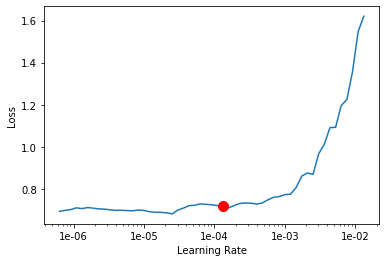

In [66]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.404633,0.334834,0.864560,0.135440,19:07
1,0.710428,0.696898,0.500000,0.500000,19:10
2,0.695162,0.696370,0.500000,0.500000,19:10
3,0.691192,0.695797,0.500000,0.500000,19:11
4,0.695383,0.693224,0.500000,0.500000,19:11


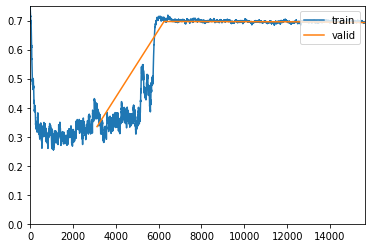

In [67]:
learner.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

In [51]:
learner.save('albert-no-pre-training-freezed')

In [40]:
# learner.load('no-pre-training-freezed');

## we only have 4 layer groups

In [52]:
len(learner.layer_groups)

4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 2.29E-07


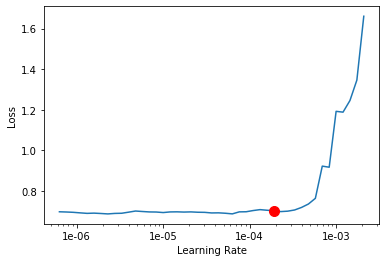

In [53]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-2)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.188021,0.154190,0.942720,0.057280,11:49
1,0.149319,0.136903,0.949360,0.050640,11:14
2,0.119082,0.133555,0.951440,0.048560,11:13


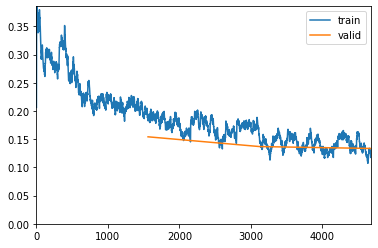

In [47]:
# ignore suggestion
learner.fit_one_cycle(3, 5e-5, moms=(0.8,0.7))

In [48]:
learner.save('no-pre-training-freez_to_-3')

In [ ]:
# learner.load('no-pre-training-freez_to_-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


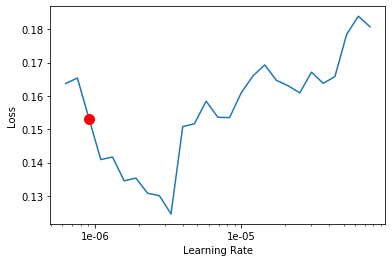

In [49]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-5)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(skip_end = 10, suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.127595,0.130388,0.952680,0.047320,11:48
1,0.127141,0.131005,0.953080,0.046920,12:39


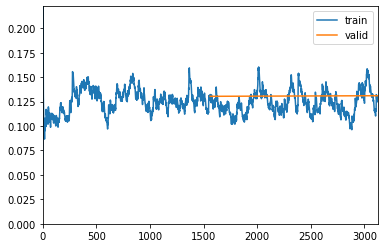

In [50]:
# ignore suggestion
learner.fit_one_cycle(2, 9.12E-07, moms=(0.8,0.7))

In [52]:
learner.save('no-pre-training-freez_to_-5')

In [38]:
learner.load('no-pre-training-freez_to_-5');

### We are able to get 95.3% accuracy without pre-finetuning

In the original guide of Jeremy Howard's ULMFiT for IMDB, he achieved **94.7%** accuracy. All the training strategies, like gradual unfreezing, learning rate annealing, batching are the same when constructing our `Learner`. Therefore, it's obvious that the `transformer` in stronger than `AWD_LSTM` for this task in terms of architecture.<br>

In the next notebook, we are going to push things further by incorporate the **ULMFiT** training procedure to the `transformer` training and see if we can get even better result.